In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

% matplotlib inline

data = pd.read_csv("data/train_clean.csv")
data.head()
data.shape


(38049, 11)

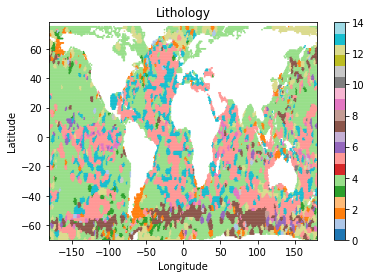

In [18]:
lon = data["longitude"].values
lat = data["latitude"].values
y = data["lithology"].values


# plot lithology vesus longitude and latitude
def draw_global(lon, lat, y, title, cmap="tab20", vmin=0, vmax=14):
    sc = plt.scatter(lon, lat, s=0.5, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlim([-180, 180])
    plt.ylim([-70, 78])
    plt.colorbar(sc)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
#     plt.savefig("Actual_lithology")
    plt.show()
draw_global(lon, lat, y, "Lithology")

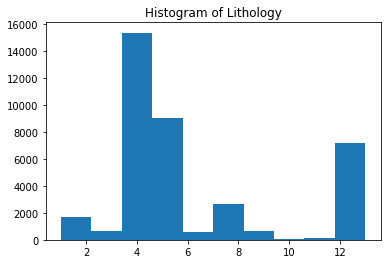

Unique class = [ 1  2  3  4  5  6  7  8  9 10 11 12 13]


In [3]:
# plot the histogram of lithology
plt.hist(y)
plt.title("Histogram of Lithology")
plt.show()
print("Unique class = {}".format(np.unique(y)))

### One-vs-all

Build 13 classifier such that

$$h_\theta^{(i)}(x) = P(y=i|x; \theta) \quad (i=1, 2, ..., 13)$$

Train a logistic regression classifier $h_\theta^{(i)}(x)$ for each class $i$ to predict the probability that $y=i$.

On a new input $x$, to make a prediction, pick the class i that maximizes
$$max_{i} h_\theta^{(i)}(x)$$

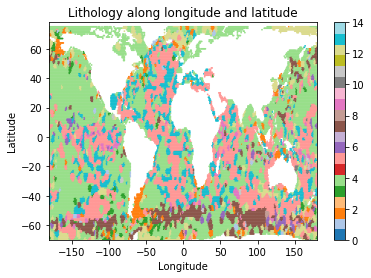

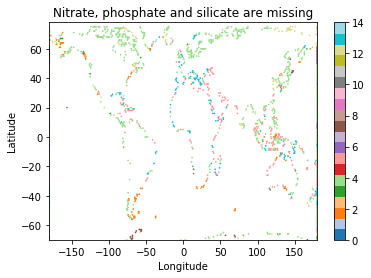

1592

In [19]:
# training data should exclude longitude and latitude
training_data = data.copy()
del training_data["longitude"]
del training_data["latitude"]
training_data.head()

# feature missing reports
# for col in training_data:
#     missing = sum(pd.isnull(training_data[col]))
#     print("Missing Count in {} = {}".format(col, missing))
    

# check missing are consistent
nitrate_missing = pd.isnull(training_data["nitrate"])
phosphate_missing = pd.isnull(training_data["phosphate"])
silicate_missing = pd.isnull(training_data["silicate"])
assert np.array_equal(nitrate_missing, phosphate_missing)
assert np.array_equal(nitrate_missing, silicate_missing)


# global map including and excluding missing parts
draw_global(lon, lat, y, "Lithology along longitude and latitude")
# highlight place of missing
draw_global(lon[nitrate_missing],
            lat[nitrate_missing],
            y[nitrate_missing], 
            "Nitrate, phosphate and silicate are missing")
sum(nitrate_missing)

In [12]:
# obtain list of feature names
target = "lithology"
features = list(training_data.columns)
features.remove(target)

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

# construct X and y 
X = training_data[features].as_matrix()
y = training_data[target].as_matrix()
features

['bathymetry',
 'nitrate',
 'oxygen',
 'phosphate',
 'productivity',
 'salinity',
 'silicate',
 'temperature']

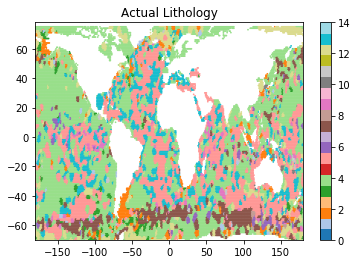

In [6]:
# import sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

# import sklearn preprocessing and validation
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, Imputer

def validate(X, y, classifier, name):
    """Validate with given classifier."""
    # standardize X
    X = StandardScaler().fit_transform(X)
    # cross validation and obtain prediction
    prediction = cross_val_predict(classifier, X, y, cv=3)
    acc = round(accuracy_score(y, prediction), 4)
    title = "Prediction Model={} ACC={}".format(name, acc)
    draw_global(lon, lat, prediction, title)

# different classifiers
logistic = LogisticRegression()
rfc = RandomForestClassifier()
gpc = GaussianProcessClassifier()

# cross validation
draw_global(lon, lat, y, "Actual Lithology")
# validate(X, y, logistic, "LogisticRegression")
# validate(X, y, rfc, "RandomForestClassifier")data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAWUAAAEICAYAAACH7+U/AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvNQv5yAAAIABJREFUeJzsvWeUJMd1oPvdNOWr2rvp8d4BYzAD7wECIEGQBCh6b0TKkPK7klZ7RGrf7p6j1VJ61CO1XIqiRIAABVIkQRAgYQd+YAczg/G+p6e9q+rylZWZ8X5kdXW1Gw9Mg6ivT52uioyMjIyMvHnzxo0bopSiSpUqVarMDrQLXYEqVapUqTJOVShXqVKlyiyiKpSrVKlSZRZRFcpVqlSpMouoCuUqVapUmUVUhXKVKlWqzCKqQrnKW4qIXC8iXWex3ydE5LHzXW5p38+KyPNns2+VKuebqlB+hyEiT4tIXET8p5l/oYgoETHe7LqVjqdEZOnkdKXUvUqpW06Vr0qVtztVofwOQkQWAtcACnjfBa1MlSpVpqUqlN9ZfBp4Cfg34DOVG0QkKCLfEJHjIjIqIs+LSBB4tpQlISJpEblCRL4uIj+s2HeCNi0inxORfSKSEpGjIvLlc614pYlBRMbqtLNUp49U5PtTERkQkV4R+VxFeo2I3C0ig6Vz/K8iMm3/F5ErReTVUju8KiJXVmxbJCLPls7tCRH59lhbiMjDIvLVSWW9ISJ3nuv5V3nnUBXK7yw+Ddxb+twqIi0V2/43cAlwJVAP/GfABa4tba9VSkWUUi+exnEGgPcCMeBzwD+IyMbzcwqglBqr07pSne4v/W4FaoB24AvAt0WkrrTt/yttWwxch9cWn2MSIlIPPAz8I9AA/D3wsIg0lLLcB7xS2vZ14FMVu/8A+GRFWetKdXn4HE63yjuMqlB+hyAiVwMLgB8rpbYBR4CPl7ZpwOeBP1RKdSulHKXUVqVU4WyOpZR6WCl1RHk8AzyGZzZ5sykC/00pVVRK/QpIAytERAc+CvylUiqllOoAvsFEgTrG7cAhpdQ9SilbKfUjYD9wh4jMBzYDf62UspRSzwMPVuz7ILBcRJaVfn8KuF8pZb0J51rlN5SqUH7n8BngMaXUUOn3fYybMBqBAJ6gPmdE5N0i8pKIjIhIAnhP6RhvNsNKKbvidxaIlI5tAscrth3H02InM2dSvsq8c4ARpVS2YtuJsS9KqTxwP/DJ0oPuY8A9Z3cqVd6pvCUj6lUuLCXb8IcBXUT6Ssl+oLb0ir0LyANLgJ2Tdp8ujGAGCFX8bq04lh/4KZ554BdKqaKIPADI+TiXs2QIT4teAOwtpc0HuqfJ21PKV8l84BGgF6gXkVCFYJ43Ke8P8ATx80D2NM09VaqUqWrK7ww+ADjAamB96bMKeA74tFLKBb4P/L2IzBERvTSg5wcG8WzLiyvK2wFcKyLzRaQG+MuKbT48gT8I2CLybuAWzgyfiAQqPvo0efon1WlGlFIO8GPgf4hIVEQWAH8C/HCa7L/CM0F8XESM0iDiauAhpdRx4DXg6yLiE5ErgDsmHetFvPb6BlUtucpZUBXK7ww+A/yrUqpTKdU39gG+BXyi5DXxZ3ga86vACPC3gFbSCP8H8IKIJETkcqXU43iv6W8A24CHxg6klEoBf4AnBON4dutKu+vpsAfIVXymDMjhDbL9oFSnD59GmV/F0/CP4mmx9+E9iCaglBrGG6T8U2AYb8DzvRVmn08AV5S2/Xe8dphse78buIjphX6VKidFqkHuq1Q5e0TkfmC/UuprFWmfBr6klLr6wtWsytuVqqZcpcoZICKbRWSJiGgichvwfuCBiu0h4PeA716oOlZ5e1MVylWqnBmtwNN47nb/CPyuUmo7gIjcimdL78czj1R5ByEi3y9NXNo9zbY/LU2wOqUXUtV8UaVKlSrnARG5Fu9hfbdSam1F+jzge8BK4JKK8YlpqWrKVapUqXIeUEo9izdIPpl/wBswPi0NeFb5KTc2NqqFCxde6GpUqVLlbcC2bduGlFJN51LGRdfeoFLx6eToVI7vfmMPnj//GN9VSp107EBE3g90K6V2ipyeq/6sEsoLFy7ktddeu9DVqFKlytsAEZk88/KMScVH+NrPfn1aeT+/vD2vlNp0umWXBn3/C2fop181X1SpUqXKm8MSYBFeNMMOYC7wuoi0nmynWaUpK1wKTgGUAlGAhlIuCAgaoFCAIN73koWm/FagKO0HKCl9F1Cln6U8qpRfFKhSHinvq4FSKFHIDMdHecdUqlRmqTxTfBRLMXx8WgAXFwANjYJbmHB8UzNxXBsXF1PzoYuOo2wEDW36iJJlHMcqnX/p/AQc1ITz15WGiMIF3GnO39RM9Gknyp1/lFIUXK9dKtvcUIKUvnvX0kVEQymF5hbRXEXB9JXbXMfFtAogOojC1g2c0nfvQIIhY8cUVOn8J1/zyjzjx1eAQkRDs/IICkRDieDoZmlnwVZqwjUfa3NDM9Er1gGwnAIuasY+J6V+drr93Kf7TtkvTvdaWG6eyf1crzj/sXzeKUu5n0npZMbaTdMMymsfWFmUEcAtx17S0HUfMNZf3ZO2eeXxKo/vTHOfTbjPZzFKqV1A89jvkmDedKqBvlkllIesAf7txD9e6GqcFYLQ5GtjwOpBENZENzJs9WOrIvOCi3l99MUJeWuMehL2MABzAvO4o/Wj/LTnbiJ6jPe0/taMx7GsYTo772GskwO8rjvEK8xVNUq4xNFwUTxnuDjTlNPqn8v72z52rqd9WrwSf44dyZcnpDW6wsWuNmNAjAU//yaHW+fz1NXvK9+Mtz5xPwu6jiC4uKJxz8f+FMs3voDKQkdYosYF16u6Q3LSAZY5GvPVTEeFyLFdtGz9eUmKKvqu+zCZeSsB2K45jMwgF+vNRj7U7k087Mmf4KG++8ce4eeMICwLr+KGptvPuawXhp9gT3rHhLQWV1hzkmsxE6bZwIIFnwErC3+/ipGbvky8LlCudXv7h3DdIr29Pz+runaJ4oDunjrjLEFEfgRcDzSKtzTZ15RS/3Km5cwqoSxoGJgl/cDrjGMdeyyt8vt4mnDZa09S67oMr78RyzDZr7lYuKVSBE9n8jqeiyrZbbzypdQdx481nj75+AEtQMSs8R7feNq46ygyboq8my3VX+jJd2I7NgrF8exhTMxy7V0UjmsT0sJoSiNv5xgq9LMispbjmSM8MfBLasw6evMnSlrC+JkuciEkfiqDoTUpnbR4NUa5zHV1RDR05bLeEfbpLoWS1jZ2TgUnz2Chjyb/Sd+kzgmlFM8PP0F/obt8XcfaPKUJ2zXvvMaEgShY6WgEgOycldSlhgjbCsv0NK7e+WuYNzSA7no3atvwEN1ti1C4aGhkNXAdKV1loVE55EpamYsiqIR6dBjrF2UtcByrrh033IhueZp9cLCPzLw1gEYzBqnSw9At9xvB1AxWRC5ioNDLKyPPY6kCPvFjK6fc5l6fm9zPZu7nghDQghTcHCBEjTrOlt58F6+NbEWJS8HNYeArtbt3XEsEF0E/pVge05h1REyUsjlx4n58Zh3yri+Tr6nHi/sEmqYzOPgsIoKIHy/8yPRtXll2JXMU1DkKVwmigXJdECGtCUdk9glrpdRJtRyl1MLTKWdWCWWUi126qJMJ5gXNBctUFM3KfRSRVJxl+18itWIzYQHHLWLjYHt3xLRMpz2eDi6+KRqm5RT44YnvUHTHw+aOFAcrd5pCyh1FEMJ6lBF7iBO5DpZHVvNy/DmU5RKUMDmVmbLfUlufoH8pFH3KndBqtcoTOqUMZJUzpR3i9hBH0wfeNKGctdMYmo8D6d042OgKdAWF0jWxmRowwgc4CArB33+YwdpGMjqM3eixgaMUnQJ60RsAH4zGsLEwihb+XIY6JRiaHzcY8c4RZ0K7GC6ElMZYY4zJhnzpAgXQ0JP9OMUsupVBAenmdrze4jDsOhSn0ZRd12ZZZDU7Ei/TXeiYsU3OpM8Jgt+oI2UlESBlx89gbw/LtRDgWPYgPdbMY2J+JWhnMLykVBERP7Y9im2PUih0Q00YL1Kqh+sWsay+afY9/fprQHgs/9g9pCDhuG8L88XZMquE8kzP6VhG+MgLYUTB3TekJ9xoa/e9ypWvPEa+fg6JdTeAeMtdtCvhmHb+L9x0r6SPDT5A0AjxidYv42BzX9d3cUq3YI1Rx52tn+QXffcRt4cBIaJHCegh7mj5MAWV5/6uf0HhEjaiXNvwLp4ZfhSHIp+Z+xWeGv41nbmjzAss5Kam9yIKtJIdLp/v56W+n5CsMA1rUNZJAVxRMzbsztSrLAgvpTUwXVjhs6cn18nD/T/hpsb3ltvrEkenIIqd2swajiXQocFqV9CLeYr+YMWAATx/1R0sPf4N74cIlt8zXbzn8R/ROuCFNT5x2xexSkK5OOm8DQGZZLrIo9hqKFY7Gq0KcvNXYR3bhXliP8mlG8m3LyvntWeQW9c3vpt4cZg3UufmOWTiw8Hh0rprWBFei0/3U3Stsk35THmw90doonNn2yfYWHMFY2MnYzZ9z6bsvT8O9z9KNuuF025ouI5odHWpFOH48e8xOU6/645OOtrZqjlnzjw05v3myuTZJZTDaFxlB0AUDrBbV+RRLOvS+HrdIa5o+SL1oxrDDc/iat5TOdG4gGKwDtN2MQoWdjACCHUC3crmhWPb2Th/LX7DxOt+kwZRGHt9dCtSPSabSUzN5OLY5nJ9nxl6lHhxmGXh1Rhi4DcCKKXYUHsFQ4U+lAtFLAaLfWyIXcFLiadxlI1SLg1mEz7dj7hCrdlA3snz0+67sVWRkBZmdXQ9ASNIo9nEaDHOuprN+HXPXpfP95NIbKOx8XqWxNYRz58g6SShdEYZ0Ykpz1BTr4Q1LhzUnAkGGUEwNZOgXhkW+fzQ4Gtmfc2lNPvnEDVq8BfTBBCiSmOV63JY89q6ss1rCo00p+bhM/NI+Ahd7/0DbOUQEAN7zAgginvu/DN+0bOStGuS742wLnOAj+Qd8EV5ueZivp65lT+t6WKxL0MTekkb987ZEsFBSp3eu6rdusJEcVgH09FoUMLA1R+m4aXH2d3yR6QSS5gTfY2QMUiT6KRLradQhPUIrYF25vjnsXXkKXzix1EOUu5nakKf00Sj3mwkoIUougUGrX5M8ZUGCn0EtBANvgYOpfeStpNc1XBT+ZqfDRtqLkNEQ0QI6MGT5q2r2whoaJpJJLIUw/DyJ5N7SqYKBSUTIKU2HTNl+HzN6LofcD1zW2lUznUVltWH6469E1XeUTMzNoheeZyJ3y9kaO43n1kllAVFgCIo79VWc1xwLPr7ExwIJrnYjJG0euhJd9AQrUUTobH3MEYuTtFoQMsMQ8APImRcF9dKEek/QkOsiURDywSt62ywXZsas47+fA9KKY6lD1CgwLrYZhaFPY1KRLik9opS/iL3dX2X3nw362o28+zII9jYFBQMWf3053soOAWSdgKf5WeoOMDYI6E10E7cGmakOITCpT04HnfdsobIZo8C17Cw6Wb29f2MEWe4ZAcHs2S/K9fbEWzXjzImmkOKrkV/vpu8ncPQTRp85+SHX8an+VkXXgOaj5ydotVxytp7wXUpiiewUrkkbf4aBCGa92Hafnz6CJDH8ZtkMPE5Dq6msEqnc5xadkoLLfYgXU6ED/ZtJ5bsQYCjWox9Wh1KDjKqCiSVmqAti5KyHXiMuHLKZesl04arQ4YaBsKrwfFhu1B0XfrFoljxVuIqlzWxDfj1AF35DqxTrJ4lSmNReDkX12yiI3OYRwd/jobgKkVEi5F2RrkouIF96V3knRyb667Gp/lPWubJWBJZedp5g8F5BIOT4/VDJnMU180yrqq4VKotSjk0NFxKKDR/yr6Ok6ej45/xjFWnzzs98sOsEso+XyNjT1M/sFlp/N3BF9mqOthk3o4mBt85+kcsa23n2uilNA73snnH02iAPzXMvEf+BXXn/yW39EqO9P2YO578dz4/3MfLkWYSDefDdqp4bPCBKanFGW5GQzP51LzfQ0QouIWyixzAcHGAB/ruBaDZ18YdrR8hWRzl/p7voVA80v+zsgnkrrZPTyg3FltDNLq67D50W8ud5cGTX/Teiy83OCG/ltmAFj4w7QvmU8Oe47wgvL/t47T455xGO5ycXK6Tnp6f09Z2Bx9qfB99feNtViiZdA8PHGd5UXFZSz0CJJ0gtpYnEjlWztsINCqNZ0o1Vwp+OLCBL3b9hG2xVbRYcf74+A/LultncA5KhMP+PLor5CvsjoJGShOKZiN6Ic6YcMlXCO1ghbB+bcXf4lm5oT+zDl/9rxid5EGYckf5We893Nx0B+9qej8PD/x4xjbR0PnM3N/HZ3hCtqgsNDRua/kgzf42Hh98kIQ9wpLwShYFl3NP1/9hy+DD3NZy12m2+ptDa+t7yef76O6+n6ammyvMGh7eQN70yo6uB1i8+CsAHD/+L9h2EhDmzPkQxWKCwcHHzrpezc3vwQt5/ZvHrBLKKnGcOc/8lN6r7kIZXtUurpvPrtFB9mWe4dix14gEQmycuxZdDEYb5rPr1j9k3UAcNAMxg8jSmwkGY6yuvZT09WGaOvazMlKDHVyNa5iMWnGSToImXwvduU4cnAqjxXjnEqDWbEQXjZybpcaopy9/ArekJYx5Z4gIe5LbWRRajqlNtfuNdVif+Lis7jri1hCuUnTlj2G5BQShzmxERIiaMVZH13MovRdRgqGZ1Bh1PD74IOtim1gdW88Tg79kxBpifnARtrK5uuHmCTfGpfXXUkgfxFdIks/3ADAnspuUpkhistbWMICsBrs0F1MP0Gi2MmwPENTOjykjEGijoeEa/P42+voexlsez2vfla5CxGVz/XJMd9yYEIsdB/RSXqg0HNWJTrxkAtgUjnPdpUuwU1G2jNYyEp5DkxWnx9/Mo223YGLww77L+WTLHuboBgU3hS46a6IbCBsRWvQohp3FsoY4mN4NMm7O2K4rNro6PgURf5x0sa301hZiUCLoZKn01Bm7/i8OP4WIhomJqflo8bfTnTs+oW9FjBiGPj5CHdajRI0agnoIEWFDzWUsCnlvW5qmcVXDTUSN2Hm5HueCiOD3N9HYeC3h8GI07cx8pcf6ZWPj9WQyxzCMIIFACz5fPen0AnK5nlLOqWYKEY1AYC6WNYjj5CrSheHh587PCc5CZpVQxrGQzAj+oU7yLfNLHmcOMcNHb36ULBnCKoSmaTjYKDQyy66Dy2+cUIwGzGu4BhqugYugFhiLNr4j8Qp70ztYHV3PidwxXNyydXncPc6zCtb56vFpfnrzJ1gZvYju/PGSHXTspvSc/hPFOB2Zw/g0H0EjTLO/rVwXpRTd+U78WoCLa7wZmiPWIJ29h0vHFiy3QH+hh2ZfG/ODS9iXesM7jivYbpGknaAv383q2Hr6cz1k3TR9+MhTIO/kJtgL24MLUIH5DA5uIZ8fH3HXXah1IVA6X82FIC45itSHGz0XPvfMXjNnQsTE728il+smn++DSR41hgNhQNdg8qutP6GhFwUrpLDDXlubDnRaUVKOQcB1aDYzJFQbtVqCREMtjhMmmzfp00LkFGQcDQsHZYRxrVEEWBheOsHTJJvtJJN+g2LF24uLkFY2NoqkK6jSpoI+Qk5LM60bjfK03vFChCZ/K525o+XrC4qCm+dE9hhzgvMwNR+2KpKzM3RlOwgbUXyaj6XhVeViloZP3/TwZqNpBrW1G8+pjEhkKZHI0ooyTXy+RnK5LqaP06NQSiMWW10SwGP9xHOpc5zpvbTOlG6ryF92DZyXss4Xs0ooi20RGOnGyI2WH5q3tC7nvs5t5Vf/gM9HsDRhwKf5ubLhxpmKm5b1tZeyvvZSAL6w8I/L6U8N/oqDmT00+9v4QNsnpt33i+E/njb9gZ772DL8sHcOCJ+Y+zuEDc8D4ESug18P/AcaGp+e/xX8mp/HBx8kYsb44JzPAHAovZcHe3/Ee1s/wvzQIhaGltCZPYaDzbDtmSLyKgdAQeVxccm5WZJOgueHn+Dm5gnLxJHLdZJMTlz/dCkTiQJBIEGe15Mveg+HU9hET5dc7jg9PT+bcfuSGdLNrDB3m9+zD1+TK6cbhQj/3L8JF3ii/RlMFPvtCO9f9DpbltzJ5oJL+tHHSegRFDBQDNFn38EfzZlqIx0jFJrPLYv+cEJaojjCj7u/j0LRaNeVzSKjtU9TKZDrjEbi9vSTsopYvJJ4ljXRDVzdcHM5/b4T3+WRwZ+xoeZyLq27hrybw8LiufjjgNdv7mz75JvqNz7baGq6jqam66bdls/309X1I1w3x8KFn5+y/cSJe9/s6l0wZlU85Y1rFqvXv/lphhtriUe86aYgFJXD7tE+/uHgM9iuS8D086VLPse1c65nfui01s48JYniCIfT+1kQWnzGN8ZgoY8DqT0cSu/BxcUQ0/OjVN6Ie5t/HvNCi2j2t/Hr/p+Sd/KICEE9yC1N7+fZkcdo8rVxef116KITt4YYLPTzcuIZHOWwPLyWFdE1nMgeY/voy7jK08CUKBYGl5KyRzE1H4vDK1gVvRjXtRkd3U46fQjXtbDtdNl5v3KQpkdzOaR5U5uXhFdxdcPNZzz1estwkj870MknWl6l0cxw2WtPsnigm67rP4xrmFOOOf1373frHpPQkI6moOhXdG2ycEzPQ+PFfAPHiyE+GO3GxOWgpujWPI+A5Y6GVvDz+4ObQQ/wsbZ6Pj6ngQXBMxskU0qxN7WdlJ3CKLSwt/A8Nt5rc7O/BVvZDFuDmJqPBcElBPUwbslE4U0QcdDQ0ERneWQNMbO2XHZ3rpPewglWRi4mYkQpuAWeGnyYeHGYRcHlhIwwa2Ib3rKp77MdpVxSqX2Ew4vRp/Ecyed7CQbnbDuTAEHTYa5YrRq+c3rrEfTfuOGcj3c6zCpNWQvWw81fR0ZegpFX8W5cF1OgQXQ2ZLNsNTVc5dIzMsR2tYtd2j5uWnATAePsXYcAas16NtVdeVb7Nvlb8Wl+jmT24SgbWxXHZy0paPA3siK6lsFCH5Zb8G5kBQU3T1HZ5J08zf7W8g1Z52vErwd5Of4MGjoX11xCxIhxIL3HK3vMrU0JcWuYtJ3C0A2SRc93VNMM6uo2Y1lDFItZisWMV5HJr9+uwhUXHY32wPwzFghKKQbyh1jg68NQSfJukZFAKy3OCMHuA2TmrQJt3E5vWTXYdgDTzGCa6SnluY6OOKV5f5YiNKRINbugKxq0PGFfAV3ZPJtrZNCwqAt5luYULgHNh4iLqQl/sKCFsHHmwk1EWBPzXtMzdoo93QVsVUDQiJq1JK0ELi4ODsuiq5kTmFkTn0x7cD7twXEPhf58D4aY+MTPZfXXzjhY9k5FRCMWWzPj9kCgbcZtb3dmlVAeo77+currLwegt/dBMpnDrO07xk+KOWwzgO063LPPW71dEL7mfI0PLv/ghawyNWYdn1nwlQlpRdfiB53fIm17AqjJ38pnF3x1yr4fnfuFKWkhPcyn5v/ehLQr629gX2ontvLsaQrFsO3ZwwoOZEq+ymO0tLwbgMHBLYyOTox3ABDXXFxRNPgaWRpZNWX7qegvdDNa3MJtFQvc9Db8Npe9+i6cTHPJBOU9nFzXIJlcBQh1dduYzo4YSow7qBo2+JNCqtX7vdznPXD2FGL81fAaPt/6KrWlh0yPBlE7yLBj8u2Vc85KIE8mbETZWHc5W0e2oHDoy3eRsEcIaiE+Pf/3z6nstJ3ikYGfAvC+1o9WBXKVCcwuoRzvgF//Obz7b8tJjY3XEXQjRPd/h2/lkhRH0uxfei0717ynHDnr3YvefeHqfBJMzcdtLXdRZ55yWa4ZeS2xlT3J15kbWEhXvsMziaBXDEoqTM3P+uhmlkTHBevB9B5eGH4SEWFz7DLaG69jZOQVXNeLMAdeEBpXIGbUznD06emNF9h2OEEw28+1fc+x9dJrELeOuuFbSMW28Ys7vsR1h95AEAyzDsfJU1u7mpqaNmzbxDBi5Dpeg64A9rrecrlWTAgmdFAK2wfxRQomaO+KBsPhimg/cwMZ9LF2ECFYq/FPja28q6HmrNp5e+Ildoy+Up6BqInGyshFXF1/M0opWgPt9Bd6aPA1n6KkUxPWI9zUdAe2W6T5PLggVvnNYlYJZVfTGamLwMhL+P2thMMLUcpF6Rqu4cNUCh3F+thC1q/9zIWu7mkxN7jwrPctuAUS1rAX+hEviJHnZuUpoRqCJgYBLciqmvX4KyYaeKEhwVZFuvI9+P2tpSnGikot1VQuGTtFzsmedHafZbt0DuZwXZfRrIPjQiy+g9DQMLndBYpkOFwzxJLaJNlgmKGGTejomGYdIqPEYmvw+RoAcJxGerfuJjjwNM7eETILVuOEYySbbHIxL4SlEhdXr5yw4GmTe/NhEsOvsT17lCUNc6kP1wBC2KzjXS1TX2lt12Z/eheOKiJoLA2vJFQahJ3c1k4pgJBC4SoHR9msiW0o52n0t5zehTsFIsKS8IrzUlaV3zxmlVAuBgKMNIZhZCsiBosXf5Xh4eewel6kNtE1Hplt+MiFrupbwpH0Po5lD3Jn2yfpLXRxJLsfGBepfi0w46v0ssgqdiReYsQeoiN/iJb0ESITpqd6pQyJQ8HqYm9yB5ecxKbeOZhj1/EKO7By2fDGX/C8u4GhQZvuWp3cdUdY4BsgWGih0BwhJP20tNyKPnmqcFYIbjtIvXEfdjpGcuUmwCXdfrLIX15c4f/VZxLs+zFDwLr2ZSW3MzWjF86J3DFeGHli/NBOhsvrp474J+04DjY1Rh2jpeA/ieKZBwGqUuVcmVVCmVKsAICEleX6f7+KO+eu5fa2VfRd9zFan/8p4iroeA7+e2tFPM0Y/O5WCJ+9mWC28aue+1iSG+QGCRCTADWRiwnpEV4aeYqsk0HhBY7/Xsffl+MqbKi5jI2lKd4At7R8gCOZ/byeeIltussVjoavwvuhQ3MpihcfbFdqG0sjq6gxpw8RGTB1tJLJt73/ETa88RfoAteFXa6JeVPY9/f081KNxsV6hkAoAwj9/Y8yZ877y+XsSLxC85bXaWvLwIgfM5djyf1/y/C6G0isvpzJsRUmoliR/A49ovO7S67F4MouAAAgAElEQVTiehUE/yLCtRvKLoiVFN0iW0e2IGj4tQBX1l3P/PBk50CPq+tvZm5gIa8knsMUH5fVXsPC8LJp81a5sCSTexgc3HKhq/GmMcuEMowFHAnoPhp8YV4YOs6SYANXD3ShxESk5Nql6WCGvHgW0VY4iyhas5VCYZCWYr7kUifEE6/RpYsXXEdJRcAbKEfjVYqenDdJZXV0PWk7yYH0biJ6FF0MHCyO6gpNeflFFGkZi3DseVJ05TqmFco9wzm6R/JoAll/ByMNI7imH8cx+WXzlby3qBNQirkJg8sPCoFWB1WSke5uH4ltRxicn2RoXoJDmSy7YwtodUJ8IVVLje2FMI10HkQKeVLLN2GHa5nOdU5E+ODci3ms/yDtoTo0MWkOLyEWnBp3IVlMsCe5A9d18YufOrOeJZFVM67eETIiLAmvZG9qJwrF4sjKNyVYU5VzR9OCaJp56oxvU2aZUFaMhQCMWykOp/tRKBbYa6jd9xxS6VMtOvz2FmhafmGq+iYyMvIyNcUEAK7r0JvcwWvGqYN6dxc66SmcYFFoGXtSO9iZfIWwFsFSXvzhbnFnji+tHF6MP83q6Pop3gDbjiaxS4EzErGtLOh6DjMfZ1tsDUdDm/CPdANQk4ZoVji6uDT7ytJQT4dIuz28PHcHmWSeB4dWsU1v4wPuXqL5fsYEbmDoGFp+lPi6azlZAJu2QIiV0XqWR+vQNZNYbO20+XYnt7OrFErzougmrmy44ZTt59cD/Fb722Os4p1MJLKYePzCT0F/s5hlQhnGNKNv7H8GTQSlhFEUruFHt4vedhG48a9/4wTyT3vuZsQaZJkjzK2QnhGEtY6wR3fLsTJS9ijX1N+CXw94AX3sUV4YeRIXh3u7/m9Zj866mTFdekrcBu/7WIsrlHLZMvgQN02aIXjdzi/z9Opv8q92nqtckzfWXslfN32JfdkWPjo6gAvopXiLn21bxVPddZ5VyVXc3d7Pntv2kBONb3beQN4x0IFEZBOD1/w/1Oz9Dv6RXgTwZUZpfe6n9F37oXJEv+aXfklg4AQnbv8SStdZFm1hUcN6WusvI+Cvn7YdBwq97E1tB7z1EQPnEP6yylvDnx84wSujGZ66dObp5U/0/4L21DHM0wj/ebqs9KX4+bzTM4W8Vcas8yKURaQW+B6wFu8+/zxwALgfWAh0AB9WSp105MQuuIDBkfQQDoJf826m/iM7wAiAGCWzsw4jh8Epgj7za4xSil3JbaTsUS6puZIj2f20BeZR75t9tufBQh+2Y6Ohk9bEWzGyIkBLGC9uRREvZKShmdgUWRryOnHGTnMgvYtUcbQUi2FMEI+VMCXcC9OJ51wxQd/QczTXX4Gmed0jZAqrj/1Plix/H48Or2Gpm+G/9A+TtLK02haZZo1CgwP7ClzyymMcXH89gw2ezf87C2Nc5gbptGrxi4AmvCc1zG+lhoiOBiByF3vndbL00HP47CLZuasR0RlbvCrfvIhw91Fatv6S7JylHFy2nrpQE8ecIdYaU80WALoYmOIHZaGLhl87eSzhKm8tR9L76cweJWSE2VBzGc+P7GK4GGNjbHpz0Z7kDs8n3h4lJhr1Shg8PPIW1/qt49yXx/X4JvCIUmolsA7YB/wF8KRSahnwZOn3SfHW4bJ4oGs7xzIDZJ0sWSfLNUd2oOcSYKWhmIbCKLx+D8RnXuIGvHjGL8WfYXdqO125Y2wd2cLe0R04ysFRb91KCafDrtFtJJxhbIrEXKskfsc+NgllkaOITZG4PUTWSfNqfDxSVtiIcOecTxLWY9jY2BRxSt9sb3GsSd+Lpe/F8nebIsVCH6nEqxQKAyjbAtvC6HmdvBxmq+VnV7aOhl6N6/qTvC/ez6WpOIm5GXKhPHuPdZI7uIe+cC0ZxyWt4EhdFk3L8NTQXFIWFGybP+k7xrXJYUIpG1u1MhACMxPH8pskF63ypoTbNjhFQsd3ouXiRI7vpOD3s08K7M528HL8WTLO1FmBADknQ15lcbCxlMWoNYyrXBzXxnZtim7Rcy+cZX3gnYDt2rwwvIWD2T3sSL7C8exRftx3kEeGsnxxbhNFV2GXrpOyLVQxz0vDT3Aos5chq5+osnCcPHse23+hT+VN45w1ZRGpAa4FPgugvHVjLBF5P97KrgA/AJ4G/vxkZaWHs7wy1MnW4eNl/Q2gqBvglqJCRVpg8xfg+X8A4+SDe48NPkC92ciNjbeTHHgCwWVPZjsHMrvRRGN9zWVsqL3szE/6TcCsGLjYp0OdLVTqd7pMjhXhxWs+WTkAUb2GtJMsmzNOjdfu/Qe+w/xf/hPiOGA0sIcv02E1oAF5TZ+geeuuxvZomO+1Lub6zmPc172PDy1ahwu4orP5qJ8vH90z4YVz7HukqHH9scsZvH4jyXZvLcHmvT6ivTqpVgdlBPB0B8VesXAFRt0Rrq5/14yhLdsDC1gT3cCekgljd3oHnfkORu2J2pWGxl1zPnVeJoRUOTXHs0d4dODnE/riU8O/4o6mBfzFklUgwp2vP8odjbupHR3iQ7/4Z0S5mB/5Y+xAEASe7k+R/dbr0weW+w3hfJgvFgGDwL+KyDpgG/CHQItSamy6Vh8wree9iHwJ+BJAfTjEYqeJTy28nJ9378IpxU7cGa1nbrq0aobhhyNbwF8DD/2J5w53899A7cQ4BMPWALlihgWuIjf0LK6d5WLXzwFdoTAQNDqyh+jLdaFrBpfUXXneVt44G6JGDSa+sslhjwExJSxxPIEULy1bNCYMNTFYFJw6AWFJeAWJ4jBFZSMo6o1GAnqQuDUEVK7sPfH7mLljVIOdmmCGYyTnbOLb9Xfx6eQoV+kj3Brp5oXsXDqDEdI+PzHX0zT1wQbCRiNm2yhOMETz6CAP9u5nT5vD8XqLIUPH9WkYrubZit3SuoEi4LqICHVdBnbQwgopzLwPZQhDmTCPLfsi71m+h2BmmPZ4gu4FOrr4qDXrsNwCLwxvwaf5uKL+hrJnRcHNM1qMY2AAgi46fgnQaDSXbdUKCBkhwnr0Tb6y7wzyTo6tI0+Rt7PesE8pxCalwFuNZjPHcodK6xB64WN10YkaMZZH1rAwFODV+MvcUNeDhkkxVEeqro1YMkHr0BBdcxd74x61EfzNNbgJ65R1ertyPoSyAWwEvqqUellEvskkU4VSSolMv/ysUuq7wHcB5jfVqbrmAP1Hh7HSGfBr+J0Cm+MDlIPbWilIlMwWh0syf/6VsOp9FIIR/EYIy7U4nN7PiD3EakcjV/JkAEVWuSCWt8qzNf76GzPqiNbV4NN8pKwUUd9be7Mm7DhFxjvaKGAqz3iRA3on76CKrIhMDdiyInoRL8afxil5MKTcJPOCixicZmXh6XDwluKqTSd41Z3DL2o388fxnSSCKYbyGj7LYv3oCFFrPMxn3IjSn/YRPNFBpGixwB/ETCXoXJGh2a9oGzTRLY3JAZFyhovSSlqzpciGLQIJDX9cQ0N4ShoohrL0heYzJ9VHZ1MLRRyKKkfCGsFWNgczuxGEDbWXE9LDgBfspyvfUT6OrYoMFfv41LzfO+VadVXOHEfZ9OQ6OZTZM2OeE3SQY+JyZLYqckfTR6g3m8jZWfaMvkpEz+E4YAykCA9342jQ2dxcXpfciaco9CWmO8QFR0S+D7wXGFBKrS2l/R1wB2ABR4DPKaVOegLnQyh3AV1KqZdLv/8DTyj3i0ibUqpXRNqAU0aS1hpDaLrGpbvqaTuyjIt/K8xNL/yitPUko62/+lMGX/7fPHD757mh+Q6eHX4MWxWJGbVoTmo830nWXNyZepm96e20ucv5q+f/ivtuv4+V9W9doPFrG25hdeRiHui7r/x6N6R5n5n49eBP+fjcL01IMzSDT837XWzXiybn1wPoYtCZPVJaTfv0WLN3Me9e8kEE4bfbV/BUx04e7D0OTLXjrzzewUrgI9EAXHVTOd3VhfZhjYtP+Kc0e0eTzaMb8hOuh4kPN+JwxYqNhJ7o4Gsti3BGhYWZDP+2xCajj7vKjcUhhtKU8hJFt8gTg7+cUkcXl0cGfjZjrOwqZ88ve/+dfmuK2jCByQIZYHPN1TT4mjmY3sNTQ78qp7sPLEEdS6I1wq9v/AiOryIEa+VKxrOPfwO+BdxdkfY48JdKKVtE/hb4S05hxj3ngT6lVB9wQkTG3qVvAvYCDwJjTp+fAX4xze4TKbrkMWlZ1kL4mkV0LVjLz+76A7oWXgy+SOkTLX0i5f/KF+XwyiuYJ3WkiylMTHziw3FtArueRy/YgEG98rHa9XvL9uDDxIeBUfpvYoqJLXkaAg387ODMQdrfDDTRaPC3sDJyEe2B+US0GCYmxjSfsXSUZ6ebjF8PEDajRMwYpuYFbboouomgFi7vO37+Zvm/gUmyWMPwkeU0KWGlaxPWhIzPT1cojBgGYprexzAohAwevdTmgauKDDZoXrquI6YJpsm7d0W56lAE12eCYUApHcNAZWr5edfl/LD3ctJ2rNz+AT1EKNRAbNVK2gyNsCaMuGH+V/wiYipUqrf3F9NrafK1EtACHEjtBkBHJ2bEMPGhY+DDT6PZwtzAQlZHNkxpqypnT87J8kj/z8ja2XJ/0kv303ifmtrPwlqE+YEl5RmTIS2Mn+B4/16aJW22cG/fexg+oJWvt46Bvy6Cv7kWMzj7JvYopZ4FRialPaaUGtMmXgLmnqqc8+Wn/FXgXhHxAUeBz+EJ/B+LyBfw1KsPn7IUXdBUgZ693bjXzqXgg4IviooPM5IqEvAX6DNMNOUy37Ep+howrBQaFofmLWJOqJWjmQNklfdULthpokOdJOetAp8OIhRcx1vheBqN2XaL9I/uRk/2svXIQ7gbvoLmf+uc1HXRubbxVgB+dOK7FDn5kjcpZ5RjmYMsCM20lsc4i6MreD7+BO60y6eOczAbZvOgi5NXHENwbJuV2STt2ameDsNRh44ab2JKMG1AsWSecLxjhIrg3TpTj9llCCccg7yjkbJdikqjzsyA493sxoJFjGw/TKYUJS7j2IyQndAiQWBJaAUvJZ7hcGYf62o2M2INMmqPls03Djbzg4vYXH/NKduoypkxWOjjeG6qUnAqnxYdnVtbPlAeA8g5WQqMrzTjDGq4gTipok1gfi16xVV3ehMU+i+Y+aJRRF6r+P3dkvn1dPk8npvwSTkvLnFKqR1KqU1KqYuVUh9QSsWVUsNKqZuUUsuUUjcrpU7tWKgLg7sG6X5jAKLjnhX/sWcFr43M48+bG3n/vFburY0hwCvrv4mIjWgGt9TdypHcfgbtcdupAdT0HiPatY8xKWxpclJLyIbhw/yqu4df9g6h3f+ps2yRc+fDc7/A1fXvmnF7je5Nhz5tty41MTrcdMSLAR4eWUWLUySnaeQ0g//Te4h7e/ZPeXorFL/emAPN60TB4pk587fXxFkQHiGj/Hyn9wpO5MendzvYFB59hHxF98yZFslJYZK9cPMOOjq3tdzFtsRWftp3d1kgj2GfUkxUOVMcZfPYwKlfficjCLc2f2DCdHdn0vXRb+7G/HI34T/bhL5svF8oxyX3g5nt1m8BQyU5N/Y5bYEsIn+FN1X1lOtYzaoZfe5Qnv1buli4eQGaP8AIBvbOAQzdz6HCQu7qbcFZ1kNnuIN9tR8gWb+Un/zWX6MMC2W9gU/8pfCL3h+6zkjLIsKJOKMKcppBQnNLY/Ke58HGnS9waMlaUhEvpnDn4nU82LaK27e9gjtnDSO9D9Lc/K5pl6R5M9FFZ0FoCUNWP0XHAvHiOcSLI2gi6JrOMv+q8koZp8Kn+dlQcwVxa4gRa5DudA+P73uejfPXsqRxHnuyLTwdX0xE1/iv7cuZYxf4de8+5tkW5J5EwleCHhuP1IdLWzpAX63LmhMmrmmA63lTMLbisaowACrlpY9NlU9kkMK3aaj5EIXgRl5MXcSNdY1EzAKd2aNcu34VH0ybPJq1MMXmsppBdHxe3A5AIcSMOo5lDxHWY7w4vIVRO0Gt3kDGSUHJMq+JRu0MQZaqnB29+S72JLezNnYJ+9M7cVx7whSkijmiaGgVUVq8GOOVHi9F1+JAelfZ82gs30pHw2c3ctitIe3uI3/vHlTKwvQHvFWAz9O6AJY1wPHOb5+fwmZARD6LNwB4kzqN9fdmlVBWtkNuMMGcNS7JuEZca8bqS1IcTVNUipATJGTD4kKMvjkrSPoTJEO2N+vEGX+liWdHsQtFLrYbqRkaJj8/jBJFQlmkJmmLYqUYDfhLkzU8BoImpAewk1Fy6UachvxbLpQBIkaU60rmDIAnBh5ksNgHCkaLNu9p+dC00dGmQ0TKy1090HMvnfEuulO9LLMWkixkeCNVQ4/lRwMi6PQqmJNNU+c6UMyD6x/3FR8r0yoilsO8Pg2zUHGXODNophXpb7gn6JIucsEklpHEJsZFdTdQsHfxcvw5+uau5cZMHb8+cII5/mHqjJEp+m7KTpJxkmhoFPI5LGXRYDRhM74yi6Y0Cm7+tNqoyukxYg3RletgY+2VWK5FeYV3y8Ht8cxcensUTG3KNbNdh6LreRkV3AJdueP0F3rLZYiCqIIapZPI1WMZeQo9IxSODs7Wwb2TIiK3Af8ZuE4plT2dfWaVUAZYGRvk8v7nSW2t5d/v+j2cgUxZu2oMR/i74i3sXmixdUUK5Pkp+zuuw7+/9hC/a13CHXY7UhwlVdOEDew1pl7VlzffPCUNFMkPfIOG797O4ubNsGx2aFoFd9wNzcUtLwt1plxTdxtff+LvUCheOb6dYuQqdmW9APGX6UFyyiXlup5ABojdPqUMATYc9XGiyaEtYZyR4jJElq/7nsJFEY5/j6vNDdx9892MFuPcP/gMCsWWoYeYG1jIN1cIJ3LHpi3HxWFDzeVsH32Z6xtuYcvQQ2you4zF1QDybyprYus5mNrNi/EtrIxcxGChn+HiANZjHRSf60Jf1UDwM9MHigJFsdRvnx16lKPZAxO2tithuauRt+sYyK+jWPM4+bv3vC0Esoj8CG/CXKOIdAFfw/O28AOPlwJ9vaSU+p2TlTOrhLJoGqNSj6VHiRaK3PbDe3ioayVFv+cS8z99EQ6sWM8n27ZjijfpoVYJV+x6kZdr2ul6oJ8ll7azLNrK4WQKC5PC0r/hyWV5cqaGUVo+aGLsh3EPmzHBImi8XjjAzdFWZPsPYd1HZ0Ws5s11VxNNxjiaPYShGeXYIGdKfaCe/7T5P/F059Psj+8jSpzfGfoVX+76MU/e8BWC1nv4Zw2+MG8N/9R3iJBbGsCrDJ6hFC0Zg/q8QumeJl42TYiUbiJVnqyBGv8eJsRirZkuSWLqBpsWraY7d5wGXzMhPYytHJYEl7MidhGCMGrFyTgZwEUTnUZfM/W+JuYFFlLvbyJsRJkfXMQV9TfQHlhwlq1b5Uy4vOF6OrJHWBlZy/bRlwAw2/0cDw7DsQzOQ8fx3b4I0fQJZglB2JbYyqV11zBQ6EHHpFLi5kXjuAbp/Hp0TcPYYmP6/OjLYvg+uBzSFrl/3Y3KzxxJ8EKhlPrYNMn/cqblzCqhrJSLW7TAsRDHYTAOhVQBmiPoLSG0xUHqw4O4vhw2LiiIujqaYeD3h2hqDVLX5Ke5sJB54cWksjUYKkFOFwoVgz+xrEZ9SqOrwcGZRnsGGLaGONrcilKKumwXDbNAKDf72/DXBDiU2YfrOLiTV6c+TUSET6z6BIPZQd4Y3onm5Ll06DXqcoOE8yFAp05PkzctBiIWC+IzmPCU8IKvhrSpsb6QYZ5dmC7XFFxsVmp19GgJ5qgwMVvIOhnqE3G0fBHlg3W1lxIzPTu/LjoutndzK2gJtHNZ3bXl8lZFLwZg7Wna16ucO22BubQFPO8uV7mEjSgNepgjVtFbwm0kg/Sl0FpCOCfS6POjoEEgn0NLjJKJbiDrZKd4A1lFxeDBBE6oD6POIh8ZhMURWBLDDQuRohCYE2Lo4G9uQKJZJZRRUG+m8FEgYQV4pm8BCkX4t9ciER+byOIFn/OIAosUpJdvZDnAB+twlcbNw78D6OgHniQZciiYEwXvu7cFGI66dDTP/LQdNR2euMqz55rZZ/g868/76Z4NliqUvQuKrgWlWWxnw1BuCE003jW8ixv7t5ANzgN1A4iwtv4NXvE1IUnPx3s6XvVH+Hj7SgwUhw+9ctrHDWNwlT2Xh3z7+X9zN9N2eBna2tWMPvJ9MpcUuLT2urJABrix6XZ+1uutXu7T/BMEcpULz82lUK9Pxf8Z5Xh90947iO89CynuHoSii77AG9y78pVHWXLiCAe/+oFp3TOHXu3GevAI4b+JIgEDrtPw4y0ILAo2RYMcbA4xsPeUc9HetswqoSy6Rtfv3MkPYgb5e/di+JJeZIYBCz0SpPj0CaznutGX1BD4yErEytD+63vwWXl6bv4sVm0TghA00hScGh7o7SM/tJOOlghbe3Zy1/pb2ThcS7hoUDMsXHVI4+XlBcbiPowxPr5fqhfCtsSLXFKx1NKFosHXzFX1N6GLfsarUAPsT+3i1cRzLA6tYH50PproDARj2IEYBhah4gh5fxP1KsaRfCvvapjL/dn9bChM8lNWijbl0CIuKdHpCEZYUSjN2ppksvhJrJH/1rSQ5YUsd3fvJ+w6vFtbxY3F5RiaoMXj8G/fJ+a4rH1pHv9pfoB7NhVp8XvBlQJ6iLAeoT2wgGWR1efSfFXeBF4YepIj2QO0NPgw/AFwXRRQ+NYbiC4oR2FGg7Q2FpjX14WIwfyf/D43XXMXbim4Vaem6MgWUP8/e+8dJ8lV3X1/763QuXtyDptzUFiFRQEFJCSRJEAgAzYYEYyN8fvYYMDZ5jE274Px6wQYMMkg4EFgE4QkCyShuJJW0mpznJ3dnTzTM9O5u9J9/6junp7Z2SRW0rDSbz+9c7v61q2qW3VPnXvuOb/z2BiaGcD6/A5CHzofQhqV/DhLPd/HOdFZhxE6dzmyF5RQRpd4EQNLlzhL6vGG86AJSJh4eHi6wCtakC7hOR62EDjKJWQVEKUs0IAQAkEJT4GnBynkCwxMpClaJQ6O9dMTXMVETKN9ShIoKpSn8KTvw1tra6ZGTCvlkHPSpO1pCl6e1pcwLbwUclaG5ZOhVJqgUBjEwmVCShQwVDhCyS2SdTMEDIOVLYshEMIFdoQW8RCCjcpDczWkcigqk6SUvqsb4AnBg5EEl+XShFyb61NJfphoIl1rU67x+rEQPBGMkkYypmscbPRYP66QriJEeZ+yV4cAwrbNpOXwvaEJooaOQNFhjiOEZFl0DZ2hV2zGCw1ZN0XJK1IKaiQuaKV4IEl+yk9nJmx/NNkHJmmeGMKwigjXQ+amEK6NlL7I1RUoTSJW1MHTo7i5EvaOMfTzW1CGX8dREoWLposZLpxzEAtKKIv6AARA4aGtqad01wGC71oLDb4Po71/As9x0DrDKBOiyUmi2UlQilJjO6DwlCDv+Knsc/07GBBJtqfGQMDR1BDjXSsJ7S3ntKt3cOXsmzsfxaXCJe2keDh5HxPWKO/u+fCL0R2/MkZGfoZtT7BPegzI2deVsVP0NLdySXgjrQe3Eyimuf28j7McnQuRjOtTjDuLUcBF+XRV0D5nhtliRrk6M0WT59JqF7EUbMz7vsFz8UA4zrdjzSjAiKUxikWEN4dytEaIbzfDDCL4dP9oddsneh5kZbSbrlcE8oJE2knj4VJabbKurYeHnjiK8vx7Wrmz+uMHuHTZU8gyL5lV34zS9WqNpHBRIaDJxC1ZUAJnIoumt1Tr1Jdnr5NHprCL5y5L3NkiuT8rEJpEoiGR6I0Rev/2Gl6zoo3LPYMAksh7N2KuayV07SKkkCSbunng1bfiGiHMfAaQSAEr6v6Hwr5HcNMTxN0gIUwMYWDZDkrBjzaXONKmONzhEbQc3vmDL/K+b/8DnSMDaOXjz/zzv48Wh0ha41xa/2q+O/AfDBROTrD/UmLKSvI//Z/HUSUSiU2s9ExalFa9lrCMcFXTjVxcfyWX1V+LFW/DNcOsLA1iTD7OjU9+kkX5EnHNxRRw46KN7GiX7O322DjyWT629wNQegak4H9ND3Pw0FY0WabllNL/lMsdnkMchQlEp6L0joZm6lQ/WrXc69pEEASAkBT8dkcjF9S9kcsb53NdfAULAXGtDolGxEoR1QzCdRGkriN1HU03kLpOMVjHXVe+A8cMgxZAL+QQSuCLIEkcHQ2N4GU9BK7oQTNN3EdH8J4aq47EbZqggKT++iUkPn3VS3zVLxwWlFD2jUcKkKCgHuG7xSjo9CQaAvO8VjC0MjOYItnQxr6NV+GYoUoDTBo57KXTGCvrMW2NgKMjhaQz0YoUAltTHGxz8KTAlRrFQARNKWKZ6RknOQUtyj8m+H7BfrYKB1OaaEKb/xoWAKSQSKkjhIbnWRj5NKu3P87GnU8QLJWIaDEazCYiepQVsXWEhd93t43eS9gtUlRZGgouEc1CKsjoOrubJIdaHZKtF2LIMMKd9LNtAyYKTXkUzDD7Wlby7aZFfKapl/sjdTwRiuMhkUrxqkK6HE3JjN0ZqDokKkWTaxNXLmFNUKdrvL6ljisblxDTEy9BT76CUyHnZMh7OTQFcVchNUkoHkQIiba4DuPKbmTIBFcxLWLsX7oeV0i0UhHhVLRdQVDNrOsYa5qRHREQAjdZKjO++vQIx6THhCYQ2sIdf78qFpT5QqHKbl4eQaBHCcBFAwzlYaNgfX3ZEcxf5Z2Kx8mvugifHNLFQ7FHs1FdeayJFBPBHNN6HkMYbFq0HoRf61Cr774VsnI0JI+CUhxr7666mYWAhKcY0Wrtoy5PTj/Ce3p+/0Xrk+eDhFHPa3o+wJEj3yST2U7Trofo2fcE/T2reG7thVzVcHmVe8CUJlcaq8HKs2nyabZEVpKghV0JjeHxEAqoM/NMtk8zLeD6QhtYExBb6psdakwPffW97GxZwR8XR3GBHx+d4K/aluMA9ZPRUOsAACAASURBVJ7DR8f6T/nAPW2GGRMaPzt/ORtiC48J7BXMxo70M4xZQzQqaEXDKVkkjyZRniLwpsW4Q1mcTB4RM8kvasQYyCGdAqW6RjzDpMKxPS48vIqxY0kUezgNtotcEcOrMTEeO8tqpJRLiIS/dpq1X5yF/gUllP1ltnL2CKHYLmGD5y+9BdGQuNXFuFqL1bO6IqIEF7mC3ZpCINk9vJ+Hzz+AUgpNaNy4+tXoUpt1LFAozcQKRtm56iIKkUT1+OtcSRxB3vMYkB6VjNCOZ/No8hdc1ngtCx0dHW+iWBzDbJnkychvcd6uv2LTtke493x/yqjwc/vdFlmC1AP0WhP8/aF/QaD4w4c+zLq6A3ywfQWOZ+AqHU14/PCqFt78+N9hOMzRdiFsFwgIwceDTXyuOMFbetYj8B8yJSVp3aTBtSkZ8JkLAzQcaOR3k0PV6Vo+oHAv7OfPjX6enHyAlLWOKxpPTMr0guDIEfj5/0A8Dre+/cU99q8ZktY4uzLbEAimpCRntBBlnMvfv4nHvvYspG3MjW2Y61tRKISUPHDlLTx4xc0AlO45hP3oIPrKBgLvXF3lrFEotLowy2WC6w92cmdHkUxo7sLeWSK/WIBYUELZtzDJaqxdTgr2CZ/SpCRAojE3Hq9ChGIJ2KcJikJDoGgI1xMwgjiOQyIcIxGIlduWeHjVB8Ax4bFLX0cuHEMIDYkgqgRGOf4orgRa+SXgn59AFyfOoL2QYBgJNC3ESPv55Ec7GOl6A5oxjkCiKgYg1yF78C7imgk4aAgmGluxG4J0Wzb1uJQ8g7wbJijzWKYgF5LU5cVxJEMtuQm6UoOUEh38Ljrtk4f5z1gTB80QDhp/2bqEsHLRUOzKCYqJCGtLBa4upEnGXHZ3OggpfSGuYNqaJOdkT5vf40yxJ1vge8NJhBB8KCxp6e+DYgFCIahbGKH1CxlH831IJVBlFuWMEISVxkRfCqM9gR4LYWDgSa+cAqo8boU/moz2BI4+ghrO4z01jn5xGwi/TuSGpSw6GGasQeBpAsmMQiVq/j8XsaCEskLNol0sAIOn2fcuMFRT9/DkUTKWn3XkvKZVJKKxMkXgHId1AQd6l9W0Ah2eIFTW30bFzBlVCJ6m7NPP4PFSwvM88vkBDlpNTIUWsX/DJwl0bsPJPlet42QniTzx1Vn7Pb36fC7ri/I/IZMRNJpFhpiWxgWCeYhlTKqDwpvRYCJuhrQWxPTg5slh2iYG+WSiHac8K/1+pEbQFQENluUzKNfhme4Cfe2z781Q6SiH8/tPK1JPKYUQZzZQ/+3IKHeO+URW70gfpWVk0P/hVZfB+g1n1NbLDY5n8+T0Q9XvpghglYZxSh57fr4f8/VLcZsMgsKgpObPOl7cNYxbKOEWSmhRiRAz97++K8HqY1F+vCRL9uT5kc85LKyFvtN++82XF3k2wmaoumprOWdG3OOUu2VcKJLVHhJY39+P/Od9XN180xm191JgamorfX3/zPT0k2xauQav834OJ77Jnuz2WfWEpuPpASqr4P09qzjSu4ofbS6REAodiBYMrtwVRijBZBweXmedMMD76kMPcfOOH7F84iAxFD8Y2ouOKrc++yOAtGFwtNnlcNvx0V0CiXka/B6W53HB47v5u0NDp90/DyTT/GhsGgnoAracdzFEY75JxnyZSYHngfvGflKdpQoEARngkAZpCUbQwPppH2ogU004MR+C71yDbImgr29BX91Y3lpeWNck+7ocRhvm31e8oim/OPDtj75poNY0UUsXpPAQZROHh0KWTQtqTrkt2kLUiCCFZFFDD74fxWwaogqnsmAmm7NAMKRBCoEfYOxTGKmpEjLlEa9vJSADLFgohfvkFyk0BpAyiBbs4OncNlxVpOJLoqrGC3DNCKnGLpqmRnGF5Oii9RhC53G7i+HGDiICps0gX/OWc9PQIQ53FhlsEexZBKsHNH/BsLLgJySi4tRfDibpVC49nsOoNPwFdCGqMw6EYGu4jtuyJS44InhukUUt65EmdALixH29depZ7k5G+WB3Lz0BRYP2NE9N9bGp7rKTa82ex8a9O/j22DAFT2FKwcb8oH/OugEH9oPjwNoTMZ29vDFtT1Jwc2UXS3/cxPQEQT2E5+UJxuMolUMcLSIbYtj3HcEr2r7xsCuGdlk7sry+E377eoTrG0A6XUE9kimpGDd9WRB2XUr67LF9LgtkWGBCWaGqXLgnhztPaXa5f+ooaTtDd107bXWNJ0yD5CqB40kkJYyym022/KlAKLAOjFLoH2MiUpi3nQUDK4e17Svkr7wVDJN8oIHdybsBsD2JLjyEAM0p4WoawWKWurHD5DFIRaJs716Eplx+luwlrwdmvP+LHsXGPA4eWQMiaYHnqPLrsYLj+7jP0OiruA+W2eWq8Dyumh7H9FxShoUzN2OIcsqE9eXWlcJ1HEzAUS4/Ht3Gl4fPY3U0y7STRKm9PJOCVdF1RPXECQWznS8Q37mdWQwatRmGBgdhbAyWr3hFa66FXQQjyIHMbp/Xm5k7nnFTvL3rdgq5DFsmf4KyXczlEUp945S2zPj064uWEnCdGY+KrgAK/173eBomHsc8l1BeUBSQ1+xZx3k5YIGZL84edM1Alzo3rb36pFrTvw9eyj/sa2DvyPG5xio435WYF3fw2DsFP75u4oU43bOHO24jNNxHw65HcZXigbJALno6d46vByBQLHDNw34qHyEE9zZfybIr7uG69qXcf+AJfjS+hkLZybDycYVEqpnH5d5NJRz91BqLJiVSiGo7FQjg02OH6fZshBBcZW7m7R2387b29/K2jtt5W8ftvL3jfayObazuc/uOPrLf+Dp89Svcs+0LfGt0HQJBTJN8ae2S6n3+zuBXeHLqIU6E39jehytO8ejbNnz9q7B/38nrvVzw5Ffg/13CxOQunk1vmfWThs6NrW8B4O6xH4IA88YliKhJ6f/W9p/A+e9DMH08m+BaT1J5/UkhuOmZCJo6tzXiE2FBacoCiV5O+TPjYzEzZanlZVXVfWaXvXLdC9rXsri+B0Po5VQzHrUmi0p5TXiarfY6HrE7COfGWRmZ4HCxnqenuvnU2FG6rSL5RQ7rG1y85Zej7AVsugBoXAoj2wikp9EU1GOSAnZk25m0G3l4ejW/M/Z92icn2fzcFp5afwV3rH4XCSnRIxsZS20hUPoyDeFbKQXXAQqh4P5EC3vyUQojDkIIVoXGeG3jOIsmdX+xT5TFrlJQ5jP4bryZ78abSUiBXbFYSIkqLw7e3RvnivFxAqkIXybGH8sEMf3EQQGLQwHetWg9Ec8jn1MsCkkmHJ0fjU3zmZXN9IaWkiyO8+NkDz9NNrBhYoC/Wd6JnPNSvqG9keKhEAHbmuF5lhI0zRfGCr6lb+cqsZSu4IufcWbB4YG/gwP30bfyYnYWtmGKAI5yqfAja2g8OHEPAihpFrHfvxShCQgFCPY04g1l0S/uRAydjzcxgf2d7YiwhrGsHv3KLsJCEqt5bTejGG2ExkKAsKewHA11XzdeZwbt/GRVKpyrOGuashBCE0I8K4T4afn7YiHEE0KIg0KI75UzXZ8UCg8HCxsbBxsbCxurWnaq2+0Tll0c3wSiQ300BhrlfZ2admbK/cUQeQQjqoWwlsLB4rlMnJFMmFUjeVonPRwcso6FMCTR6AKdzhamIDUEo/1Meyb9dT0MuSYjnn+dT6abGLM1PK/A8gNPEcyMksFloJhnWynBlOvhFfeTsdKMpvuZku14FBEUkKLAOB7bCLOvEGdvPoZUWeJJfCHmur4N1rHBdcC2GfUUX4o0sMUIM+VBVvmfjOuVy4qGyDB1GYdH9SBfy9ocKczPx5x2XIYKJban8zyjBXnYCPM0ESZdkzHb4Udj0/QX4DXNN2PqMR5PN/Nk2uVbQxPk3OOXJN/XWkeikPfP3fHPF8sqM+fY4Njc6+2lviigcFoZfM5dKAVPfAGGnmZfYwPD9hAlVcStGaNFCgyXjjFUOkbam8Zr0XEbNZxigeJUBqtUQK1rwU21U8pNYw0mKR0Yo6jZ2KUiAc8ipGzARmEx5pZoG4Npo4RrW9hjktLOKLZZwC5V5MLzy7rz64Czab74A2BPzffPAP+olFoGTAG3n8VjnTW8tXUHlTd0UPMHsI2JgSJY3v7IT5bQZ1TCVRbgG9q14R/XwZd/l6K6kfMv/T7X1n+M3xzdTDWLN37KpoDuYtp+eOsvjm3noS3f5lN9n0cIwRvXvQoEZBo/SF0wyMd6HuajvY/wm+3PMtv4AP+V3IDhzf/4PBaKc97STewOxub9HWB1eJzzYyNMCpOPtS7B48S6z+Ytu7lwyx4eTc8WkOWAfFzgtVsP8OcHB3hzx618ac3isj+sOPHdkhLOvwB+6z3+593vgd94h+8OJyXDIZtPLtkPK15JLVVZB3ACZ0aXKcIGwTcsJfDG5ciGELgaokaYOj/tg5KLJipL8DAkFBfuCBJ0YcWIQVNGw71zGSDgriVn7Pb464izYr4QQnQBrwP+FvhD4ffcNcA7ylW+AfwV8IWTtoM8Lqttbbomf1st9/EMzSbVoJMZ00RtkMjxXhb+XnUafLTnSVwlCGtgYHBzcx+5+gHua/BY9GgD0gmiZ2KQKFFvNLLgsO07YERBTBEQikcHd1IUGjt6LEakiYHLmnCKXCZB0m7mWNdacs5z7Ik34EqdNVO7+O7E/2FPz6W899K3syMb5sr+cTZPx3h8TZF20+Zj3U9UXQWHS3Fih+tRhg5eJXhElO1Hil4cFuMyJvTyIBIo5fmeF4CpPP5wdIrJxgCfXdZGIi8JGAYNJzBdLAsFEKkd/P7wD0k13cZnE+2MS4MNEUlT3WHunujBE4KHJzN8aJcDChKaRoupE5aCR6YyPDTxOCvDwwS1MNc03kho43mwdJkfKFKLRYsgn+d90Sg99YuPi1o8FzFlJXlo4l6aAq2zIlUnSqOMPfVPrDKjSBQ9o8MM7TDQLu+CiO6bLoRGvd5I2p2meGgc697DmG9Zidbsh+jrq9pQBQcR1BCt43jFSWRNEmLnG/tJvnsdR+ImtoApoQg0a/RM60gl6JmGkUUlvCMBFB76aB10Z8+a/0UqleKee+45S62dHZwtm/L/h5+xtaIaNQLTSqnKcvoA0DnfjkKIDwAfAGjoqMPmxafkC2szb28bENhE9QKOEvQVGsnaDlogi0AxZU1iexaGXBhmDFe5ZI7cR9AUiEAbpqfoKE+595kFwMUGsgVJbz5NV2KYYG6cPfE4Q8Eg8cwki7NjpPUMQisR1EymvDgbMtOYYQujYFGIQlifuS9DBYPrkjax0vzmhmlXxyyWyAa0GpIpqhpX3HVYZE1SyloczMVIAoZlk3a94x6SrONyKF/i1unDXDm+i4HANKOxdnIoknaWqMwwXaaJTBcsjhYsdAF5BaWCy7PpPA9OZsjYxxgoThPUPLJeltBFF8/fobE4XHIpt3Hp87ofv27IuzmO5A4yYg0ybU+yMroOpRQRPcq4NYo9uJWk7oEepi/RSv6RcUJXtVeFoqNsNtZdzC/Gf0JhcBJ7cArNcEHZhPzsXeTDoJIFikeP4eaGEBEDYiZIkFGwo+CpEiMSLCCWBmELlFBMJIqoUQ276AKKsJ6n4Fqoc5eP6FcXykKI1wNjSqmnhRBXnen+SqkvAV8C6N3QtaBsA0PNCtfUwVQI0z+1gspx//hdvLb1lpf47HxsT23F2XAe9RvOp75Pp+HwjA6RC8/YU79+uJ902OPeRJEHr/LPvW3f43zuwF5MIBOfibab9sJ02ElaJnX25DXS0dkOSbcmU2wuBk6oray1ilybn2ZvcP5UVQGlWJ2EdckIf784iDDgY4vbWB09flHtQ7uP0JxL82fZCFrDB0m7ikLZxU5hk3KD1JpWLKDRMChYNgXgjc8e5He6mnkmu4ne0H0IRDWb8iuAHwx+k7znO4AWVYEfDH8TgKAMcUHdZrZcMsM9kv/is6CBMGZLRFtZPpFXqgQSRNRgqSfpUYIxodghPfL/sRWV9d1JQx+5AFk32xRyuKYcK/ozslSXS3cd7M/5sQsSuKpf8rO2s9kDCw9nQ1O+DHijEOImIAjEgX8C6oQQellb7gIGT9WQQFSDR2ZjJnhkPtQ6lJ846KSyXVWNHWredmdv637jIIWSxrQwAT+Ud6GYMApujkO5vdyXW8IzmS6W1E/xp14f64Z8p/43PbSVPm2I9635G77aFeaOY/u4cl+GR1c63D25nKuXmfxvB/5i51Y6kxMcWSJRQmNlKM1rl57PRcUsn91zENfMM1LnC+ZrtgdoS2nlDNZlm7Kq8b4oa8UXO0XuAGxZ7mdF1RTw0dQonmHws2gDjhEgqgl+PD7Nb3Q00mzOvv8rwwGeCEV5y/qV3NK4C11M8S57N6N2hOvMg9zwwB14BYtdHVfzX+d9FE0oNoQfZ1tW42cTK5BCsjgc4MJ4D18b3MT1Dbt4bvpJ2lu7Xhb2yVNhU93lPDn9EM2uwyJXVK01ut5EW3g5hzL7SNrjgCJ++wW86uF7eLpkUwyF/PEqdYbzxzCEibhhBUuuXEabZ6CVPXCiQBCPp15nsPSnDuGChjxWpFVPcPX2AJ4Q3HtBgVygYoYUjDRLulI6ZtHnvbn6QwdQA3Hqdkb54/gGMhN5bmw+d10Vf2WhrJT6JPBJgLKm/FGl1DuFEN8H3gp8F3g38KNTtnXawSO/Ok7XGd0TkIkwE9agBJY1gVIu4iXmVC44BcZL0+zIdTNoGzRqHg0pj/0iyJBhIgtBDhjL6VdRdCXRLBvNcjHTiklbY8gK4+mSoHIZlQq7TJuasgXjSEaU4AAm4VyGNttDAC0TELIrvXfiXkx7Hhml8DwwhUNnIIVQMJWPcUk2iWHbDCvJhALPVRzMFdmVybM2Fq4KZsvz2JsrkvcUk8IjZ5bQhELYJToDOQxrkrqpAXTXZao0xtvbG1gTcfjh0BiW10jeUwg8RkoWrWaYkaJBfyFIc2kML5ZFi5x4IfLlgp7wYrZM3U/EczGR1TRLmp0hLAziRoJRu6xPaVCIm+QDOgoHicRRinF7lJJXpGVqmLpEJ2YNh4WjFJbycDUP3VU4wkG1mTQkPWIZj5Lha9q1YUNGUSBsieO5ZIRDxLTJmCaBuOKo6kC5BUZKC48UTAjxVaBiOVhX3tYAfA9YBPQDb1NKTZ2snRfST/njwHeFEP8beBb4jxfwWC8YBufI3ahStGb7SYd2kUi8tKQ1trJ4NNVJX8knCLhuwKIxJdm8bAO2kNA5k2Q07Dl0OiWMYZ1fLrbYW2hiZWSMK7pWk9jyc5INLdUJwrAdw0HwZCjOpNR5zc4TmypOhN1mGKesdl1Tf5BLEsfYnWvhoqNRVpYKCGBncKaOpeDDe46xMhLkB+f7BFHfGkry80k/oq/RzKGVUwktifiEUHa0G/3Pxih95bW8puePcLYd4lOLn8HFYsSK4ZbnRvdMpPnckTEgwuGRC/mLoZ1ou++DW9585p1+jiGiR/nt3j8AwLKSHD36TUDhuhlGR+/l6vY3cfjIfj/aUsJTm64G/FntO7o+SESPcufgN+gePMSmqUnSia5Z7ReEr9hc3LmOfOYJAm9bSSwS4fJnAkigZHgU5rj+N6X9GdjhqIstFGlg66IpLtq2lr6ggVVo4dX1h1mA+Drwr8A3a7Z9AviFUurvhRCfKH//+MkaOatCWSn1IPBgudwHnGA1ZX5YnoGOflKns1pPjMp3b16TRcWDY4Z7eaZMjSFDzGpzbvtzj73ckwghmZ5+lmh0BZr20mXVbXKi/Pl4Cqd+kH1WI4u7hpFZjbWOxT4zWD1nJeAvJgZQugHK4zefCRG86FGyYcVd+/bySNci/mFHBjthMNCouK11L98ZDXKkWMfvda/mjsE9bCpkqfatoCZgxE+memvnGg4EQtXedxGE8Ksk7XpghCtViteUbNA0dgciPB5rICx817V3p8b42OQAhoCdqQfYtthmoJQgoa2lyTS5vGE9q6MNmNLDK3tydAV74cDP0af6WdcxxL7IIp7Lxnk6s5ykFSFU5toYKlqEhH8yEri6cw0/HNhFxze/waznpakZbrzpZeFxMRfT088yOfkUQuhVxj3D8F/2caOelD1VNQFKobE2dh5hzV8zqDMamYo3IwePlVvzc+/t0xTjQqEh0OJhEp96NQCX7o2gdA0UFMe7CRf6KYZnZsj3bXJ4/VMG6wdDPBUusbvHQUfyzBv20z1Sx5Ad5jujl7yY3XNaUEo9JIRYNGfzm4CryuVv4MvHF08o/6rQ8HDmTIlnCHRmC1eAiPIXdhwxN+Jvbnlmvxly/FqHu/lwPG+zgrIHgYdtZygWx4hEes7OxT8PaI5HLGvTJj12GorWnEI4Lj1GEj0MHgJPaYznEqzPZzDKbHka0JN0OWQ6OK7NGC5bdcF4PsKOQJAOM8NEycDyFBbwhBlmcTFHo+vORMDV/O03ghzQTSbnc3tXMGXrDBUj1JPFdG2EC7guOSWwFFyem+KyTJKQVUIKQU7alJRNzvVwFNQZOn+0eAmw5Pj2Uw+iXB1dhbkmleQiN0M4H2Hcs/lFrB7hKV6dSRJA8Vw4xiE9SGOpQKxQAK/8rMkyZ10q9cLcqAUOz7PJ5Y7ieTOMbkoJlLJIpVJMH8yQt0rIsCDUaSIEdIcXI4QgZTtsSQVp9sLkmzoxCgIzDSVdkGpxKImKrRgoZ6XGc5AOuK6JVdDxHK9Mq+uPMxcYitvEsjrxDASyimLUBSlwsbEVxMRLEtTTJITYWvP9S2VHhZOhVSk1XC6PAK2nOsjCEsrSvzG1UNW/qmabX17uSp7VvRP+frJybcsnhjru+LHqPhZjY3exePGHTnZJLyyKRTrGFfuDdawoWWweUHhScVHvbipxHfvyTazpz7O+OOPbabjQOSnZ26UYSA+T1SFv9vJ/ChvoDo7zXK6VcXcmFdMPY038zmQNLWaFVKj89/faljGmndjGt7/YyGvlXuqyimBZIdprhpiWkk67xLcH9sxQmLe1ccmVN1PRgz6z+hR9kBnGjd5CTBl8aXhv+bXQz18091JCcENuki+MHEACP2rv5XdiHXxxcC9Rr+bl39wC4TAMHJv/GOc4Mpk9FApzuV8UjpPhrrv+i8EjvrlICMFHPvIB6utnPHX+5egY/z5Yzz/0mJSiq+h53MTMSx5ZXSQj50ZT+s9L66R/l6aSreR1SSFaqqnh1znUZrGhX2fVgMajK4uAv4JxzIriAje37GDHWeuB08aEUmrT891ZKaWEEKf0MFtQQtl0JBraCU0Jcw0UJpINrsZuzaNC6+fXqzVTzKdBz2i+uoKLPA1TKXboiql5QlNqj18QGoaCg9JjWJR4+Ojnub7ljbQFZ9vSXnAoBY8/BprOBXaBbydaWLliM69r3MN6Waqe+erwNMs683gZnb2BCHdHG/h/kgPES2Aqh3duupk9T23lcnsJ65wSj+W6kAKCNROIQ8EIq1ZsLucr8fvwT8eP8K70GFIpfjK4hwOBMG/pXkMO6SvQ+KdQKX9l6DKesrJcru9BIfhccy8BIbB0nQkzSKtjgZCQqDuzfmi7icChx/n66EE/K3b5oH+VHOBPJgf9m6ZpoBRvGB/kteODaEr5iTcrL5fJpP+JvjAZThY6YrGV5HKHyOePUfvEHzp0hJGRPLquI6Vk8+bN1Klp+MLrePTGD7NfJGnXPP5skUcKyciIzmJLR2iCppxZpr2tNRT6rU/VSSJJjWObj+D19TA5lmLIHWND50oqs9OpBHz9uiKgEFJDK+9/qUjxxcP9xA9LPvWi99TzwqgQol0pNSyEaAfGTrXDghLK0qMahTdzG2sj+GYsxQAlFCYCoTxcMbNdVduYifDjuLIq2z7BUR5BBIbnUSFCmzni7AjCUeEyLQQpqbBxcT3FQOEIrYHOF8/FqjAF279PRk7xk8bl7DDDeGVTzpQXwFUeCHAmPewxxdG6AF+ta2VQC7I7EOapQIxI3QSeAF3o1Lf18K2pdgYME0+Bp2ZefJW+qLzK/F4QDGlGlVhIR9Fsl7h9cpjBuOJIvWJnvo2ia/Ca7CTLrCIOgnbXQlMKD0VIOShlUhSC/4y30O1avDU/hRY4Q8KnQAykgenUrN8rn1Q/WL2JvjiQrktQCPA8cprOnYkW1hezXFDKVfd7OULKAIZRDxyl9snXdQ+lXEAQ023W6kfg6AgTrR1MqAw2JWpNfMmIYLjOpTspMS3AA0965Io5claBlngTAHndBSUJWtDfPcnR3CCjhQmEgqXNvYQDIRQKJStjtqxQCcFl1gRR1yHw63Ovfozvffb3nKYX2oISyrbuUaaUB47nmZhrfEigMYC/Qju3xvymirl1wATC5cdqUlRyWR+/V+X70TlmUxeHZ1KPsyK6lrhxhlre88Uz30Td95fcf8vf80eTi6vCEqA3NIYS/lUkH8qjRyX3N63kicbeap2/5gAPLyuiBAgNkk0X8hWWcDJf8Lm4KjOJrBkYTY7FH00c5c5lOTSjgUczXURdhy8M7jvO83xMM9ith3CBEpLPNnQigaUXXM+mxPwBJyfEkqWw7VkYHz9JpZo7WT7nu8N1fKK5l2cOPY3yfHc/svOnLXo5wLanmeviOD5ewrJcIpEIv3+JhPv/iELbIp659jZGRLpca6ZvRxM2kYKBUoqhegtH+u09fuRZLurZUBWwnRP+i/FYY4nnYsM8+tTTKBSTxWlWdy6rcp/PHrUK6cFH+pPoZ1Eet0fq+cQlbzmtun/NX5/0dyHEd/AX9ZqEEAPAX+IL4/8rhLgdOAK87VTHWVBC2ZMCeRKOpFqzAsDDuj+d9vXp2YSf8y3uzTVrgMIW8JwGG11JBJ+nqnKsk4mo2UEqgoeS/8Pr207Z3786po/Co/8C9W/hn0Y3oBszZ7khNkxHIM+EFedrwxdyZWAbsUyeHelODOGbEi6NHeWhy1NooxwyJAAAIABJREFUwk9CW3ANHpxagVm2M1xeSPGVof3oakbUKwH3Rer5cNtyXOCm3CTn24VZSVMri35v2hrFuixFqnE/v0wuY8IM0m6XZuoALZ7D94f28ludq7AQSCl4T0cjF8Rn7NhnhGuvg9ERf+Fuz16YGPfPKxCAiy72zSLKgyefKFNzKjo9mwiweekmriik+OJYH5FXv/pl6XkB0NJyLQMDkziOL2z1XJqbdn+FNevey/uar2V/Ikr0zW3cHhonLLxyLnQIFpYRzVzAZONPcbU8P7i8WE6m6me3EQiawg3897b7uG3TGwgaJpmoJDItqc8bNLbW88b1r+Ge3Q+RKeT5+Z5HuX715X5GG2oX2X2PkHwY4nnBg+tffDqGU0Ep9Rsn+OnaE2yfFwuO5F7MErN+9unKVlm+yZVvPmQ50+3M77X1Z5eptj7jxSEoCMEhCSVRewbHH79S9o+lzTpbTynIZWH//hd0GjyUC3Bg8Ydwgr28f3qENs9GA4LCY0kwhUQQlg5h6ZKoa+D6YIB6T6EBIeHSHUxX5Y5AENBcXpU4Rlg6rAgnWd04BLrCRGEIf8HcVIqNpTx/OXGEP0ke482ZCaQs96OUvtADEJKJhMLTBI1GESR8qa6dKd2cEXblv8vtIu9Ij2HgH2NDPHwc7/FpI5Hw2dxWrYG2Nj9bSOW8EnWwerX/eyzu/2aadCmXlZ7t8zebAZxoFFpOuTB+zkLXY8RGh9DzGUASGD+GUIpIfoDXaS5Tlsu4G+PgzjGSjw3RZIFQOobVglA6bU7MDz7B90umhvktEYyhFORKBQSCVMSjZEIy5o/Bpkgjq1uXIZEUrBKuO7MGVMliLZEgBM8ssdmy0mbqHDb/LyhN2c9mfaaJX06UwvP0UeB4s8SZIu1Mwp498Owz0NkJkTOchp8mnh6ERYFL0NnBikKOAeH7dbcFUqyNHEMBw3acMcfk/cU0Q7E4Q5pfZ3EwyfLwMIrZE9WALDDtatzeuJOLRjxCpeN9r7tKed5TOrUb0mPLc+QMxb50gpSncUg3SdjHExc1W0WmEOQA4SqOFs6S5rP5VdDZBXff5XMhP/owvO020HV4y1v9Orkc3Xd8i7sSAjatL+/48iAgOhli237C1NW3Ag4tT/wYzS4y2biJVunxaLbEb7eMcOj7O1lxZS853UNaDQQKiwGXBm2cgTnpvCromzyCJxwS4QguLl1j0N9Y4kij/1yEAibTxRRFr0h9JIam+QyP82Ffx7mfGGpBCeWK5nkq08FcnMiPeTYnxvHeG3PLnGTbXF+MuccsuAX61IDvSfvz++BNN5/BFRyPHwx9k0lrnLuSq5iwe0k58JmVXaQ0xddFic8guKCU4x/H+vhY61Isz8BDQ8NlWWiKmxoOMDoYoNFzCQC3tT3D4tDUzFSwpl/Oi42wMTbCLVsiNGXE6XV+rb8yVDXgSEljZynC05keNGBKN3GExFQzwSaVff95tI9DZpidoRhNxll8FLu74fVv8ANc6udJhxyJwC1v8TXsM4FS8J07IJvxNe63/8bx1J+/xjCj72Lp9z4Nyk9gO9FxDZmG9UQRvCkyzG8aOR6MBrGyNhc6Go8HRsnGniKauYBd0kDgzhlb/nMWD0QBget5aFIjHxSE7UrSVR+vX38ttbEBzGljrgnyXDYyLSihLJRgU1+YeEFwsM1msLHig3z8ja4tVzwpauP0KoRDqma7X5qbVqqS2VlxvLCeT7jPH6hiOA7h4fsZbF+N3a6x6AyuO2k5/NORUfKOS0izuCzRh+1a5NwwKSeK40GT1CDl0R7RKUUacMwAuuuw1LWox8PxAhTcEHV6EQV0BIrsjtTzrulxPp07wIhml3MPz3fN/rUlE9Cc8zNeV4UucGesiT4zyO9NDRFxvePibh4Jx/l5uJ53lQYohiz6iy0EhD/xnDZMJs0gbU6NXbnctgD+YmqAO4welkbOYmSkEL62fDI0+Z4AeB7s2gmLFvnmjVOhoQFKRTCMctDJOYRIK6Lu9ZD5OXgWsdQ+Wod+Tr7zBlwvjC1MLt+8AbsVNKkTUx7p0BAZzUJKQSWSD2ZHzLbGWtgzfIhcsUgoGuKplQ6aJ9CFjnvc2PL3PtE4q5TPZSwwoeyx7qDAVLBlSekEk6HTw5lNcn71KVFj8igtz/wnP/7Nv6FgjNBbDlU9FZRSPJhM8aUB33tgQ3iIdmMXmoDd+Xb25OOAw6uFpDhhc96KBM0HcgQs36H+MT3EGJIukSYostU+25uPcOt0krBVpDuSJmPac65yzjUr6B42/PRIszfzpw1d3JyeIGxZ1T0rbnI68Jl4GwLBddEMA2GLe492VSefPfksLScxe1yameLSSADqXiIjYS4HWx73r3vjeScXtELABRfCf/X76aMsy19MPBegFExlwLbAmgQg4GTJmY0MeYqoPo3hlegI1zG6tIRDiQkBCBuCaSoOUEqAKvNbCyEQCg6NH8ZTHvFwGAebgfoTnMMrABbYQt+oE+V97atwAdNdUKd2UgjP44YHfoCQkhsKPUz/7S95+I6vn9a+/3nsO/zhvv7y8iHszHewLeNTvQelhwQWF4b49IHPouOgS4mr+wT7ewNhPtvcgwCG7Dp+Pj2Tuui6hj4+vKqLP7kixOfruk95HpftDRCx5XE6yEfalpHVDPJlu/QBM8Ti5ZfQvWIzN/ZuwEEQUx5bw3H+oW4RCI2A9K8l4rl8cfTgifUaKeGa18ANN51WX70giMV8m3M6Dd/59qkXaXV9xgxzz89e+PN7sfDLB/2XjBbCFwv+orbh+nnNv5/r5Zqha7i6YyO/MBS/rFHnNBfefX+UTQdNKLnk//ox7AeOccuWMO+/L8odR67jf627FXmuzSxeICwoTTkoXZ6L1vGvrb1sTB8mE/VjcivmCN+VXJU9KRQzBof5rce+X6SsmUrNTIPmTpM4rpUZd7vaPNilRwbwDqUQEvQru9F74yipGOleTbx5KfGWZSw5/2KKxTFGBh+gteOqk2rMx0rLCEs/SrBy6k9lljOUb+Nj40N0e6N8N9qAXTzKJfs/RWjtZ7EjcexAkBblsUw5HJMmAjiY72RHoMB50WEEsCyU5dnMYi6v60eWc/Qdb1P2y+MNEndYQ1fl10M5K/UVVo77aGYgGCETCHJ3ooWYlPSEJ7i8aYhsUueDWj8DQZ0D+U6m7QRhIdGlACHZG45zUTELc23KUvr23q6ul1zbHAqE+HSoiTVdIX73VLObcNj30phM+glj7/8FXHwJHDwAHR2/th4cQ91BdsVcXJaC817wHOIFjfoiOI17+ACCXdkmllvNLJ0+j2xglKlw2TdcKh5Z1cl3rTpi1gBLuw/QctDFXCVB95+7q/dEeWB9kXS45kFnZmxXRvPscV4JAKutXWtgPDexoIRy0ZOMoagr5BmO52eZL9wTlE+Ns7tam3+wDzL+ND7ypl4/q67nUZdJMnLhDRCE1VddzbP3/zvTeZNm71I07cSLQT+ZiDDl1nBIK8haBtIKc8lQhjubm0nkR1mUfAZz6jmmUx/HSyUxSkWGjBD70EF5BKRD2oU6faqcAAp25uJouLQY46f0UWkeB82ew1PqwkNaiKLnsjYzRaxU5MuRJpJK8fpYHyusNNFsiPFVRY5mTIpKZ9ypBNAowp5HVyGLcu3qUEoLiaYUEdeF3t4FsVC2JZXjzpxDVAZ4v+thaCfR6IJBWLzY94tOpfxPaxtsfQqWLf+1FcrbIyMc0Qrlb35qj3V9GkcaFFl9nFYNHpxs5/edEkY2yJFQFq/8nElPclg08xOC3O5OUhyZpLtrBYki2E4Rz/P9mieD83Oln2hsn/t+FvNjQc0nGo0CGqAjUHJhGvNr6USEXvF9hjzwkKm4c/Jufpm8l6M6PKJ5p6Ts1+WMyaBiwgDQBGgI/nm8j4Ry0YXgyY3/yH8P6vzYzfo6g/AjQt7V9iyf6P0lf7Lol3QHM9W2FRIhBafTldoJHoV/Ge/jgmKOv0oeQwCuFFwcG2BJKIUQkt2LHEbrFWqGUqh6DXmp8ZH25VWd5v5wHauWX8yRQAi3ucXPJr0AcEtLHW9oTpD34PZd/afeYcNGXxBX8MhDvta8fx8cPfqCnecLhYPZPRwpHpy1rS4r2XwwxPXPhTA8/45+Y2A/l+3eydPDE/SpmedlydQ6hPKjBPSQQfTPXkVwcwcF2+Lzj9zHvz1yH99bn1pg0mbhYkFpypqA3+vaSqpdEdMNDGpXZGdH9Kmav7Oj+GqNDTPmCw+vGkBSmRr5bc42cdSmjBLzHDO4shVn9wQoEANFtBURlPR45Io3ExAGHoKG7g6iKZOs1DmQ3c36xIUnvOblIZOxouVfZXmKr4CUGeQPulfxmdE+/nUqg9PyHs4/8Dl6cqO8v+1KPhSO8rnxw/xbsp+f1TWih7LViV/len6rfTcF10QXAcCruebayEcPgeTpVR7fSnTwwcNpeuxi1dQglOJf+r+MY09xbNn1bIhOsyo6iY5JJg57TUFQaryvfTt3TmwgZ/vTVaREeR7jwRATwTAtdoklOPTg8tV1cd6fiLJygUTPCSFYGw3xUDLNUNFib67AqshJNHghYM1a3zWuvPiJafqkIVufJL97Kw+vKVHQvHI3ChoDLVzWcO2CTEEV1EIERAhXOdXnfM1IAM/QOdLioAsDF3h4g8u1Ow3Otyy2F5tYGsojgWjyh7zlwB4u8wSHnbUML1/JzqWwv38YMxTG8TxkfwG9pe64cVbB3HFWi4rJTVVNl8xT6/nBzrpM/HL6rLR1trCghLLCI26kwPA1z7ONszE1Ko5No6wCuGA2Gahy9u3pSIhK0qi0mKb3kvWMZbayK72NNfHz0E6QOupA3iLtVSxnzFpoytkOIavk04WW8pBPUcwF2eVJ9mtBgsUiFibdYhpnThbwaTuAJizqjFz1Wk92zbYOW90w77GTeI4zS6npnHwcZbSxq6VEUjm0BsaqpiWr7MmmKDFuiRkzieuXIsUiiaJ/N7dLk340rg4n2RstsZKFg/6Cfx92ZgvsHJlg1dJTLI4uXepryHZ5LhQMQi4DhTyZhEu/XZgV1zRujXJhYjMh/YUJKnq+KLlFkqVxSqpQ3aa5sORIAM2x2dWSJ1cmm8iYIIs62yKKpuAoLhYu0HrkKRITh4gLwY6Gi0BZ5DQYHxrGM22YKqG3aHAWMtW/HEwar0wozhDBt64sx5EC4fnfaWk3xY7M08S0BCl3kicmf3nC9pyTvPHrlTdzg0IboPWjlPQolpR8ZXAv0rF5WzbJRpWZtV9/oY5/HLiCrHtmvr/9MsY/N80jjFSe3b0mg83w1tad85pDSkpDzfM4xZWHAUxJnQ+3LwcE3xm/iOua33pG5/ZC43OrumkxdW5Lj3PLL34Gk5Ont+PyFfCe9/qBJBs2AmDr6riR5eJwz9h/neWz/tXx/aGvs2X6QQSCgPCfl9c8FyTswK5um+GmWnsd/PCyPPK8o3SHZp65UNnl8ckLriZV38oqz3e/Cf/2OoJv8FN7iaj54l3UrzkWlKYskBgYp5jKzI24E1W6T4Eop4aiXPan5qK8miuozWE92yeD40rzw2irI/CnV6JcDyENBFr1OJRblIAmDer0ekpukaHiMTJOiph+fATZqnCAiVLF8jxzZVHl8Vv5STzd8MlfNA0am6gPh2nTJVviDVzmFNCB1+6I87vdS5lK2NzQuJcWw6XNdBkstdAdKFUnfwJZ47Ny/DVviEyxKjxGaVon5Mz88smNX+SRSISV6RSXJo4h4bg+Xxws8PGeLTyW6uXZTKffslKMBcNMBUPEXJeNjsWhUIR3tjcQ0l7apLNzIYVgRSTIkVyUyVic5lN5hGiaT3bU0jrjPbJyJWSzxNJDxB2PvOFV+xyg4BYYLg7Q/mJzb58Ah3L7UEqhYxDQAkRknEl7nC+3HeR1+SbGu+swRIXjT8z7nINguHstYU8w1LOOxcogiiSEhwXoa9ow/6QREZTImlRvs58+mPssznhHzZgjK2P71KP01xsLSigrPN+boQaGA3VZDYXHRPx4DeQlQQz8E3GZb0LlArZnk7KnsSiRtMcYKQwSix0vlI8WbLJe7QPml8O2RW8ujV7JkOE40NlJf2sXyf3DnJedRitPnXUb9lhB4k4RT1nkXB2TDB3m6HFmjZPBVjarc9MEirO1mqfNBvq0MJdo/bhYxNMCw4VMCDIBSDlBGo0CIc1CFG1WZFMIAZ4SrC1lSRQLFBEMIEg7Ljc11y1I2+pI0ebq7DR12fRxQTTzYv2cxLkNjXDV1ZT++6vkylP7CjKOSX9BEdJHubnt+XFvF90CKXuaBrMRQz5/zTPnZMnY0xzK7iHv+XSljuvgeh4ONiOlJHqsi5FI8aTtVK7v/+fuvaPsOK47/09Vd78cJifMDDDImQkESYiZogJlWdm0LVGSLcmSbHkd9mi9v7W9PvvTes/5rZNk7zrItqxdW7KVKCtYIinmCBIECCLHwWCAyeHl9zpW/f7oN28CBmAQLEG6OIOp6devurr69q266XulnWe4rYupdJpm5TFNiCcDMOPHyKR9LKkbUUGvlVI1QdwORbESgtmUQl1Rkuvy0g99a0KIPsLqrZ2EEuXzWuvPvZ7S2svR7YdiDEyYHOn1eDp7IbDNlUxFNe9AeHzm+/Qn1xCVi3dgJbW8lSylFdmFnzU1w54X+KU1mrs6W3hTKY6ohP1rBGNWlJWRGlJAe7TKR1a8uGy/l6KfS5zg9r3JC9a9YSvKjsx51qVmaStK3vVcAtB84a4Kz+RXMRDP0WqFr+FfDJ2jvTS66PsCcKXBlGmhgIr64UGk/j3oyY1dcOCJcDf2aoTyRcg2fYIlb9YXxnYw6yeR49AVr3DT68hgfGjiXxlzz7MuuZk729/2usf3zbF/ohKUlhzV2Do0Q+wcuIqXXkN/z934lkb7xALmqQQWj+bW8d72H6Jwk4afeyaBGVaxYLwp4Ns7a6/wpZ9suhzrjQ/8R631PiFEGtgrhPgB8GFeY2ltgahXsw79rW0lg85SFEzBpgkDJ26yf7XbUAfnQ8qXTwBxHhkieHECY0MLkbevRhjGoiSSpVEW84qUaPwPF5pLLnXNi+XsJ80UJheq7BsSUWZdP4SDQKOFICYlN3V0MZa5hr7JMZiZAbvGF9r6SEcU16Ue41tXSe5p3UikWOOvHYhLg5zXDMyV4bkYZsByNbzDu71+KIq2zAs0w9tVkdXZcQwsnKigljBIOnDf0038gszz2eY+chsE15RsMp4FpkQswVnOSPib1PNsPZumXQ5cig1+bCQyWdi0GQZPw769cPebXnsnL+2jNx/jQ0+a7F7vcro74EilA3SchBS8pzzLtmefADRcdU2IKPgK9ODkt5h2xvGVh4nFuDPCjDtFa6T9Fb+b92Z5aOJfSRgpAu1TCor1fszLxufuQ0Oos0XW3xHBMjWDqzYDmt35dVSDNIoY0bpreCmY0GJevFB7qBzxGFeCPtMEremqmHzoqQh7V195eMqXi35ooVyv1DpWb5eEEEeBFbyO0tpGAP6ClBFfKQpRg0Q1DIRRysfT3kUhorQr0cNpZHsNHavhHp8iyFUw7SQGissB8/l6yNAQ8R0U6gKxXA00rWaeCTeFj4GuV8v+1VXd9MX64QcPhh5+z2M6CSUUTlBmRmhmr11H17kKL50cowjUAkUxH2eLV2G82cd7jU83YpvIZTTMpFEkZZQIUATKAD+AAKIBRIHmmEP3tENvDiK2QiwzzxowdA0dgbh3hb5QUkLvCjh2NEwOqVbDDL5XSWU/4NzUDJtclxiQqCgiNcWJapZCEGahWq6DVZgENBTyr0ooT9vjlFWx8XfZLzFaG35VQnmsdo68n6Pil2kvQKYkGLWjiG4fkq/PnLCQtOPjnppmIt6GKCdpdxL4rUDapxBI7CAg0D6+eH2aR9QJaNI0NBcRQMyDZPXK1LYuB11WC60QYhVwDfA8r6O0tl4ibKezCsean/yprH9JzD61pwN1/2pIeriPDROcLYBWyO7Ej9UWvVpJrvL9ReWT5ugft3ezM3sOB0lAuGzYSlMIAjh+DM6ebZy7N5YibrjEDRcfj4emvw3rNzDR2U0AnLDbuHt/lG1DJkuT814NtRWWn6St/acw6iWmEq4mvkSm/mpujHcdNNhy3rzoNAdSM9we8OBVFUaSlYucdQVQzQ6R4yoVePzR1/TVPxsaR09ONhSNq85a7Ata2FPuaXgftttlIo4NjgO1V6eG22rxeRrFc7nHKPtLTRBLvhfUeGr2B2gUhuNyz26LxPd6CR7qp+7J/aHJfXSY2kiV/3PLB9k9+Damnr0BEqGwP+dkaLZqWK9TIAP8jJdiOUPP1WcuXj39J50um6gSQqSAbwC/qbUuLvxMh9u/Zd2lQohfEUK8KIR40R+vknYsDEyM+r+pZoE2DTBCU4aJWf98/kdiYJQSGIe6MC0DmU8R6W3CiEUxIxHkpIPUclG/c+3w6Hx74Wfz7eWvaakMHdPvoWPyF4j6rYu+Lxv9mVSEwQlT8lz+yQvuP2Ekub31ajKGJC4gJQUf7GllWyoRVle2rNDTbxjs9KpE7Tg7jzRhKQM/8Pn9Y//MYLVGUgrubE4ztXMXibXbiYgID85s4U+H7+Kh2S3QGPvy97z9XJyINsMqz0t+3vt8hqQXPhc3auDEZLirNAwwzPm2XHjcCKtL19uaCI+OXI0iRUJewWUjFs759DSMjr7yd+r0a36Z1doP58Qw+L329Xx/ZjtxIYgJuM6t8ia7OD8vx49dsi7gSG2Yfxz+KwRins/rz9EUJs/nLuSnhfT87BMYmERElLXZ7ahEjM6Mh2lH4OubMPzIq+LzpW2JgaEM3L86hH5hiuZ3rOMPBp7ipg2DmKYM30UMfqPvBd7beRxDGAv6MV7xmnM/K2eitFWtBfwkF//+KaXL4sMUQliEAvlLWuv764dfVWltrfXngc8DXLdqpV49JvGNcFehTEUpGjBjnaW91ozhRQl00NgtL7RCBcJHBQqRqSESNiJjYlzbDgrkQBYlVMMatmT0BA11e97+eiG28pJxA5aTBT8KGKjARJlhPwsBVlqUpEVpCigm7TFOlo+wOrmhkUwihKA/vgpDDBIIMKTglpY0poCqN05MKGQQgBDEfB9bgVmVrBsxmElrZN7lnflxAmHwVlnljrYMZSvBmjGDQJrYgWTciXPeTtMXyzfGPj8LghPVNsa9JGeSkoiGt5WmiaugkdVnOZquMYtvZ1swPDBjFj/rzhKtj6sBMKQ1C3GYF06c0CHKox9o9I/JjPSqSBqct6KUA8VGzwX70hEIDVKKlonxRQ5CSwVUlaTdd7mjkme1b5PyPAQ6nBvbuahDUWtNtTqEq2r4qAb/zdVjVxrKfuGSQ3K0Q0BA3BZsy6cxA41BgFagawLhK7SpGiGk8+Bey2fazV2/PkDEqjS66kJXHGH4GJkybJ5GxTx02UHnHYzeVMOjMffcL/ZuLW17QiAChZjLC5jjM6UX4x38lNHliL4QwN8DR7XWf7rgo9dcWltouPH4vFpydIXHk1scdj39Hch8nJEWB73kYTT+ylvooom87xQ64UF/mkh/esm5ywmDC8PRXvmT8ECmcAtghqF8kenGWar+W2q4SoXqyKAIqHoTPDr9PaIyRn9idaOrnU0pjt6yOLzKdWcpn3ueuFufD615Ip6hw3fYOutizIa15nCrwJnwnPHwVwq4FYPr7lrNhmqZ03Yzb5XOsi9bwY/wTxPb0UJAB7y/MMG7CxONawLEfBgc6+GrQeigazVHiMxFhsyZZBZGVCw009SbVSGYTgZYskJN/Xvka14m6u3lP1/1Bv7X84+A8qH6Kk0toyNw7MiiQ0/E0rjAb8yc477C5IWWN98DuwZcWAXddac5l9+Db8wLsjmaa5f84gXfW0i3tr6JoepJrjkpSI3sB2Ck2Ezgg2iroKPzzjeAu9rexiPT313EJ0uv2SADxLoMRlwi+lLhd/rK0BfistjfPEPklhUL+np179bCdnsBrGDJ0Tk+u0wy2Y1WObvuwOXp7DLR5dgpvwG4DzgohNhfP/ZfeB2ltT0TtGE0PPcbz45S5iz//J77ABst5gspLowd0Ghkr43x6QP1FdRY8Ony67BAsPmcxdWDFvffVKMWUfWzxRLRdfH9srbKGH4TSgsiQQbfnNu5hKPbpGQDZjQDzAX0PTL1HQaSG7i97S1cjKSMolJRtAl1cy7/PH4CH4GQBmgVMujcDnVBRY85Mp98gv7+7Zw3Lf5u9A2siBb4QNdLmCJoeM4TUtNselSCMO71602dDAQen8yNYiwQrh8tTjISTfBIsplPFiZACM5GEryjbzM1YfDg8AFWeRffVcakoFhq4c/dN3JH+ys7qH6c9IfrVnBv+UZOOwFNRcH3HI+O6CVsmEEAzz4TmiUIn8GXMh1MRhNEBZyOJwlKBqZgfsESIsRmji2PsTE19ShJDMwFbtOFmBECQcbMUiodI5fbQ2/vvcglscsxI84NzbdRzL6AHpcILbhrYJJd6ya5/6Yadl1bG7KbeWh2O3e2tROVMVxVL2ZwbJbaV44gszESn7wGHZUsjNpJr+qjtb2TUTHUuKbpe9zy9a/wwLF+xMZ2jLb0MpFAyyFfhHzbN21w58EYsl7gJlSxFuyU63z+1JYf3kl5pdLliL54mou7315TaW3b0pRiikxNhLwt46QqFRSCOVCqOYAizTwu8hz4kDDEkjCfxdjJ6lgzuBK5ZQZtQM1S7LMyPFNqY2vzCBHpL2KUhfBEgsXXF0JQi50iWdlCYNooMSdyBTIIWHn+JF7PhgZDTdtZnnMzXJ0eIyY8dp9/kWMjQ2xo3sDNvW/gbPU0A8n1CzAyBIEJSoIMQmY0tMaYwyUWIhQGSxl2QVuqgF/Kj3LSinN/pp2CF+ep3ACW9NmanKDJqmEITVJ6VPwIGmjSARvdypLdrkYKwRtWddz5AAAgAElEQVQrObo9B2H5HOj1mTXLbEqP8WKlhy9lO/h4bpS2wOd7yRaOxRJcVytxW6UAAg5GE3gmbElOYoh1r4UtfuS0Mh4Fy8R3Amx1iS1ZEISRGrYdmiLmuEdrttslbqwWeDKZZdyI4Av4TqqVM5EYEaV4R3mGPtSiRXSOXHcWzy+TE3OmtCV8jiCpoUkJKpVhlHIvis3fG1/JiNofLuKEWXiW1sR8sOu9Nxk2zaam4E2glKa5LOmdMjhpRLCFRJc83MeHMXozyC3NCARqtIJzfJLe1hidyUjooI4pTncqdNwikjXRTbGGOM4qyCAYk+BdJNBOo7Gt8LcZMM/nS3i7GoNc4sozgQkhfgv4KCEjHAR+SWv9Ku1f83RF5cV4piZVWWDxtIcY7uogkIutoBdXfS5+jnYkwbf7kXedAxmq3j3TJh9sHaA5yHOVcC9p3Fjumo41SVJdS6HpcXxjXiXvnjhDqjhFdMUG5qxwfzu9gXikyvWZISqezZdf/hoajSUtvvSOL/L07A9ImulGCq5SNlbewVhgvpgfwKtrW8DHZkb53fZVlBGUgwiPFlaSlA43ZgdRQCmwOO8mGvd0d3GaO4uzF3qAteaWco5byLF/lcvz61wQoHMOJW2wL5KgxXOpCcnHu9bgCcljhf1orRAafqttFc3xHHc1HyQm1wNXFjDPUjpr+9iA6wXM+v7yO+WJCXj6qWW/v61W5oxh4Wh4QzlHEcmnOlYTCEG35/DJmfOhoKlVLyjgOj39BHk/z1lzniOX8vn6QNLs5CirUUCgtQdcmOXXGumglXWgjjaOORFFLuE1+sxYZf5og+Kl/CO42Ow8FiPuCl70pwkqoUwJHj1D/BNXN7wllW8coa8SZfvVKxH1jcSzG3wIaqhzM7g33oTVFUPV8/42KYO8CHBf4T1uz2si7vziNn/CfPtwj8NY05W1UxZCrAD+A7BZa10TQnwV+Hngi6+1rytKKCsJD+xwePNLMQwFpG4kq20ki21f4oK2XvbowraQAp0KkMUYog5i+dRWj9iYzdFKN/+j2o3QMJCY5ec79yMbe+7le1RogsgsU11frh8LzRRSKW7d/SDpcoGxVBfVvvUA9FkO54IYGhNLWqQiSTZ1r2Xnyu08M/swneV+hg+MUG11WLNmDZbVTHrHO9F9NkJLmJoMC3yq+u5K6YvrJ0uqTH9m+ixno3GeSIS2S1dF+dLEDt7f+RJRAWkZUFMmbYHH782cm08BXlqtWmuKCc3+NUH9HEGr6RIBXkhkGVh/U2N+TOBcJI5tWty7YhO2kIhakrJexYrYylfDDj9W+pvN/Xzk8FmkgMxynv7HHg2TTC4xVw+cP8zNA9fwu51r+K+doVFNAL5hUDQtmgUQXQwaVakMUq2e55gJMkQ9CbtkMZ/bCJQKq05LGUPKS7zKySQ/37eF3fGwMOw/TRwiGtg4cr7vlwrPs6v5Ts6deIyevEk1qolmkrimEe7Qtcb+2wMIGUIeoMFOWvgCrDovDMz2MdxV4NgHfo2P74nx0KzDaGvASiWIIejWJjWlOCvnNICF9wYpW7BjMDbP1xfh87QTVm2/AskE4kIID0gArz50Z0knVxRVYwInIkm4UIto8pk5O9Zy9Zfn2nNK0kLAnXngFIFktDxBJDpNcyGJUBJhhM/6lqazrHXy7C72YwcGVT+GryLEpFvvcz7baOH1jXrvc1efu46QkmK6jbiI4KeaqCmLr5T6mfTiOELiqghxI+DWNdeTjCYRQmIoi7ifBhRan8X3OzDNNPFUP40gTdOEowscSUZo4kHWhcECFa8qJH/d3EPBCB+vL2AiEiMlJS4apTS1IIqnIkSkT4tlM+GmeEOthCVEGBY3J2DmbNYAQhCpHCJut+Onwp3uaneSbedgS0s7/Z0FXlRZnqy1k7GrVGoVjjd3IoTEFJqd2RH6onF8vXoB0M2VSdsySa424V1T58mcT8DaEO2MUydhfBxyeWwh+Kv2fnLSJKkDPpIbpy3wGlECca357dkR/qytlzyhTVkDrjAYi8Ro9h0YOQ/NiyuJCiFJKElFzufVJW3JlmGLwS6fmYyiLAWdCmpIxiWYtXP0J9cufzPZJsy830D3e7w7Rp80EJMx1NFm5DXTGE3gagfDSoAMiAaabFczwbs24u2bQJ0rMSdKpTBDIR341HwfKxoDrYl6Hp3lHtpzgOHTUjYYa1XUhGCuuFpKy7qVfOE7HEYsuQZUo4KoWsBzS/jcl5rxFpDiSgDBmSet9YgQ4o+BYULoj4e01g+9nr6uKKGs0bQUFPFauAqebfE423x58C6eOr6Xt0/fhbpqBOR8GNLK+BTFQJKrF2ptieQxZe11r8My8OkeO0l++224Te0csFP8fbEPjWBjYpKorKIFDHSEEJkaRcJJk7azCOmg9csUiylaWnYu7rhcmsfuXUjL2Fz2xpP8UXP3Akt4SL2WQd4J1dZmq0hE1igFUc46ofnidyfOkAwunW1X8h6nkPgAuj5D1v5BpuID/JfqSaabbL42voOqhu3nB9nq2vx6czc+EBcetzYdJe/BhLOG3viVvVtusUy+nhFw8CzkJ0KhrDU8/lhoSwb2x9P8z6Zwnm+pFvi0u9h8aADtTo3xuR1vXc5kfZf11Xrix/O7YcvWxoLq+yW0dpiWwSIeXDUm2XpG8MLqEOioVYWFTUdlwBAu07nHLi6U163j5LRH1Q6frbViFNvwCJ7rRY8l4ZZhakqwt/As11UzmJ5DIR2Q7xTQ2Yr7rWPgXvhGZBNp0qbZmI9SPE7KSbN50EECQ60OAZomJRsFFqaEIlhkuJintCPJli6SeVs/NJUOON71ms20l4vahBALQWU+Xw/pRQjRTJjFPADkga8JIT6gtf6n13qRK0oog+BUT8CpnjJv2Rvn2U3zKdULoyLmTQkLcSbmjy7Ee5gszfLN/Q/gY/HlOyLcV4vU6/SKRh/bUpNsSz3M50dupKYiBI/0I45nMT52GKwLozJE+DXu2RfngWtqdZt3eP2tOsqZX/w9zgnFUQF/lttCiFXr8+62I3W1f3FUR1C3cSsVo1TagBDPMjr7DHtMzS1tb2VtalMID7nA6aGA6weu5Y5Kjv/v2H/HULPQ+quA5OZakT+YGua/t69koTV+zPGYi0a1VQSQfGXiagSS/zZ1lg7lLfaLL6OSP3TXh8JYPzRqoob/6Dl+gS8w8uldRIXFX3a9xHtHd/HCmq2NHHsJoCW+NokIRVT8eAulvmratBkO/AnkTvCN8Xfwm0eHWde3le+fPUBUazJKEUHjISgZBr4QRPRiXmxSARYsqjf5xbHjGHNzay22A8+YUR4z59x5YS9NFcH1p6MI4N0vJLj/xhp7TdXgSYEgKi+Nnf3bffvI++ONvwWCh2+OcLTSzKcwiApBkxNh/bEatLby0JbQ5i2A1Gduxt8zgX3/iXBMWiNMifzwZtRBgaFhMqt4aOtJvjaW5OuGSSbwSXiSIorjhuZ4fXesL3iLBQMTJncdiIZstYTnNJov3VqlGlOLdGTB4g3Hj4imtdY7LvLZG4EzWuspACHE/cAu4CdbKAtAYgKafesCDBECpy8WYbphmlhc4ils6zNp1OEWhA5NGS3aZ6daxdPrIrjCws2liQYWmHoBW4Std7SdwNMGZo+EYxZGIQltNeaEP4j5UlIC9q31MetVoufKKpUktCtJGogJRW+kwrDThMAg52foNQoXLB1OtMp0apS2Sg/RaAkwmJUBEoOz1UEGkusYS6R5oXUF78iNYQjBs4kMcUsTXzXDI513EnFn6K8KSnHB9iGLd9XynCyn+Fa6NbyegFubhtho19g0ZJEUAasmUpyK1/hmJMPhZJqgOBmaZeZCt5aJ7LjlWIJnNrtUoxrn+BhmLAq+ojjh0J5KEBWa32k5yV/k15ELrMZzk8Ig76XJxm1MeWWbLhpkGLDhTv5xZhffHZslLgVvqRbQpgVa0a4DVimf82aEghljKhpnhefgWJo9a326cgaPBG0khFgAWil4OdnEVfXwwVO9inhtmBWJlQQ6YLhyBhOTgKDB55W45oUNih2nLDK25MZTSfaucfCM+RiGuEzwzMwjOIHNQHI9A8nFES5ZM0nZD9+tOZ5/F+N8aMLh0chq7oxOkhWSJ69yuUF3ExPTVOuwrxqFsbkTMeHg7hlDaoHc0IwdN6gmDFIOnO1SzPpZSsT51/Ux7pqu4EbDnNGFkFiLDZAaqQQrZ6NowyRQmsdLFZpMg2tjMaQUjJTi6Ie7kLePIlKL4zauMBoGbhRCJAjNF3cBrx2qkStMKGvmMVcnMvPHpaqbTQX10Lh5VUotafvPtMH5xUkjk1u6mU4kGRhziWRn8fGWfayd0bDaRHBqJTpSg5blsQXmlKuxC+CRA1pUCAE/RUBFw8laEh+w8Gm1ZpetNBLggy/RooYROU+A5qTQ+MCp6hGucnfwMBadtTJBEGAAf5ruxDar9GRHONOUAlJMW0lKzgzbTybpVC7HpElVaZQQxHC4PnOSXSMmW/PR+lICz/enqCrNDYVp0C6+hkAbSMLojaWUqAQULRetNLWHT4MTZlimuyJo30VIQULUmPRB6AARCBxDEBM+WTOPHSgqfpHmSOuyc3vF0XUf5DNPvkwxXwat+dj0eWIq3PcORWMMagMdKDqcCi31sleTGZ/D3TYd55L8TUcb3qJHrnlDfrqh8u/pLJLMP8eKxErKfpHj1UMLzq3ztoQg0EhXYCJwtI0tF2cCTjsTDNuD4fWdcVYl1jYctlprZpxJ/CV4xrees4nkC3yxt5OtZxye3mxjx6C7JUV+1l98fhKc0RzKsQk0xG5cR8aHVCXAF5r9K6q8UOxi0jNoSkxxqlUxm7hEOGGd4jasHY5g4DPl+TxdKHBvUxahAlDw4rkMxZTAiFevTFFcJ63180KIrwP7CBWjl6hnKr9WurKs5Rehe59O8tGHU6yZeBVriHWhtzai6+uyIdBP9CGmLo38Zbz9LObHjr7m2ekLBFkERWDYAJCYdRXQEKEecDEaaTrFgY69PGEpHjc1/oJ7eGDyfhJS8JEVm8ibFl/OdrA7meX93S8jBRgYvL3zXn626xd4X/9HEW96MwjBV0eOkdGKbakYH+x6GUPA85t98ul5JfL+kSNE0Dy2NeAf7q7yH9+QZmD9DYxZy5sYDCEadyGMRvA4+//XIdY8ESeWl1wbK/BY31M8tX+Sz71kYyBwsPja5NVo4AdT3yHQlwcQ50dBUWkwF5v+1i274L0/h37P++gZWs2BPcPcWCuxJ5Hls619KMIq5ELA93c6iAURDnOP1F8QzWFoiVmPnJBI5EV45MiqgJE2xXRasXfdhcBchrQaO8hikOPF/DONz57PPUF5MRwNqyZM1kxYrFQe9x84z+opE0uHzjhTWI0xLaT4R7cj4uFSbfjw5peTjZszhOBNrYP8p1VPMdYRcGzlKwvk8LuyoYUZUmAI0ai2BmCZhI75K1ki10lr/Qda641a661a6/u01q/LIXZF7ZQFEpOQuVTDX6uZaBPECwYrExbTj48QjLvcvHoTB9d5TDSrRXtP460jqH+LoCcSaKURAgbK8LLWXD/iY8YN5PlmZPecUJhXrOZwBZaaNeZNJhcPvot4gm3HoljZgNO9PhEkUsDqeIWWgkmf55DzmumJFhtXWlziZt7SPHfVRpidNhBM0GRK/m5bkjXxCT5pFYlKi4iQdEV7aY60srfwDNszO6CjA3r7iNs274kbDHS1UnCzWNTQwKPX+CQdSVfeYOuQ5v9peplywgMd5XSth5QU/HrvRv73+Gl657L05nCRHbjtuGT3eodgbTvByRxo2LpygMA06Thh4KZher2H7q+w/XCGLx/N8a2V8FQkhadTHCv38NGDw3x6dTebU5eoGn2F0Hu7mtidD9Ot72rNQmsrDJ4mkvaoltv4w6E8heYxmlWAMk3SnkHGUxx0ukgbAlcLhNa8ufU4bVaVv4q08ZuDkgHPYWdO42VsXHeGqIyzSaQ5pasEXMhnz20NSNiSqLTw6u9Ha26S6/Y/SWX9nbzQ14WrHCSSc7UzeMpDoxi3RzHreo8AUIJ1UxG0ZQECEY1wPl1DGhGazDS+9jEwLizNJiH94WtwvnYc79+GmdjQQn+sCVMr3nQoxZNbXHqnDNaOG0xlFPtWu4Tl+i7O535UUMgYtFQlstrJh9pipCwfbRjknRhVYpiexCinIOMsGM3loUqxyO6Hvn/Z+rscdEUJZa30BSoWQDZnUmhyIKGY2T3EqkgLvU2aZ00HT7FoA6qTHkFBAw7UEy+GYgGUAtaeKxHUDOjOoXDRNYmIv77MIF8LAtvE9BWGhM4qrBjVjDS7jCkfV4KrYboS4d7pMZ7KpNkgZy5ZKPVi5KkCw8Uhin4n8Z4x8kZAB6GQcDWsT2+m5Bc5VNxHV7Q3tCfe8zYk8If1Pr4+UmOmjmOci4c/3eMmRTNANBVIS5hy47xYagFgVEtaahcimBmA7zlMOXmqZ0aJCYOoNNnc0oHlB+BDYASowMUajGHWFNdUJvgL3UWKAm5Q44lcljGvyNWZxE+EUP6DtcvU1Dt4GGcmDQp6nTxrC2XmFIey4VMwHXZPtjHjhwtrs6xxVfw8AsVL/gpWVMO5lXEHYU9SqZwlkehDeyUcQy0rdwrR8Gch9Z5+id6zBxm3UtRWhAm0ATDljlOojmK5Np4EPzavHcZc6BuxMObetUSck81lCpGAFbKLM5WTlNTyuBpVA0olj6RdJTWgUYaLFALTCfACh81nErSWNSNpFx2EjnqlIbiIkhixIVI1Ua7AziXo6ZzGUBqhfUZzgsmCAa01VKK8aEq0/xOwdX6ddGWZL9TyE/3ArhqzG0JGVZ7CNEyEENx9IH4B7woDzE8cQeycB6W7+YTHpx7NEXnbECAgolGnM+jDrbwOGQnAV8avxvvL7ej/fTX3fL+Ft+0Lx9J9JNqwOSc07D29n18pTfD34ycx5Ou8GNAfPcIfrztIwlCsjK/l/T2fICpjrElsZE1yIx3Rbj7Y92sXOHjm6J3d7+fOtnsWHduz0ef+m+0GF3xp4rqGc8kAIhfZkeyfPMEX93yDx95aJv1f38B73nIHljG/vseLBgPPxLHKFtF4mXQ2x9+On2DQaeNQtQdfW5dxr/PjpPAuclP9iAVxs6qeJeI3LPfw5+0HuF0LbtMGf9Z2KMTBALoORUKdSQhGR78ZAm69ysnpmDzPtYeeC/XJC0qMC37xwa/x/q/+GesGDy/ic4mom9MI49+LRYL6gEbcs4w4Q0RF7AKHmtLwWf8e9l51MwAPHj3QGGtX3uCDT6RoLYfBbzsGozTbkpsDg+5L3FAlAS9scJmd6sd3kxTznY0+la5PpAlLw5LVV67sVP0fhq6onXKybPG+3VlAExjw2FabUjy0rx4zJJkD0xiRGLsNi7NNXXy4OsMbjxg8vcll58kInXmDo70ux3oDzJ05AjsOB9oAgbhmBqPPQX/iBDoKIqIJnuxBpgRyY56FXuGlNa53noyyYsbgu+lWjq2qsafcSylIMtXjsrNYJpMGLAuhNQbw9pcyPHy1Tc2EmWZJV9HARNFRiTGTDcKQIiQIXS8DFZL2FM7XjqNyNpG7V2Gub16gPkoC5ZCWWWpBlefyj7E9s4Ou6Hzliqhx8bAoU1qsiK9iR2UVhcokQx3eBSaYTYkCB8rhjioXi/Gpvo3cXi3wpWwH61ybz0ye4eV1NWYirTSdymLbLif2vkzcuTnEINaADkGSBBDP1rCiNtqMQJ/Lo7MHmXADrl5ziH+ZuprHZkt8oKeN1sgVxYavTFNTUKsSTcdw7CQowcTkRmLxMtmmMbrKFu84brFt1VF+f3Y7w16SA147A5FQU1GWwMsYRCsCS0HXEYsZ8wAIQY/VzpTUFPzCAmMZQMgrD8xuYMRp4urUeX771MOoWBapFO1mOytiK5m0w7oSUkiGetewvjjOzsMv4ieaGVy1CQAvBj/YEXDrsQTxeBaKRa7JQ6XTxY2kSRgpOqJdnKgcxg7mY4K10Hyi52W+wQ7+Zc0W/nTyDErqsHhD/ZnPgWQJYEUuhh1XrNVhdNRUIwh1sWnmXA9YVxcZ2NuETwplRDGkYmNXlQpFDlZSyEoK0jaiGiH4/kpE5crXsF4vXVFvg6UVzYUAAVQjmorhNuI7XQVTpyeozhY5smILnWgKvkK5HtGyz6rzEWJBQKXfxSMAE/wZwK5jHPfMoqI2REMmUzNJ1KSBxEXUPLIqxN6oRcFTklkvFHBxrRgYgZQTMGhF6ajO4M4apLXD+lyJFYkCGWqIuiYoAMNRmFWPrBa0zChcNOcSBpNJm2UKV4dNX6DOS+yjNjTVMNvNCyp7e8ohRpySm2fShWuyN9AWfcWCLg1KGEmuK/fxLfMc2gvwF4RXeEpypJxZVFm75Cu+HU3zohmntVphXGhOdFQZys2Q90JEvIGqRZMCgYeHYNCKohGYWtFsC9LJHCLQlJpteiYV+ayLljDhwJBT4UCpyh2tmaVDvbJpYhwKOco6i3R9DC0JPIljuowBK1yPqO+RdDUF7RCTPhsjk1B/np6n0WUJQX0v6gR45TJ2Apqja8iYgml/CgDTD9OPi3GNL+FIJctsEOfmSJn+4VFMLwoCrNws3WYXI5wNx6hBzg7jBC4xp0Qxai3iJ0f5lIVAO4KEbaNMD9d1SSUyvKXz3RT8HPuKuy+49UDXqBkBhXQTA9MC06/3GSxILqm3C3GHfsBXkuOeRbW+viQNj07PoxIFZJhxGpShlCgTjxVpC2wIBBZg1zykWcOtuYiUj6iY+KejF9WqfxroihLKcgFWciD1ohpzUSEoFBymWzp54qa38riU/GJxmrVTFmum5qVLJbZA0lXmDXAis8RWXTVBC9RD/ax/71HeeDDKl2+tAJpvT2/mQKUbgL8bPU7SCUPl/mD6HEzDb1APW1pT73vJfbRWJO/bPQ+485m2Ptg6TOcliiWoB/rRh9qI7ezD+Jmhi6qwNvOlgR6YvJ8P9H3y4p0uRztv4O77T/Gla8YWHf7O9CbyanFUyiPplvlrZdpoXzfM2ghUvXAM21Qnv6Z2Nmxgn21ZwZ+0hZmKvzt1lk/5Yer/9FoPtxnyazwqHgRI7LoT6ZcPDXHilm1YF6jfVzB5Hkpo9t12lp3f2dw4/LnOHn5RFulxPZpGLB7qr/CxFXsA6PXnH/4hqVm/QKgk8waDVUF3QqN1QLCAhe9+OUbcEXzzpnDOyypMNnnvYZNI868uHtboMCxY357Z9Vbu+8pnAagkF4eJjrVp7m+r8v7HQSNpG7R440yMr984xJHSfrpivYu0xjlqj9a4KjXOM7NraAsuHUGzzgpjw/40t45vVeY1uv/a9jQ7zkqe2DIfnHD8phGO3zTC5mGTlUfnNb5b+6Y5fmAd+nAb8vZRtGOEIDk/xXRFCWVPG2BZnO70eHGNjyWthn12SoL8wHYOn19PGkkgBe8auIovjxyjw3MaYTV9hRizLR5qOI1wYtxy9Sh7byhixzX6GxuhyUHecR6xvoZ66yg82c22Q80oy+W9L2TxDLh2tsjvd7VxqjPCf16xgez4CW6pFJaVk+NNAU9udoj6gjftjxF3CDOh6tEKI1aUJ7PtjE928qGufbRYoYNuDqcjbIMcsFGnYWq6k+8MrYSoz6fih3j7Mc1zG1xGW4JFKh9Ak/k6Yn2FIHLtTlLiYRwZZtfVggrv7jiFmIxwqtYeqpf1hJFQ1Qz/z57uoau/yrW92wh8zcj5YWa0R7uKgxDsCBxaAUcKDqebcMpTxDS0DBkEUZ/pzoBRAtJS0Bd1mPYSfCZ3DvMwsG37RYfsBDYPTH6TWlChN76Km1vf+Nrv+3JRrQaDpzmyGipdDgffdJYtT63kqdvO85Rez9qZFrYUPc63evhxC4sw+eIlU8y/bMKgmDFoqggq0uBDPRs4b0d5i3eE9ZEJVCAwsWgvGrTUoiRcwZsOmUynFC+eP0igJQkVhPZg5rM8rzsq0Dds4JQcwVUO2pLkW/tozU/ROznJyUznIpOVIU0mtvez5tAMaDhwTQRLOJwoH2bMHiEiIgQ6fAO78ga7jkZ4covLHc2jKJXgno3buK99PzeeFWwcNUMo8wVVaBKlGMVUwLXxCk/UwK9z0hdmb+Bt+SPceLrC3rXuojEVsgZezCRSl/dCQ0+zx/hsFhFMI3o9zHeOoH7Q9yN53D8OuqKEsjQCZiI1TrV45GPLoE9YMBZJU3QBpSkoMF0H1Py5fuBh1QJKp6IkKwHN8SJ2qkKgBf6UiUhUkfXkETNw6bTKtKgqhgeGF1ZnJgfFTk1FaSrAhBYUAk1WXzimmvTIRV3SgUA4JgSLRff+WIajhoX0AyZck7gRYC1x+CkNw8UUQdogmXQZVyksV9Nh+2SKAlt4+EvQOCqBReC8vljfoL8f+7xPoAMSMomHD2gMHNrMWc67WVZ4Ln2uTcEwORxLYeqAXYVZ/JrPlBnH14oNtNDkWcwlOVR9nza7wolYkqhrY9SxOgxAOh4F16OQ0DiBQd4TSM9jR24KPeghNm8Bw2DamcBWNtmaQSLezKSYpeSVmHBG0SiCquL6JvuS9vN/T9K1GvZkhcFVNWqGwvddtKeYTticr2giospYqsZgi0fZClAaJt0kXZEKTp01rACKhkEqMHAVnBQWk9rEw6GkwqiMdCnHirNlEoUmpNmNdAK6q9BetS/qNrMKPjusWzjmn8XHw/A9ShETP9NEObLUHCbQGlpXXwP7vkdgKKaiNRxtM+1OQLFEYDihiUtDx5QgXVREaj4i4VMKNJNCcRKLXa7Noq6DAGVoaskQY7rs+5iiQiFIhuGjAURrLtL1iVV9jhspHBU6RZ2SrGNTz5OpHNpSZSbrIGFa2ui2S5fC+kmmK0ooC0Nx/y67AWi/HE378yp2S+CRVYuF1Y7BCAdMiX6hm7dsOIubDAhM0K6AogQT89gAACAASURBVIVorzUC0W+Kltk04FzA5Dk7ymTabKzgf968gncVp5cdTz4ZRoUkPEFkiUCuCMknutcRIAgwebHcy9rEzAV9HKp08Y2uAfpaXX5zZhpXtrLCUbxxKIyFKCQvXAy+NrkdW7XzK6suPlcXo6gR45dW/ofG3yfKh3ls+nv8bMcR9pV6GJpu4rvDh2gPPD7Qs5GDwAfzE9xRKXDgWAv7tmW4e9U2PnIqtYiB3lbJ8bnWXjSw3q4t+iwzZHFkVfhSudqgqCJ8dmqQdW4NMV6Dl/dT2Laa+8f+EY3mvseTHFuf4umeiUVjLwcFnpx5kLs73vHab/wykFs22d0aY7wl3EGmCnHQgvEE2BWTwa2zVKPzzrHj1XbKQYSu6HxZKS8Cp1Z49M0aFA2DaTM05cxpUQDv/s4XiLk1aPkImNA/cxHb14aNMDMdFnnVGssNuLPzHh6YvJ8gYvHg3T/PLc9+j1zTYq2qM9rNO7vfD4UCKMXkZoeiDjGyFYobDvh89/rw3Pai5LrBEDPmmiGL4Q6fcS/FtJ/irN1ES3nigmFNr/HwMuEbtD47SlAaaLxPKaVoUz5d5ywe7jf4/MQNjSjmX86NYTHU6EcAb101xr4Bh8n66yXWFxDrC2F9o59CuqKEcjGhMaV50bKaAvj13hf5h7HrqQQWv5cbBdMKd8qyHsqlNR86A+raMxhojEKM248aPLPJQf3WYQB2HU+xesJAKmjEJtVBUA7Gkvz+Xb1IQ5KQAjScjyV5+/aNvK/tIPe8HKGzYDS8zG1VQVTBjpNpJiZWo5VBW9cQEdPmc239JKRkDnetGqRYOZbitlOSwIkxO9lPVRj88444iajg9/LneWs1x88MvRQOyTQ51OchTKuOxRuOsTtn8uCp05TbHGDbDz3v/fHV9MdWM2qf4/r0FD+fe56UNAGDL0ye5tflGj5SnkabJtt8hy8emMYUmTCjT87NXWhceYNb4XQ8zZFkBrc8TRQNGl5c79SzzhTP5NeTlJKDySxvd3I8cH2NSmo3jD2PiYVCMdskaJl0iXVZ+HXNIsQdkYza5/nYgQd4qdzHpwe6ube75RJ3d/lIa03x4WHWDffhpQKm+gv0D3Zx+voRer/0DL/Ttp9E32pMrBAyQEueL65j2k3yQnEtH+7aR8YMbcOllIEXMegPfL4yfpxf6d7A/x3bxS/37OHGk89iGBGwBKgxMDaEMWFz5b9gHo9kdASuuZbikRd4bFOFWzviOCrJs4Wt7MoexxKCUzfei0sJk3CjETcS3NB0W9jPi3uwWyR2s6RJWMyi2TYcob1i8eYDJo9us3FiEjshSTiClGeQ8n3Wx8vk/SZm/Sa+vXOMuw8bPLvBwRUC9S/rWTPhsOauEaa6AnIy4Fd79/L3ozsp+lEc02I8lqDXc7lvr8FX+3wm6qWsziRS1KwIibrZZO6eS7MtHC7C9uzYT0k45cXpihLKWlBXpaG5LKmNprEjwMoic9VrJS6rIhPMBAks38GY8/4uKNwZCaCBG+CD70gOldsIBKSDgJ+drRG1g2UfrgoUOSmoAm8oFXCcGHtaLPJKUDUCJpIukYlmIo5BIdCcDzx6x20yRU3JFWglmIr7tPkBrZ7DbaUZHk9kqUqTreUSAzVNrKZ43kjSVjORArYUq9QyMTZXyli+16gfobUkyCWZmUxyJmWQMRz6YzmUgrjjk6levDz9a6GYEact2smIfZaAgGggiNQBGyIEbKsU6XaqyPocpxob9wuXzy7H5u7iFLdV8vPPBvCEj4dHLYhw1k5TU+AHASif406KURXBQBEIQUq6aN+GwCHQAb7WtM5GeNZqoiNeotmqUvRsphyPE5XaBWP496KyXyRfmSVuCxK5CO1elkjRwiPAd2xk3kONzeL3ZaAulGs+aDy2+jnWT3lMdATEijFah1J4JQMrWqHZc7m7OM2JhIWrFFXToBSN0uJ4YHRDsADOUi2Z80oFXA83IsjFXMaCcWp6HROOxeFyK6tiBbKxBI5fJrTqCiSSzlhP+P1cDu371KRPSfsEQiC9AMOVRG1N/4Qg5goitgIFOtD42sdVAY4CL9DEbUXJ8ilGfLQSBL6m6ElmyiZ5bWPXq3H3RKYpeJ24WhMEAQQ+ltbsKs0ybEZ5NtGEqxQE/qL71FrznJmirCshTsyiUMGfPrqyhPICN9bNz2T415dWI941uCgqI264/EzHEf7P2LVss19dVeSvqX6+PB0y4f+YGKS9VLvoIz0aiVMSklVujb89NsbH+lYTIGiPFjGlz+H2CM1PrgQF/1bwuapzhrt0Dde2KPqSQCoObSpwz0sxPj47yiOJJr6TaiEV+PzNmUEsBNOGyd8k+vl/fQfT8LjdneWuac1adzHoSqWUpXVoBX/dnKJYE9zXuReEprUowhpmlctXFfr65ps5WjpATVXozi9GYPhU7tUXUPj4Rc4dz4aL7UOzaxj1QuT+62olpnWEv8hfg1oAbvALHftpKwhO93h4UtFakkyd7ufL7Sv53ZWPATBoZ3GBMfdHVxbosanvs328CzBYdbCrcTzXkScYK4LSWPcMMOeOdbVk0o/zttZj/PH+HJNZzUiXZud3NxCvxBDt5yCq2WJX+Nz4KW7fsJGUaXNi7TZ2Pf8gxHZA5BWSJJSC55+j9r7bcQrf4enZh+lJrODlShvHaxk+3f8E0/7iheu29rfMg8RXK7jNAUetAFsAaDrzYaheV17QlV+cQliOKWxLM2Q34QNdsQJ3HDL47s7Q7KhdgZ6JMqRidLZ4HKuXtLKkz6rEDPsq3bQFDr1eaDfOqoA/GR/kvp4NBMAmu0p8ycKzN5rkcy09/HLshcbcvu6sryWUbOnlpl/8n6/u5K/+22W55ivRFRVbIhCEYH8G1VZFKq4R/7YWMZLFWPTP5MPdB/j2LTZ2VIYqnWFQtZso1lq5Z9XVbFx/I19v6kQZBr+fO8/7KjNc7dW4KztNpRO0YYTQjPXvhm2DNYFHFvjDmWHMmM8fH7a5vqgoBmnAYstzaxCm5JivkZag4McJhEEk6dDcNYYhJdu+u4Ncrg8lTLac6eCZxyrsPjqIMEwwDOJCcLID/nJzDN80eWepyM9U8/NjkQYf7NvCjh0buOvNaQJLEJOCaa8ZicmRAc2/vDHAvuvWyzr/WbMZA4OZJjE/P0t/5JJ5k/KV24bBu/ekqRabGax1ERMQE/A7Pet40+priUlBTAji9ePfmr6aP9oVY88GhSEM1g428Q+tK4gi+MLYLjwV4yM9L7MqVmEg/qPBZj5XO8OsN8mz9x7BSyiOveEclTYHTMGu728nG+/AsCLc+qjmlx7NcPOxBM3AwbEX+fM9FZKeydrpGPd+axVxLwamYDbXj+1lGnP9xb01Ek4cA4Nvvvs/YXfc84pzPtij+L9vtDnhneTm5jdy70tHeMvuz/DPvMCe3R/ikbNrUDqCxMAUFhv+f+7eO8yuq7z3/6y1djt9+oxmRtKoWsVqtrEt2eCGbcCUQDChJRDIzZNCctN+CeHelJtyL9z0PEluEpIQDCQQAqYYA6YYcNybLKtZbTTS9Hp62WWt3x/7zJkZSQYDMujhtefRPvvsffZ+37X2u9fbvm9qB71u/xJj2Rx2w6JdWygUqydH6Tvxp6CnLvB8SFKhhRdZrE1U8AQsBFmmszZfPbuHyDgoS2F1hBzc7DF7vI/XPZHG0RYSRa8dkJGGhmUz63hLfCnFh6ZOcOrUE9zYKPHhjn6i5n6jFH/Qt37F/JdNHfCjSi86Z0KIVwB/RRyE/ydjzPu/3fGL8EKPppM8usblsuEQtyLRK96Q8aoqkAZfaTw/jiT7tSTHEjYTyqKKYDRMUymGJFMFXlrJs7VRQfUEVFIapwhOfaU/uVFPYBoZVB+UUNiySsIt8rIpByqCoakeEkUbtKHL9fHSJbpTdYTRPOxmWR+GpDJz1KoZokBhDCQSBVwtScoqqhmUVFKQjgKOpD0+1W/x6rCN9cwiROx/PWs7DNsOrXWzMWwf8VlV1pisRguBtm1M3wsvHHkhZIl4OtQsjTH6AouRZlJec/9/JbIcclNIo3GN4TXlOdqjcAmkfJlslYDNUwLbgsX1vQYCRNxFHtNyhuSsGgmrRiA12aqko6pRKY2WUI0kdS3JWD5bE5Ok5TIF8yKRmRhnXD9HYEKwNSNbJzHJClmrgBYWIlLYxkUbTb0RYCLBV+hBzVZI1essJRIZLKNjz5oxKNtHyQZoQxjaFHM1IhWgMdSVwLckE7h8M5kjoTU/VprFXbaK1MIw0RbhS01N19ie2wMyCZHPjU6DRlTilWNfY0NQY3jD5UhLMZhYu6xjOmBbRL6gqkEawcD4MCqoI6oHIZ0BmWap4skgA4MVGjzhI9CsdhcIrAgnAF8LLBHB1nm6siUSuoRbBhkajG0YmtM4WuMDJSHpXTbHLMBC0x4GHHBStFqcAckwJHKgGloYE7XA739U6UVVyiJuc/u3wK3AKPC4EOJzxpjDFzo+xmOLJ93vJTazKWPY6gcwWFr2yMZHAqTrknQ1/uzXE5Tz7bz3shQTTWjEy08nqYch6dQcb8pPU+mKmOjz8UPoOWJxrtaZmxrkyd4k81Kwt5rHUgFE8JZTPvE7ZSk3cmvfOG4T4zUC/rK9n3+vHkHmSlQW2nGT80hCctllkenm5crAQTtJ1C44mfB4+5M2sjtqfm/4/c41HLeWUr56ChGveriM/aZZjIhfT3varyWhvj0E6XdL13e9nE+M/TODswKpLzTpl/Zp4G2rNtOQsayvqxZ4e37yAufEZIWgp9PM9qvv+Djd0v4cWbuKAa477LDgO4youI19xqqRanYOv6btFBuTLnEHnhePZv/r8zxzVREjoJGIeO4lZ3jdIwnaKDMbdGN0yFx1FINmbbaNbyYyfMDdyLcO7cddCaaMX0m0wh257CS2aiAM5Gd7eOLO4wR27OZJ1SXpCrxrcIj/SuZ4z/wYzjmZRhO5kIODsRugGObjna/7m/jfL/wGrl/iZ45/FE5Iblr/dlhz8/nMXf9Szj74ESbskB+3r6Hj2T+IS+VrhyB9E6TTUFwCJyolIspuxHOz7axyF9idOUvPoRSjQ5rrZAMjgOtGGQR2fyvJTDaibkckGwJvJMd8n2J12GBd48Kut6edJFdWC634hQEe8dL4wJrETIwN8iOskOHFXylfDZwwxpwCEEJ8nLiP1QWVchyEUDyQHyIyLoc2Qt+V41ybME2cWcF/TO/kdV2HcWXAXA7u3xVw47MO0tFgwT8/VePN+1KMe4KRrMWWqQz5hQHaOiZQAQijMBIiT2D5ceL9ZLvmmOxg/VmHgSBuQ3vaS9JdK9G5apTp8fUEfoIj157hilKR9opENKPCX0h38qt9GxgM6tSURVpHDKx/bgm34AItlX6zbyOWECgB2pJMRh00zrTRteo0rlvlg1Mn+DHHo9Te4M7uA6h1hrX9iluedbmnyyHRs5pNqW0XEuH3TE/lH2G4cgxXuhQyYGbldwylrIsCTjaV8uOpHG+4Yi13dB5tNug03HwgwdC0igtRgFdX85w58Vic/rSsEuaRZJZ/3WZzdduZZrri4nhDPiO4fKHOB6dO8Et9m5hu5Pj87E5e130IBWTUi1yi/cjDdBUEL382xdd31GKl07yvjnkDFihtcefG/49keo7/uTnDfZlObOCkl2JjFMSMGsOTiQxv3zfIB56qc22tjJepgJCMdUTc9/JjRIrWPL/hSIKvZTo5kMziAKNugkDKOAi8uIIMLBytCJWhFlV5tvgkO7JXwsQBOPgpkM5S95gvvhd+/kFQ57Qu+Na32DrtMb2xC/3lXwFpgzHcd/NrueE5hVsur8j4SIQKR0tWuVUm/QwbxpJ0Vi2yvoXGwmKxTZXh7n0NXnvQ45Yg3remMcfrTiwAIOSFPafvLk7H76zm99IYvnb2EHes3c5CkGXIq3AJdx+5KPRi+5QHgLPLPo8297VICPGzQognhBBPlObiPM12O06QVwbmo0RzYsX4w0kZUNV2C82s4hpCSyBkhLQiSqHhymM10r5hPCUxQhBGNlpIrIYgMx6XV4deM6VICNIVi87pOPjU7htSEZyx3MX7I52bI9s+xeaCjxuCxHA4keLPOwf5XLaTCMHVtXKzlZJACIMUtDo/IEQ8yYQAIVkT+nEVnwHfgk+ssWkkA6QVr5KkEKwPakQ1h12nPF5ywmHTlI0UgmxNkrM7sS9ySyVXurjKJSHTRK7DaK/hsU0Bj24OmMrpJT6Wxo135yfp0WFcHAIUIo8QhRaghaCQ0i2eF/u92ULgYHCMwRHgGM0mv86t8xUksWxVM/nP8yVtlVjp72jUeG15FglMNrIcLfcgsUlbL6JSrtVgbhZhDJ1FydUnXDqLMbfFpCG0NF8fEDQsEMLgJhusD310850zYntN4GCBkZKHkjkCIbl7tc18R7UpT8N4p44bMMSSRSAoJODhZK7ZZAxmlRNbJYbWvHVCgevHz4Yxmsn6GIH2wXLBSjSh1UQ8OmYRofkciiKEEKRIMLZqHfVEhqd2vZR8Js0TG0NO9IUYIeLqQccB20EKxRq3yksy49Q9jRLQ6Wv8yGap97wgUoajPRGZMzbtIw7SiNaYS2I+vpFq4/90r+FT2e4mhrRoNYaIxSHpigLeOzvG3nx9mYR+dOmH7i1vdoP9R4C1OweNJuJwpYNqcxU1lJgCwpbzYtJ3yahyq76tJ29wfI1fd9F1xbPFgJRlWLAF1074iMDgZkpIHSLqIEyIMBFufqkSTc7lyM3EvZ0OpQQzCl5aXmil5aQS8ds928rtN/xu5xoeTMbnSGP4/cmTeC/QrPpyIsvyfrxjjqDPm8QWdUST0a96WV61sMDe6aVVI0ScbW/QF8y/oOt8N7Q9u4ft2T3xh0H48Jm/oa7jqP3uE6nzUrEEsKVWYlyoRa8L/e4cUvqtsVozyUqgmuehVX6NrmSdoliJNr1uUjE4AwLNmkaFs9KmDowHCRKqhpI227K7vz/Gvx2dPAGjowDkKrDjlOSxdQEaWDNls99zGK7b3OQHuF6FlDfPvYlBak0mbirNtfifVRbvbx8gAva3azblJ5AaignN02tq5+UUlAsJ/n6gpyXLXdUC6cUUw+ZBBS+k5C1VdZ6qPsfG2hbWdV8GW++Ax5Z1I8qfAR2COueRLxYgCJgTeWpDW1D1Ao/v3AsCFjI1hiYSMQ9r18Ktt1Orj+JPfoLr2+coRQUGjzlEoWE4rblarewCrwVUZEDPyUWI3WVzqLnaf0/3OmYth7vGjrZcFudSTke8c36MuzdWqP6Iuy7gxV8pj7HcEQuDzX3PQ4LhWhfHqj1Nxz+UwyQxAmz8Dn5X/9MoIZtvS8GBdSEfvL3Ch6+v8LlqQAFYNxdyx9NVfu7aFMODVQ5fNR2/7YWg67hL94MZdm14CWs272XN5r28bWgzoYK8J/jLrQmUgCnH5UxPxD/fWuGDt1f54G1VjgyGMW6tjFe7NrGn+W8mT2A3fz9m4wLby/6+dPYQnTps8fiVfpsPrc1ghKBezzA6cjk9dcWM7RAtW2EjBOmGIqlS54vuItPrVr2V3dmr40yYxPKV/hJvVzUq/Pn0MPbiWOkEi04ogaCcjI/9u44Bhpqy/tOu1XH62zl/L382QVfRap0rEFQ9Ynk3LY1Pjh1hXdhAAZUwwY89ADz26IsjgFIJHn9sxT3+6qpN/OHZW/mj4Vt5Se/1vHn15cwkFO19Z+nqPwNCsCbyuapRZvjEY2wMG7G1JAS/2L8ZKQS/OT/KY6f3xylpQvC1XT5CLvG8yL/lRrx2yufhr5ZYW9NM2R7RsnvRUnD/zqBpjTUdf8LCW4wzpLoh1QNuDpoBXO7+uZU8PvIwNBogFTdHV+B3ruPha25HiMVsZsm9Vze495oU/3SqnT3ffJZqGFuplahEu93FUMcOHGX46Y6DSLHIgaLL7kMg+UZbjvWXXcPODVdRUPZ54z4Qxc/Buwe2cNxNtub5uc/QJ3M9PGD3LJsfl1Ti2EWlF5uzx4FNQoh1QggHeDPwuec7WADtVkBGRbGZI2AuyLYS5WQrYS7eFs3UGIlEJDUqGyEtgVSC3prGQfDUtgqFDDGIt5QIpfCEYGPYwBJxVsBcUlHyJE9227GVJgWHvDSjXSCkiieokHGqWDMdaXdYwwPWRwFDOkRIsSJ1CKVik+8CaUwpDH8yM8JfzpziA7On2RzVuTvXwzfT7UgnQjiGrWXDoWSWj7WvIpIKlGSqAyJLUgzzVKPK84nxolCb3cG61GayVo56NgHJJHgr05iEENxYL/Hm0ixppdngFZspS5KOik0iUDy5RvB4WwYl4uLJL2S7Y/S55XJRCqEU3SWrOb4KS1usnncxSrZkJ6RkZ1DDFYLpMEc+TVxiXK9/R36+a1o2fkYJ5jZo1neWsETsgrEF7EuP8xp7BCsRghQIpdjjV3l5tYiSEtm87+cSaQqWwy8VJnhZvYSUIq6GVIqusrVsZi/NbZkIef1MHWlJfnW4zrruGY4PGrQUlNKCR7aGGCVRWK1nQKI4WxvGGAM92zADV/DRjT/NaNtlYDlgJ2FuDo49F/NoxSmaJDwcY7N1Jo3Cad3FYupZJtNNXyToMIKksdlyaIhskGXAXU1770ZUMkObSWE109UkEkOEMoqRWjeWkNSUzZ90r6VgOSvS7N63cJa/mBnmL2ZOkcHA4niLpeeprhSPpNuYDtqbKj/+70eVXlT3hTEmFEK8B/gy8aLyX4wxh573eAxnGi6zoWLRRlvjTWBadX4rDgbThFUVYOYdotml847nJGUVYK89SfcxGytYGsQSkkdtrwWRuHY+oK0S8WdXeMwCaMPucJpvDaxMuh+cUIgwNtA+b6cpGcNPLkyxp5L/rnxcFvCqQtwZZUoofrN9NZGl2FQt4VcSmLrgGzmYQ9JTr0IYm/WPr62Q9wz5+ghnqifZknl+ZLWLQT3uKn5i8N2xfQPwhXtg9OyKY1Y1qhxSNjkrz+bkWMtAXT9qky1oPrHV5YtzuZbJfUQ5bCoXMfr8isqRjjphMz6aq8BlIy6yaRAbYuP3K26aqolY546xajrC6BEYPYPYuPmi8m7qNahWAUM9HbGwJuDeqRyVpq9GEPEGeZSXFzwUopVR8TU7xafGjyxVZWL4UKqTUaH4lanTrf2LNNxRP39uA4Njksy4AUK21yoUes+SPutiIsWxLp9nVsU4FcvLfCIT8szCo+zKXIW79dUsbLid//HgQT7lTzBw/BBi+jA8sx9OnYT1G2B+HoIg7jk4cprVhQKPXOOfl262Te3gH9RZnjMh4bhm6MFurhi4juSmHgDkW97Gntow9079Z+ucuWCGcmjx1fwgiw/rHIZ0UG+GwOPRv6H4bVxxTXfGYSfJxxLt/LR7Ar3MlfmjSi+6T9kYcy9w7ws9fmd6mp3pr/GRiSt5S+9+LHlhn+Qtz3p0lBSf3lslEgbhEKv9Zjzj5sQZXr72LAjwnZWPv6UkCaACdEYBf199muQ6TZfaySwxktWnr4roOseO8N2l3/mPied40+A23rsw+kJZuyD1moi7Jo/xjoEtlC2LDmVAwIcfq/PjL03zMwNb+PzDC2S2H2K8K446r01sYHP68u/rut8TvfxW+Pi/Q33ly6rHhNzW++yKjsO+I3CM4NeO1hjfOMz9hQ1cVy3w72NHUMZc8CX2+sdSfOL6KqEyvHJ/qnXMsONx09pdBELw66sfIGXFaWAfujX+3hb38pZo8KKmCL754AgfEYL5bQHlvmbpv4pQQfxyeEvPARZSmke2BOw96rRU4+fGjyzJwIKP3VBlnXWQvrNXxtkT5/hNvUhSu4Ca+fgr8sATy/YI7r065jt4ZILGvxxHDWRI/MIeFheNu4Ydrn70I8ie++FdX6DjI3fwsXLE63f+X+6Z2M/OhRri+LF4Ffq5z8JsDKTP1DT09tAeJrmmfTePLnxrhWL+NB/n7N5+EvNbEZ86SWJ3N4md3Svud9Ab4g2rfpJvznyJuXCGdZHkA9NXsEcafsf1Gel8mitEjeHtsPoRD6fywgulU02ruWGWXmkXK9RXLQQ8/cXnT+X8YdAl5ZjxtYOFjYXNHZ0nsaSNhYPCau1XWLTXXHINh4xvcd2xFInIRnVEOLdOYKXByhjsDTWkiE27Qk4S2ksuhRSGv5o5zQARr64WqBiPr08McseTDfprhpQUTDY6sbCxl11/ulOgbQWWjbRtfm9hDG1ZiEUz0LbBsihVe6iFbczODTEzv45CuR8trSWTWKk44NLcvjqo8fHJ42SMoOa3gyPoMYa/PVDnr59tYLD5hL0Joz0SIsWG1JalMtkfJLkuDA1BNhfzqhQnkhna26rYIpbWosm7KPOuisPvniry0clj/Hp+Am3ZiEU5WMtkYlkkQ4tXPpPmVfszWKhYrpbNl3PdpKRkezKPLeMuy4tzwcYmIZOtwpeLRTKZ5Pf6N6IrCcCiJixWp4rkVMSd3c/R7wYoFKdXwbHVoJs8iKYrBiuukOusxHN6MFnmZCJzHs83HEnRXnOxcNh2/DBtlVqLN6vJqULRWbW59dk0q/Iu7qo27GwKkY/Q940iA9GSedTxBoiSMPksM5vfQrj57fQJeN/29/G+TT9L3nXi6/t+cwwtcGxIpogsyfzCyLI577TGtN9t0GYLjnRIwpkqhx98iOOlpcxWIQTdbh8bUlvYapL0YHO1W6KIpCIkiaCdY0oSYjO93RBkFp+FeIyX5GK35la836awusq7+55tytwiH7Tx2ekXMcD7PZIQok0I8Z9CiKNCiCNCiL3fy+/80LMvlpMkbHWz7nDiZPgLmXb9U4au+bj5Zhg2qMm4a27kh5hGBINlWLsEtdk2ZyBULCaZKsDzG8yHET87PUJpweLoZBLfhXHboLVhlTt9Xmft1eMKHYVEGIQR7AjOwV2IIgIDpZJH0tbUi3Gand1WROiweYho5nFqQaE5/AAAIABJREFUjAElDZko4nq/QRDYTC1kiPN0YfdU/PvDacNT3XVeoepokWRjeuv3Jefvi264EZ49QPjQg1Sk5DNuFrtjEkvWVkirfRasIMbI3TwXsk7UUaFASvO8SyQJ9M8sflp0WMD/S3czZ+C29CkcWcWE8VBGKjaMgqhAPaphy3OdA98bRcZwoOoz5AeYjgo+IZMYHqlkyaoCW5NnsE187bID6ZJEnDNRo0gQWIY5t0EllJwsZtlYGefcwodkWZO3Gxhgzan9HN6wheXgxEYbjA89Yy5D44ZvXNagun+GsFBuSqmBtGI3R/ssWFESph+muv/fGOv7CQ5InylfctYboivIkGkci3+4kF92syEszJP35zmma62lmgnilD1hw6maw4zv0z9Zwa8rDu88TDgn2ZjeupT6CezM7mF47hFA81+1LF1o0kYzas+SNQGSiMAWWGXReh7PkdyK7UhoDqyp0meXW98eKGV4stL1gsbyB0x/BXzJGPPGZgztezLdLiml/EKorSLZd2ypaaJcloSurp6Bq2fOO2f/poihOUNPYcnoublW4OSpJwE4LR1AIKRACoEmzhVeTpvHbNbMWXz0xgpV13D7kx5rZ63z9MtPDW7hg+o40fwSnORip+N6Pc3sxNCK43sGj2PLGNN5dmqIC2msUz/2NK9IxwCg6oexQj6XLt/BOxoO95fqaOCnxPkyXz4uj23yST+5hZ6qpqtv5Lu+nBGLua+SjpLkxx9K8sUrqox2L5n9X5z+FG8aeNf3ws159J7DI7TVKvzB7Aj3DxiGrViRvm3VMwBcPmKzkIoY64qvL86ZK416ipmJIbr7T7L+8RxvGdxKWxTGc8qsVMqLiTUG+NLtbz3vXhofPYw1fiemqwGrJ5FCINWyOb9svsSBRYfH+t/JvZHiFY06d65fy8ETY3w+tDDi2xQELSzwpRuWOpubOY/on7ehXn8SNhXY2zbO3rZxDqRTXPfpy0FCiSIPzd/PdZ1LlYJKuQwN/Tfm5h7iX8UBZO9PEU5OI41gTgoCqxu7PtcspPrOY/HlPQ2ic1LylZSXlokPCCFywMuAdwIYY3xoofZ+V3RJKWUlBHEDHdGq2jm3s3TgCooZRVuzC+OmGYtyWnFoTbxU0Whk8xHWzeoigeDrewJSDUVvQXHl8ThODIAxDLb7XLdugUemO1lTM8xkFVN+Nz32ZOv6xayikbB4xTMZvrarzkM7Nc4BQX9etbBtD3ppZr0kB1I5rhFFIulRLbcRmAxG5rESGpUwnKwZ5kLBrqSiHLXzR0M5uss2PzlFM+E/vmalrcHhvSNYtmKTdjkjNU4QUvrcz5K5/r3Qsf4HNjYrSAjetLqXI8fHSFoFeqwQCxuxTOZHhwRjvQHCCFLzOTqNSygNkUxgyWAp3WkRF3j59rIKyGo1w94ifL1L4J7t52XFAO0Ibjia5n7HZyanAUPWar9o7L2ht51j8wXOJtKszhvGev0m9orAbig6T61ip5qnmox5TTYM2KrFQqXRhXAl1aiNz3TkyErBW4vzRI4dB6+W8exi6KxFLKSaCp4lXSUAtvaip6fJ61UE0uWVzyi+0tvFfGYSYSu87asQwloh85AuelTAae8wadfl9s4sczVIJxUlBsmFQZyfHEWteznTFSCkTVdFsPeYi6lLvpHVVEc7kJtqdJYFVx9zeHp9yCN3HsX3IhzhkL1A8Y7lC04dFvyZdzXtpQne5EyjXMmOyCMhQvBS6ISNXOycc4GqV4D5tKaWsmJXVmxbIhHsa5vmsmSZ/3nRRvyi0DpgBviQEGIX8CTw340x33Wa1CWllIWIzuvg3CIDqbogVxVki0smjhNCXtUJlgVLLhQaDFwougE9M4rAeFjh0prBBmqVCCMbTLiamtYkZIGq9rGburtjzuDWQhpoisrHKEgXbeJ0gZjudVIcFTYbKkWUDgkqQMMgnAo6iAh9G9MIOFuJkNpCKpix63wiuZZfPNvAVEMaXh2tNFZgUUgUme6dwxMQamgAbmkK98BnYOjWH55SBl7T08ZvPHeGPjlH2iqe52YKLag0e3V2Hu0lU7Vx7TxK1y4Ew/y8VFvwODaoqIWa3dNzuPMlhOuRlIK8UycArAjCwhx0RbEv8vukW7tyfNivsaZa4kGvjgnCVufvzHyGnsmIdEdIZkW8s4nVoKGa92KQIVnmMauXcqj5idlxauECFTQ9pFtnlZKamcTK9kcr+D8xg2rsJqmL2JGP3dAUZ+cJZYjs9dCDCRadfMtlroACcxytPcOrN7yZmzU4jk1K7YgxmD96V+saBsPh7holR9M5q+ibtig1JGE1wFo1jY9PZl7hLyQ4LSugymTDIqaRohgutWUKtWG84dM5O8eXF3yezileWpqh0XEK21TosiQ68nFrLqqqz7MazqUzuQaziZX6II7jB3Q5Pzgc7WXUJYRYHn39x2bxG8S69Argl4wxjwoh/gp4L/A73+1FLiml/O3osjGLGw5duC+b/12gNz6zIWLTpMErr4zfXjswx1qrxB9bcVT57tkd/PLgg4AhVxFcd8xDEHfZXlxku8s6Ej/lpfnLztXYxpAxiw9o/CTXSt1ksnncRJVVa49hjgzFK0shePvay4iEJBcKaqkG33jbfow03PyRPURe3GqqLmC4qWssHWLpGBz+h00aQdKKEM9rE8OJage/172J9utD9p8a/a6xZIyx+P2Ddd6yL8UDzzxGozDN26+6HgC/qShf9USCvnwAUw/CSy8OnOldY0cRwMuOegz3N5sJGLjua2tp7z79bWL/Ekw8WDkZ8L9mRjhte3SEC7zcu4v3BS/ljdH21vlfvKr27cPt9ZCgch9e3x0IEc8/dW0/qX0vDB3PL0XsP/s0v1x36cuk+dyVm2NGlq1Ij/eHjPTFc9bTsWWZc0N+avsI93bWGAXuyg7wlXWb+enP3sNN0cPcwkOYjnWIX1rqyfSB4Qn+5sw029Ie1227nC8+/HU2+TUYhtBJMnJdne6jNtlZByEN5HJxWt4FaC4d8djm4IWnaPxgaNYYc9XzfDcKjBpjFquZ/pNYKX/XdEm5ZgSyFVn3IofbjmW43ve4NvJoZC18L850EJYVR2jtODq7upBonue0IvL2OdtWK5rt8OWXhORzainqa9sIy+IjXQPkpOTO6gKfPDPM4YkdXBGmuPFsGm3HUeKUdsn5Lraw+cK1IdVUHEUeJGI9EY6SHErH2Qldg2PYaR9cST1sA8tG2DZDnQ02ZC2EI/nXp2p87tEaLy1ozuyZbd6rzQNvOMjHur4IWjYzT+L9Ja+Hj5Rv5e4vPEvQeBGKJl4g/fv4HD12yBXpeVRTyufKXBmbA+V15KQgsGzesfZyCo7XknkrA6O1bS9t2zaByRCIFHdv8MhKwfSGrUzaLq/t38xv7e7Dkg4WDmM9kt9avYWv9a+9aPzJtjaEZSMsm9c9mSXru9jYzPcGRCLZyrZpRDmmZjbTMOl4HjmS7jWjyATUwzZe5lf5sXqelJ1imxrgWWeBwJItPvs/twHxoZ2ID+1C/1MZq2BamUYWNpm37iK3LcHm7hmMskiF8fyTT/cj/mMbVi3xvPPcwkZbIUZp/siLMH6Dnz/4AJ+Y/xSfvDHiC9cZglyG9rpHUseZFoWcRT3rweAgwvN4+ZMn6JjKc6o+QFIKHrzqWtan5zB2mrplc8/w33Pf1GeJTMRazyGrBNUwYmMmyd+t385wMoOwbCxts+bxDHKim6mpLUzObKUwlcXPpvniPvjkywI+uy+knI7nQbL5nC3loCzNrfhZuDhB3YtFxphJ4KwQ4rLmrlt4HuC170SX1ErZoFvui0xF0lmQRCZAGzC+Ie9CRkuS/sp3SUX6qEZI3Y3f/Cvjt+eTFlBHEYWy6a0yzKU1j2YlnlXglsIU3bUq+aiTlKmTqrjIQIMR+JbBqvsErqEuQlRNUcDiISvJiBD0qQKdYoEgMBSFzRk3IuUU6FYLFK06dccwaods8UqosqS9bpGrxEv9kVSeTDEgUprjZp5hc5aBei8dqbYlGdXrVCbrzI8doV4uY7s/+K7OgTZ8enKBUlgjrRaIMBeUeWBguJag2HRX5CPDmIFcGCKAqpAcd7wYOlcIlGgCtJo4eFbTCWoOHOwrk7SgvzZCtTfBWJui26lz0vcwaPoKHp/PZEhEFrdcLCaLRWhiTaiGwan61DxJbtJFdNXiVWYU4VchKCt0JsKYIA4JBHVkVMFVC9iBT1cAJRpIQl4SdseYyk13x/yUTVC1McYn4DSmsAaZziBUc4nogiM0bZ5GRiG+0ZRNA/9QCqoQFQzCC9ELNUzZpwnRBxpE2sZOephIIE3EsXqIZc8y4hXIOQ3mHZhLelTDOjV8DNAxD065AZd3wunHcPKPUq/dxFgoqSoITJ3uyhmkqVJrzDMZzkOtRmV+HDlTYm25CEIw3J5mwk0QhCF+s8WZU4bavMWix8N3SuTTNc5kKoAhWRNYNQXNzBWr7hO6K7N1vjOSyg+Vfgn4WDPz4hTw09/Lj1xSSnk5veopj6hDx9YghpEuzUhXnXd87Xzch73HHI6sfuFtgSIbDqzzuW1/nMVxqjfkq7sa3C6eYdO4xU0ljzO2S8KJsAXMb/RJz8bKL1MXbJ6wmc35uIHA1oKfGLyMR5I5bsid4uaOkxxMSdY9nuSn1mzmjs1PsO+4BaM2//HSGloCe4eZnFLs2J9g4uxSu59XHlYoK8lXd9W5Z/hrVPwa+VpphVLWtRD8CCMEUfjDcWH80+gMDxYrDLohtnx+f0SEoqKXfEv7ExmeSObYVohX+O/rWcfHcz3f9lpv632aO5PN9MbBdqCdy/MzfHFhGzSzuj6Yi5/bir6Ij2y49FvZumDjpI05tgE3IE7ra5IO46ql8kIv3qrTALiuT+/AMLCkTzK43BW8fsU+gFIQ+2CCypfRwRzBEw7e6pXBs8xrNmE/HC9EGo4heKoPRuNjzIl2RMcotT99otnLb4mSv3YVNg4SQQiUETxcWse1uaWqzK9vnOfN/5VibZQlX5tl33Musq0NPv0GMHHbtB1PWNSueBsA7X6BpIn9uQ0vibZtrDAi9el7eKuGtwBfSbXxLi/F32wb4rZ6xGdKY+wZj7NuomhphfvwrjITG5d80k5EqyP8osxnc99TAsMPhYwx+4Hnc2+8YLrE3BcCC4stE8nYAGu4TGHxjLVUMPDZ6wIqyWXFB5aFVBY//kSOdOAsS7pfSsBfxAeITcJ4e6xX8tD2iIanOLgebBH/fjGjCFxFhwDRcKjjoV2bMLV0za6ah2ss8jnF/9mX5EwyTUoK8mE74DDbofi3m31ev/EZ2hsO62c9lLTorLpN89JitFfybzf7fP0nD3P/Ow9w/zufYbRfg2UxUHRZl1tN0koyV8rHrXya/Du5FE5XBieR4LHPfvIHPkazfsh/Ts2TlnB7+wi2eH6ZJ4RitVsjJeOqrJQUPJPOEVg2x5IZnsi0k27uTwnROiYlBGkJmxMl1nq1FYVDFjYva5vgptwoaRkff1v7CL+99hFe05X/zgy8UHrJ1THWh2Ux5yb4t/KVJIs5IuUSiQQoRSQ86kEn2IJIeGjhtgpDRLOQZPk8jd0hVqtw6PhqkL/wHPadj6MSs9heAjUXoULJchfGVcMpjB0XV6QLKdIHe1GOwHYlQ8faectDHfR2dmG5Lo/vewXl3gEs1yP4l6NUqtNM5EbYMj3BFu3z1so8G+4aIbzrGPLpLuY+vptbVl/FsycGeNXTOYxtw9w3wfHAToGdYqc/xr8cfz/tBBxtv5xf2/EH1J020o2AtB8ilM1CVoCKeb7Fr/Bnc2f4wIlRkkrwvwPJX+eL5IXAyTSIl82S3Q9uom+0s8Vn4NpU00sy6665uMYi4zvc+UiOtz+QpbfstubajypdUitlYSAkxK5L7IbkkVySJ32Ba+UJEcz6KdaLKjNJH6+mUMsWaco3+MZ/weZNRJzRQKgo2z5BMwIVacWJlOZomGZUKI43HHZRgkC1KlkCHRIQEhk4GGSYRMXRdu0TmQCEobkAQtYlTs2i5GgW3MaKLIVg2bxyAsiVJYSahglRlkRK6Ey3o4mIwgB9qoAp+kRJSTRfYfz40e9R0t87FYOQk5U6jqzTbS3QPRdiacFCOqKSWLlqDo0gJctMaJcAC0trrizlscIAX9r01KsMJ7KtGgIBMZgO8VyIjI8StfPQDmQo6B1z2FUL8KXAa6vgygqeXLh4jK5ZAw8/SOTDs4kUZyIHq9LAqIigolDJiCMyw8Gkwyo7YIfJI0zjBdnXI5bLSTfBcKpG6JXRdgXdqYlGGljGIyJieYpKomajmh1MwoakXhBEkSESBhUEePWQNmGTzOQYS2XZJAQzYUDkSKKkwNc1/LDK+kqGm8pzBAtFwmQFURH4RYmZN2DVSVZDlAmh8Aw0iixiVkgEyi/FHciBvLF4IL2N3naL4ixEUZ2wZLMIJqOiiCAMGW2E9LolMnqCiu/zrHTYHmoUDSLfRcmQrN+Asx51W9NoqzHrBsjZLBKDnynjE9JdsMgWIiSQKWoiN1xy03yf1JOs84t7nntBx77nolzxO9MltVJeDM13FwVnbJc35nZyEhsEPFUaoBi5VF3NWFfIuVZz1dWtaPwLpe6SJJSairv0Y7O5iF9eO8Qv9G3mybCdfORgBWAts6LyaY0WMOZn+UZhHYsewm63jBIrbyxTE7gR3Len1kqruhBdd8SlrRpnhMzmQi4f3MJQ12rWd8VoQMGjE9T++QD+g6Oo7R0QRdSXten5QVEx0vgGfrz7WYbKIa95IskrnvaoOee7MSxp2JUdp4FCA7eV53lLcRoJXO5XGQgbRM1iHQ0tVbS43WlXsYQ+73fXHVjFrz+Y4K+eqrN7IaLXLQK6hf98USjwQWvmZ1bz7oGNDFTBNmBCB7+eJEBwx/rN/MoVKbJ9Z2jvmHzBD9MbVm/jrQNbeaoznttyTQaSzRzm7kQMp7eMOspLn6uBwo8Wc+yhw2vgCMGrt+/mDTtfwv+NKlzT00cYRXg/uQ08ST45S2+lxj9OHOc1pXlmigvQmYDZNF4dNowFbA/iJgNUH4f6IZZGI66sPJpcRygt/m7bWu7r3Me7dvwxc0MvY+orPrNfr/Mf1Qh2LAFkHXSSOCrgXf2PclljjHll84muQdrS85imi6K9a5zrDjtc+YVtOHWbmqd5zs0wNzFEYa6PQjYG4rptv4tFrKz2nbXYhWTXBasBfzToklLKKSSdQRvSWcP7e9eRkIIZvwOJzYBbZz5oQ2JTyEgiZxmOhJSkQptUaDdB/Rb/VS13xb7nkrTVlrsyLObaJBYJBmduwMJrHb8uUSYlISHhfy/s5FG7g29cGRLaMZRgR83BMYoOK6LDivAEJITg8eIGnimvaV7fAmPzseoO/r1jFe+fu4FSmEGhMNrlC7M70cbFCy3e9HCWdXNeC6qwr+TSnezgxg3Xopr4HU5/DiuVQPkC78oBsv/rBkxfgv33vWCsp4tCvV/6Ffp1mSm/g9l2xTd2h2hL0Vl1zpO5QrEtWeB3hx7gvuqj/OXs6WWdsS3+YmaE48NPcnz4qea/T/LxiedoB5ICSlEGmlF31YSFtLCodPsYF2rtAZv3Pcmg16DT7mF37pqLx6jngecxet0wq9NlzuasGNjKkdDdibIsdkQ+CQHPpHIYtTgXl+ObnL/98fY+6rZLQgpm/XZEU07pt+/AvawHNR+iQtHiWWExn1uCOU0nDakkKFvQno7Y2lMhshWf3efzwI6IyJKs7+3nlW+9Hac90xwLxadf6nPXLXU+fEud9p97D9ZpMEefQzmwqmb4tVVbeCzdDt4g2NkY5tNOgEqAk+ad7gJ/vqGL27qy/M76VezMpPit6l5IJLBtm66uLu4ZWMc9bT0Yy+LKsM5rO05gCZvO65IcuWkPX8r18P7edXQPDbNqwzG8TI3fHlzPfEpx1f1b6JnoQ9lXYDxJYJJ0PryHO+8ZQqolGarQRkYW4iJjnVxKdIlxZkg3MgTKo2S7aCL6nDyaEFv4rGpu1yzFRDZkcK7ZGMYYRGAwuolL0WzBCksVUsZEDMwIjq8KWyvqEInQETJQWLUeGt4oRmiEjmjouIIrAJ6uZcg1HK7VRaxI4zage0FiGY0TaAqiWYNoYKyWRppuouabfCxM8E1XUjCKegSRpZkKPDbkfbbUwEaRrGrifpki/j/URCZCSNBE8f0Lg44iZHca7UqwBHrAo1ib+8ENT/4M1vRhRK5OYAyRiai6hqleKLth807PrUrTpALBqqJFKtBxSbKJZWthyERLfGMMvbLO1ZUFvp5qpx5BqDXICCcIWHv2GDMdq2i4CcY2TNNwI+peDYHBFjY5++JV9aE1hCGpmiZDhC9CHLsCfgq704V5sMOQ2+pz7KwVQUdLxRDmnHLqZTnBWhsqxIUWDW0wJorhZyWINWlE0iJSMZaFQFAIEkwGDr3aj39DRxBqolAQKo0wESKKiExE3tPMpAV9BYWDIFlMkJ5LMDOUx3cisEBGCRKiA2doG37gE44cQvT10REN0teoNUFFIiCIq0u1BmHIDuzkTWvifhVvH+jivrkCZaNoRCCjCN/3GRWKaTfFrkqRHr/OZWemMAM1ojYHbWnqQAGBIEI15REYw4PtklsnNW1jKRwvwm8zuNMGEYJqSIS7uGIHERpMFGEuMc11MemSWiljBG3lteSzbTylEmxLTbA5NQUYepwiaxNzgGE2G8atY2JtC0A5oak2TWjTMrsWlbNhcFYyMCvxLdP6rm9BEGFRU/0YY2FEfN7Jeo6wGbEOgQ+V1lOcasNrRre7C2CMZvORLFPYhMQQMiHwaHmA/5zdzt1z27h7bhtHZZrPZjqJRESHUwYMX524jD85OcpNh22uP2zjthzNBoxhvCPACINZdv/BWAFd93HfvDkuQRQG67bVNPbmXvxxWaTPvofRRsCY3cFqdx6Exs5EfGtrnZpzvswXt688YdNVbBbrtJTVcneHae3f2qiCMQRAj1PEkiFguOzYE9z4rU9TSqdZ6Clx4GWneO6aEbTSGAzlqHRxeW34EIZsHlccIc0ePYMbGaSnSL5+L7qzA1dH/L+JY1xRKyOXK+FzK9WWfX7US1Nvzq1BbwGWjbP18tWofauW8Ccw3D27lY3lYGme120qfgyWkbUCkipspnRGjHeEOIHBGMNkW8CeL2+k73R7s0N2PB7p0h5s0UPqFdcScgzf/haT1/r87vRp1gR1aJwBXYmLk9qHwITgZuCm327x8A9np3mkUCVRLeP4NbTWFItFxhsBH0l30RfUuaGSx773CcjGXeNP1doIgaurRdRiqbkxfD2d5mBW4YYwdKwb1VmDCJqPIq5dQiybK6GnMc7i/PrRpEvqfaO112pvs0FBKUoDNvICdblfeomPbFbUmSbewiKc5RJmRqwINo3bZBs27XVB8slB/rBrLZEQTEWTvM+c5bWH7gEBX97jMN4RMehVObWsGlgAZ70kvmXhNvFw73g6xaht6EKTR7XwVYRhKedp2bYlFNUoyclaJ/9jaiqOwBvNz/Rv5lvJdn52YZxfnR9FAV1lhzO9/vLT8a5bi3fN6rhVSpM/iWC8fobJ+hh93op+tC8O3fHndH/y5+nSVWaDNoYSFc6oWPbqHJkvvh4FgoWsQKs4J/xCGAfnbv/L1AmKefjMNTVCFKlqid1HnkIolzvvuYvP3vEO6nac6rWIkZK12s673e+LPC+GKg0Cjpx+Gi3AHjCYjl4A7GyWu4aPL3V6/jb8LN++PKzzeSASMB/kEMTNYC+kYk7WOpkJ2jjtpdjefFm1d8FLrklw+vGQ2piDj8Vj22pIGSu/T1/fQGrJ6qNdJOsJoqrBjmyqnzmC84p1aKeAqIMTZUm9dTduI+S/PV7C85sdPzLXAxWwx+AN/wCjj0PfymYKg67DX5z6a14/+RWkinjv5l9jbP3N/PGaXjY4Fmb8EDTqDHht7P2SR8p1eaM8zO1rdvEb/ZtYNRayt1bib9v7qVsOk+mIwBE8e+NJuq2N1G7MUCjU6H4g4oGNNvl1eV77WAI3hMl6ijeObuNnO09e3PG+hOiSUsp1IzEGpjTMGcNGdwEBtGlIIZiUhrD5EGogkrr5YILQEVufO0A5meHM6vUt1aCBut2Ek9GaLj9AG0GIYFI6RMbgmrjr8rpxi66CpK1WJS/L7HfTrTVfXih8BG4TwEUaQyoKSEcheUuhtOHNxWlyOkQjWFA2n8524SPIqjo7UlNYaAqhh5NcQBU0o47LadujAYzZNtoYImWYyUQt94tpKR7Akq0XkCAGXwp1yPFy3MzlRVfMXRt5vPtqkkj2FGuQicvA49eUXiHz+GUi0BjqTiz/2BQWrVXSBbeJcRuKmQBUnMoQKIcwcy1CBrjRGTadOMDhTXuIrKXeya58kYpojME2uukrVpCyqUVVjncuQNBg06Qi0VhyycTn6CWQpUWetaGqJE97aSLAESH9TnGFo21xnEVTbp6MV8ifyXTSE/l0hwHFZBIsSW5QoVM2lYRgtljCH5lH7e6FpEUoNdVEyOGspLCujC7Wiaaq8MgUm1fNkdDHMbLMsUqKIgo3bGAvHwdnNWQV9O+O/86hnKVoKAvHRMw6OYaTg6Rtlx7X5h0DXa3MiKGOHlxlYWlImoiOKGBaWoypOKjZGQVEwEJSc2zHJJVUlY4wxNiC0IX6Wk1aNJiwNcf6Q7aOKp50U1SweKjW+eKM9yVAl5T7QjX9sB8JLPKyzr62E0DA9uagBkQYNJqo6WvVRERoNF0zZ9n38OepujameZRGxxVf82CFscn0LS9DGUHDwL5KPu4EYQxozdYxydXHLN54tsQp5dAgxt7zgR21UtxNuHksxjBiuQwrp/X9H06d4rdmzvDbMyNkA58yAt/AVdkRbuw4xulGmqSqcsVCBYzmz9r6OWgnaADXl/JYWnOqx+d0t9+6f933EiT7AAAgAElEQVTieXHbNPmPzfaQgMPlZ/jqzPO2Pryo9Ovdb+LVhQVWJWcxYknG58p8+b2vmhWoSK+Q3fNuaw1ac/+2Gr6KxznVcEjzMkjejFc6hVstECqx7JoR13VetFq+mOr1uKno4n1FIVyzF17xKg6XnuHh3GlOdzfw6izxYHTzb4mP1jaG+5I57k610wA2JKfZmJyEC4xz1Nw+Xc9Q0pIHvAwdfgOjNcMDg2ggt1qxdn3I8YEyw/cdoHFkGpMQrd/pGE3z/m2KuZ2nqPz/7L13nGRHdej/rbqpc0/3hJ20s7N5tbvSKgcUQUIIBIggg020cYDngP2wjW38MzY/P9tg+xn7EYz1DOYBBpExJiiAMmglpF1pc97ZmdnJ0z3TuW+q98ftNGGjBL/Fn9/Zz+zc6b63qs6puqfq5IeP4g5n6dtV5MrRPFvH9nDx6BD3ZQe586CH4Syiv3kR3PmpU5LmVV1tvP5tH0P6Nvd0v5onYxs5UqkFb3leUEbL99nU0UUIAb7PPJK9eggbuKEwB0rxg1CCMhDtmGDoquM4ER/dMSmVSigNrHSGqZ4sZdOjrDv4LryvczV54AelCzKf8osCFxRTnhU+T3saO5WGUjqubyGRVBA134igqvXifwKBHY7jmmHueuBLJIoFmrWBJbmIQEnB8+E430itwAAMAR9YsZYfR9uCYqj16rm1Ypera9WqDRH4un8+3cPnUt349QKoQpBWPkl8TBQfnT7eqFyMlHwgM8KrixkGzAJXxccRCFK6ww8zG/nIlRE+fXuJzdt286HVD3FP8lFeU85QCQme3uAiRStuTZwXXovGb4Gg6lXYMffkT3eCvvd+bsgd5Xfmxmkr6y39ywVjWXydj9KoAr6Azoto3nqdqBgNnLMJeOhSG08TnFj1d7yt7UP89YnbyDlRRO2U/GJXHnnV8Rne3bsBR9Y8KlYNwoagDmBUiyEJCtm+97okGzZczbgRAiGYmRlgdHgr2WwPSsgFePb4LhEgobnckT6KFKdaz8FPu17FEoKCZlDWDZCSnLuCCVZTIcp0m86eQYXeFUcdy+N85xjCD1rcf+Mwb7noR+hCw+q/CT08SNF18YCKr/PZfet4z64sad9DtBT1pb8f7nglpNOnIw/oFvzy9+jefAcrDIN/2VLLOyJloPpZNM+dmsujPY/x6MpH+cONg+R0g/VuFQsoehEEGtd8fxXrh0YaKjvbsmgrB+ugEBGgCfp9l9dEJ3ho5WMv6nxfSHBBMeV2x+Wo7QbSnq/RfeQopuMyrMGktvB1D9JcNxlC1QxTiSSQaCRzc40FDoKJdp8TK3yeiCZRSNaHM9zadpyo5vCZdA8/HNCpmqK5kITgPfNjvCl6hDvThxgMzWMA30x28dddq/hEuo+SptPhOvzFzAgfmhkm7nuN6sUQJBzfYpexfQPbNxEIYppDVHeZcWNBwnERjDAfUzy10WbHGhtfqysnRE1X28RZq2Uge3J+NfsKvQQpnOrVg2GsPMLe3HONAIwXG3bFNzJqJvl0qpdI2UQ0+he1sTRpXh8XCEbbFcMdgWg8F4OfrHeZi6iFjLnlBZ5NKGxDLWDwpRC4uka75/HuuSkiSvFkbjVlL4xWyyf8QsFTintGpvjzwyeZc1x2heN8PdmFJwWkUoF7G1DyoxwtdQOSNsNGaDBkhUFKDCvIbFa1E5QrcQJH5Bpj8hzafA+lNEqetWDzEo313Nzi2nSHsHQp6BqzugFCELMLCAFlEsxZJYQUWNf0E7pzHcZFnbXiAgFbFyJ4wWXaxYhdxmDXOpASTYOI5TPvWAHdWjfJVBoGVjXVL6eDgasZGLySDdEQGyK1whNSQjQW2EzqbUgJSmBWJRpwZ2IcFVa8upjlnfIYl8fGEAgKSQcnVmHl1En2F6pMGBbJcpCnuxgCXxO8L3uSta5LbP7/r2a9LAgh/g54DYGEfxT4FaXUXO27PwF+lcAL/b1KqfvP1F7E9fiaCuH5MFCeZHN2F09s6KeyuNbOMhDPTRGbm8SXgpNdPfgtoVWZiIcoWvzNij5c4Nb0fqacGFlP59FYmDfrOcyhhTrJ651pRjtLKAEPZAcpKdhuRtluRnl3doyw6yCAX8yOn3JM3w0niRt5wloRHxitRphxDFaHpvBbYvsKpse+/rPL3TFmx/l+ZjXv7H5mAY4AJ6snGKsOszqyjogeO0UL5w//I34z+9wCtxROMpYu4Z1lYuRMzCNZ0FEePL+yyokulysORTlV+NtPBsvMhxd+15GVmLaHhYf0XLJITlZDWLJEyRM4ysHkHHK4LgND5Sp/cWSsiZU0WFEtIV0Xss1owcezETRZxMflUDlOxRFcUZgDFOX5CLjgugZ6qrygavcuPcyY1IiLKilj/ozBf0crUeY8jUurRforJQCmIx34CsoYTMcOAD6siSLXBDlhvGVa9Y5ECJPiym4b6fvkbclMTuey9DRSeQunIXtuUZG3dya5vbPFA0jT4Ior4P77FtynNIUdCdb4dXKGZD5EGzl2dI9RtgK7TVvWRF85R8fhIveuH+BThTF29wXrrCsjsWyPu+0JZtfGiR46p2H+XMELlfkeBP5EKeUKIT4C/AnwR0KIzcAvAluAXuAHQogNSqnTrkNDKT4/dpBf7tuIo1kMTwyzf+wQF/VtOO1JSKFwzAi+ZvDQTXehNI26t6yoGQIfuK7In/FQ44lOs8xL247z+NwaPpO/nJeKA4FBp2ZwevDSamOnj+sOVTtIpCKAf0318um2Hp4a2kmfU8UX8KWbShRDCs2HtzwW5Uvhbg6GYvT4Xs1PQhHTXAyhKPoWHZRrI6mPdLHnwkJ/37UTOt+Z2sw34l1I4PMTV/K+lU8Q0yu1ewM8DWGi/ZQc69OGjg7M6hbhqs4/jVzL2vAMr+7Y3zLWJs1bcfjKjaWGUVah+P6VFe7YEUbzFxr5hro8Rrv8JfO9Z9ClM6ezbkLnt7Nj/FZ2LCgTtScWnC9XPAh3vf4F4ffo9Dcx5QYcv3kKe1v/Zh4/8Txrws1Nu93QOVEMATlelj5Othonp+tYmQS/d2mS67ZtZ0ehj4eyV3B1Oce9o/sxlE+H8jABhcRVBqZwaJ3zxSv8JclRrkueJFkUqJORwFiYuA+r8EpybY/XPH4WrvNWmtc/l3GXe2+Mc3dOJ6484qbLf7vscLOjuutQNAIvexF081YoOB37TYOnbsPaRyKA4vuXV+jTwXDhDU9F+fL1ZTb9eBCzZOHpEqTgo/4cA1OTxHdtxHVCdPUeCbASgvSzBRolvF8gVCan2P/R//WitPViwQt6e5VSD7T8uR24u3Z9F3CvUqoKHBdCHAGuBk6v9BSCy50y90wdxSk/Tx8Gbn6e9lI3YT/GVHQUX7jUl2/dHQpg1Vw3qvMdXDGaopQymU20+sMuLSsFcFV8ipwT447h+1DVLISvAaExnfTx9UAAB3hN+gjfzWwi54YaFmqBYE80QV9xjvGUiyNMHsqsoeQbPNujMYtFCHD8MBUvQlyv0GuVeUvXPlK6S81BrIUVL8Sn9XrDSYM1UxoDhSkmrAg/CcUZDDcrO6uWuy0ZQr5IC3YBFApcOzvBj4TFS6s5KtMrMNokw5Uu9hQKbIuNtzCVU9NcAijBqowVbJ6CBdwoXtUIeR5VvenDUcdu11qPmK3RkzMQrd4CwL+HU1xaKLMl1qzfeC4wVR3HEFW6zSrTdnRB2x/qXsPvptq5HCh7Pk/OFcg5aTaTIVkS3FyocDAc55pkibdYxxiVGpeUTjB10mWmew0Zy2KFY3OxU+GeqaNUEPSXw+xbA1WpsB8ZQYvqGFf1MCgkIQSuUpzQoIrCMaEYESTKGu3lKpOpHyH0UmMNnYnm2iXzvH14CEpaI3J6gXZCiMD9r6cXwudHvwUQjQZqkGKBkm3zWKEYBMoAerukHJLMxyUdeUnYVdxyOEx5Uwa3t0Q5LZhfpTA9j9GePpJFGzsbxyOMoQcBNItrIv5XgxfzSPUu4Mu16z4CJl2H0dpnS0AI8RvAbwAMpNO02RXusCsw8Vn+I+wQTnfSmV9J3spgi1MkdVew7XAUQ6yjraCYiRTPKjFRVM9TzpV52/HPoMdfF2zdQvFcb4lsuCmah7QcU7aGwsWnVuVSKa6Yz+Dh8vSqIof8BI/MB3rep1vyb3eIPCFZwAOkcFkTCdQd55Jk8vKDBlFHAXl2C5Oy53Jl/BCWLC4pnpX3cjjYL34WraHjPDBXol9zeE12kjf1XcSkZ4AHUTmPo5yzyhHj+oJoVbD5WFC9fDFMRxyKmr1QXKjBTARSWR38hVhXgQ/KGK8fmebvLxo4L/R2zT/DSDXPUCUEysdQquZ2KbnfiqOJMJ8BDhQrfH1qjneuOImHw8CYxpeqCd6XH0NDUeqfQSof+ZPDjPRuZlu5QGclkIqSnscr7GANH7YcSsLByVSoPnAI4xc3Ybk2fVJHCkEBRcn3URLiZYjlTcDjRFsRzziLsm91X04JJFxel/WI2nUJchm48iq4ZNt50W4JJBJw9y/AvV9kKDvH9vlmjpbkNpN2aRCbM3GVjw50VD2m2yr4qTzj+KzOWUx0x+jMZrAzJpoqoVPCd4MgLV2ohqfWf0U4o6FPCPEDIcSeZX7uarnnTwkC2v79XAeglLpHKXWlUurKzliLHlQLcXHnIOs6BznWsRvtDKc/v54UXIB+DhP25X3vD84b+W+BN8tQl8fxnoW60k6zwgdXP8yfr36IpGYHy1oIbt28mXteXmIiBV+eupy6iS4wtQQ/vtDOzmhyGvC05vNPTD3DXww+zJrw/LL3aqJuYHuRwTD494lDfG90DxKIKb+B5xcmr8T2z7wJHCun+asTt3LlU52nVEYZKqDhZZ62LNl8fSluAkEECC/z3dnCzR2voE1PoAv4X5NHOXHkKf5p6iga0GMZfKzG7ENSoANurfKFp0v+0rI5sn49H0v3sVvEKP2/P8Z/cgLLc7GltmxgyLpJg6HdFzPxr8dACJx7D1L+6DONiKUYgotUDR8pG6dD4yzX9pVHTDpyTXp855oq/uJdU0q47eVw95tg68VnS6qzhztehWkYjbm2+jUiaw3+PvMS1qy/jnuTXcG+UcNJyhAXTVhUY+tQuo7SNDp7h+nqGwLgHX2buH7rFp7c4PBfmCef+aSslLrtdN8LIX4ZeDVwq2qa/U8CK1tu6699dlqwTRoWbq/rVzixvoApNJTmkYlPYmDWgifkQjFNKB663OWWPSHCVUV33uJk2muEMQT3Nytbt1a5nujbRHuhiAD29Q5xZE0aQ5j4jWdp9CRQvKVrH/8xs4WcZ6JUiLIXJ6mXWBfOc6zcjq9UwBKFwFeKeaeNx+cu4ubUEfSaBtBvKBuCv+osvHWMqqX/yQ5BYiLIKBbxFKmqSS7sLRpfABEt9tPRKYdCCNMM/FCF4N36EMMhjVG7DRBMO2lWa5mFNFeKh7LrmXRioBQeGnFN8FQ8xWavGrysDTVBgElbRRLxfI7qCgONeghyxonyUHYdm+NT3Jgr8EC0jW/H2vng7Ak6bZvPntzH0QNPUOx8J9G2c8+BYUiTFUaMlWaFnYkUry9leUXxBO+dOMTOjW8gqgeHgrgu2Ryr0mm4aBiMrYhhZkL4msmWsIMKgzbQgT88zx8d3cm6wfV4hhmEFge7OXVN8EucEn93+5u5/ZFvkMhl8X2NUsYl1hnoXmOAhc/6KQvPMNB9RU/OYrTDa1lDLFnnYVvSkw+xelbx8MU281GFbyiybZLOnAzKbkUjEIlCX3/gwvbTgFiMZDJBW75AwfOQZclorhMdnYiAT65YRY/yub6aRfNACINYxiI5P4VnWlSiUR5Id/OleDsugpO6hetLdnWHyLX9/CS/P1d4od4XdwDvB25WSpVavvo28EUhxD8QGPrWA0+fsT1PUcLGcmE2FudQr0Eg6Hs42vInwzqUhAtVQUnASKKyxC/AVYKKpxPR7AVidsf4EXynhFQeOwa6mE9UTksUKUtkHUUZRZteIKzlcD2YzIXJy5ZIrkZyGnD9CgVPYQkXU9WTEAqUrJ5SmmyFrmmjUZqoaHhkzFNXP86787jqxVFfKKWo+BWU8gnNZZDVZr9zqRLDFYui8onjkNZncRepI4q+xqPz3XiLpJyr5jOIU1RNyZg2Rdl84TwlKHsaz+WT7Cyk6J8fwnEdPhHrpCg12spBdYye2REe27mdieuuY+0V55ctbszJM1XtY+v8LLbrES88x9Ho5RwqNvGeL1Xo8UbpFHO4gPJClHUAm0x0BkvNUZzMQNXm+qhJb2HulFP8uBZm3Ajh5XPMK0UyqqG3SxQ2AsGs8qgC64dMDMdBoRiLVU5V770BqaykZ9rHloqsWcUDImVIZywaR/HXv/FFqfx9WnBdMnNzZCuBykYmNJ6zU4w5gZdMAZ1VpTzVtirKc9DzDmLUwFWKTB9Ec3n+OZxiu9WsxLJKyyCtHCM/+ypoPzN4oUeqjwMW8GBNvNqulHqPUmqvEOIrBIUDXeC3zuR5AUGe4ie22piu4GDf2Zd3Asgk4Qu3njqf7mfGriIkXd7evWPB5w/c9gu87SsfAwWfn7mau9JDcBpXry6zxK3tx/ju7Cbe1r0TKeBVO8JcUzrMq1Ze3Dj3tqpEH8ut5en8Kv60+zAdcy8FBFVrlPnUQ6fspxVazTmIprF8OWiewF84HC7u5eGZ75MsSt70VGTBd54m8ND4xdgIh53osmWh/n3iCvwWhlynS0icavQEuT1ahv+1qUvYX+pqNPBrfRt50/w0T0eSXFIpNFuv+ToLcf4qjJRe4RWdR/gDtnBb/n6i+e9h69eitWy0W/7j63zWrvKdKyVj7T6Z2DiZWNMtUqARevNF+MM5TCsGp8mT5GgahXgbn3rnH6OA3+9/jKOazWZfUERxrPZ2LjDnnYGPGi68fFdtriTUNSB37og0lVo/K0NZKIS45WXwta8hQ5C+IYSfaWKjgBCKxIxO4gmdWc/j76dm8IFs6Tm+esUt+EI21o2Gz1u7n/uZDf//K3ih3hfrTvPdXwF/dS7tCSRjXZKQQ+Okt5x7WKsLUd3FStam2kc1dKo+PmUvxLdnN+P6Uap42CpGRFSpT7VtpXjHjZ9ivmKSNdJ8ezrNXV17MXGX7RPgqsQM68PPYGkmOoKxTsllx20eG9uLowAh2BGK89ftA9iSGhfV+UpmA7+q+0R8jZCfpKLieKJCM4ESi66DPu+/2uMVO0PEKnBwUGFKo7ZtBHfUcTacdlLOJRgv0F8XYOfMjxl8ephfyLfhC4VvCKRPY0e49YDkw5ufJxxXXKQ5IE2MWvh3nf5bIzlybhJVc3kTwEvKeRJSBNWcYUnei1RVI+IpbF0x40QpenHisi7ww7sKs9xZzpLJhfnPeJqJcIw+u0I8lSa57VpC7Z3njXObnqLfLNKu+7xp3cuID2xlTo+wph4YIQQkk4i5LCuzIWbagyTsrTj7+BirO1GdbfzQ9HjF8yapYt09TNamTHHCDHEomiAuQInAnW3C7qQzOsmzUmD7Gt+c2sK8Z7E5NsyN+QLfTHTw+YlOKrpgW2yMK+MnawqwZv9oikxKsiKnoaPoKoWYjXuMd0lSozWaJ5M/M8bcPTDA+mtWU1gxS6qs84mhSf42GuPBaAqF4ulEmjfkZ0EpoppGVyRCxnVZ6dn87eRR/rZnPTe1H6Y/NA8oLBkUHfuvDBdUQiLh+1SFTfU8qoefqoL1UMUilzWJKZt+aw5LFWoKkQAyboiHWYMf0ghLh245hudXGXethuuQQpDUynRUQCiFJxyIBCKZC6TmJIYtWGc3T/c/kSE0p0resKiz82hJYEWDDGG2X8T2PJR+ZomgrBxsH7IGHOyssJzywgNkNYJT7MTzBfp5rlulFMdKVZ6ZPMKGkSKtZWqLQjKumfgCIq4iEp8nIX0mavygjkmdtqNVDdt3qLaoUjbls3RVSqc8y+eFQ6mmvhirGpyo1uXUwAXu+vlp2lybE0qgV23Kjo3yXAqOw0TVoWifm4TVANdFzWWZc0xs3+agDEOoH8tTtM+UUY6H0CXk5sFxmIpUsFskqgXrTwIJKDg2VsEAVyy564QumfIhV/PkAUhoc1RxqAJzXog9xRiGL9kyn8PzPT4fTrLPjYILWyMV8p5HuJa0qd6y8EBUNTI6OIZgMlJB+NA7YYBTo00u11Sv/ZQhkUiw+pqV7M5NEZ5RrMxUmQ35dFZKHDdCrC/kUE4QiFXxPJxKBdv36dR1Ip6HtCv0WxOkjKbnletDvPRf97h8YTHlF0nsroPjS0ZPrObJkecQwEi7y/cHF97zhYnLGyL2u3u3kzIqfH1qK7uKPY17OowiH1c/4eZ9wQl0z4DNjzc19Z7R6lKR+e35Kb6Q6mLKCJ6Jey4fmx7hmWgvAKbXjWX3U9HPHJpUjMJXbzyFO2ALaCoSnLRfwAv31cksv7t/mNX2en6F5xZ89+u9G3g4mkIB/9i5gyulYEgIOIU64rVdB/i7EysWfNbtuaedZduiob4o+eYSQ2Z7rWL1lGFxKBTlq8kV/PHsCLZSQf7r863w/ejD3HTSY/yGWfrKOXKl4HT8kefKXD/rkZk+RPtbNtUSwEP5LHSaGmB5y2N7UyXHteU8I2azoVhLzTFbabjofHbsACnf43+3dfNktGnA/G5mM5fEp5a0q3T45vUL18pL9lm0lWWT7v7ZRWK+WHBd6qUMFY8QcotIBPeOHeRr8Q7e27OODr85XylN49pYlO/m8ry1PUW4mOVeewXRRQeXy44bXHnE4i0/Uyx+dnBBMeW2kkaqbJEPn3nRtL6sdVVGq2eDQGAIxV9WjgVl0JWiL29w80GdJzdWUUJwsNSBxGKVVeYNnXtIGoHaZFMkz1C5B7+2jA0nRN9EGmVUkUpw0aTO6kyYjKbza70b+Uy3wb+4R7m0WmxEMY23+wym5zleSaAQ/PbcFB2VLHccfhAfQS6q+GQown3Zm0gZJV7fuQdTeEuYEMAPsuu4JjFCXGuekVUDzxZvDmuesO+ha+e/ufVaOilNMm2Fec+qzfzT+FGivs/zoSgj4TgxCZdVilwyrdg3qDEvAjEZ4EQlxX2zG3hD1x66jCJXDJvI5G5+qHq5IXmMvBfm43ILHRJeXcgEASCwQH2xblqnfExn51qbAatKSlM4SjYUOs/H2rihnONWu8ieWJLPd/TznfQKhFIIpbi7q/vcEHYcePB+yGZJuBav3K2xd1Wek5UV+AieX2HwkoKiOpJn/B+eQbWl+e3VPYzndF4d20NPLf0m1LM7K4I8FgqlCebaJO355XMu/212mD+ZH0cJ+Ga8g9GuDtr0aQDSmk+vafN0Is3NdpGLPZtOoCxrHjdK8sWJa3hL9/OEZbXZJ83ovvqontnkE1KwdrIWdGMYsH/fT8cNbhkQQnB58jqO5n5ENaQRcuGuyjw3DO8iLgRCN6i/xZcmE2yMxdC0IC/IH4QOslMYtazqAW6ZlIZrXVCs60WFCwoz4SvKolnxWSgIzbtMh2xiochpn12+PejKV9Cd4KXQAGwHq+RyzAjzXD6FKEi2+CXauoLy9A4w40gKfsDsAKKuS7pQQdZOaboLsSpkDY1h2yQndcLVSkM8VChOJKtMS5e0nqErJ3nZ3BQhu4qoKR/yhs9zlTSjtkWHMY0UlWVCKaDs6RwuxVkd0rFChdMGaGiOpFKV+C9AMs27PvNe4BCYc3x0Oxjvj4wwR6VOmyyzgSnSboGC7VBqLTprS8ZsgxlbZ96NsCkjCJtV+sJTxPU8eQemfJj3FFnPJ+0vtf1qQBUHG4eS47E+n0ch2G9FyEuN9kqJmVCZnVHI14rPZISBEBDxqxTnhqD9HFziHAdOngQ/2IKF7aI8RZgKGc/kqrl5LFwoAxXF/naXp4wwvlKgyjin8YWIlwXxefOUJ9MwECY4HXuxOO3GLG6tvZIvyTiC9nIJzXWY932ySuH5zU077Ct8VcHFY8YOU/BMYppNh9k0eHsAEoyy1tQvuS6cHP2ZMWWAweg6jlQfRqvogMAEepyltDNqP0GpeagYFRDuAiprFYWsnqdEtAjyG9p57NvvOrubV7//jLcIITTgGeCkUurV5zOmCypLnBJqgT55w5jOzh1PocnzG6YGxBepFjaNG1Q9g0+evI7nS73c83SR94zlFoTSTzmxBf4XSc+jbRkGMiMN5mWwrw24TdFzLO2xa9Dljs7DfNDaybeH97HVLi8Q25/xO3im3EtUq/LazgOnxOGb01sYtZPsLa44Y8Sc5idQSuC/AK4853r1SFwGa+lL95sR/kfHKnzgPX1Pcqd5gq5jBiVtYT8zbhQXnS9MXca/TVxN27zBy8dtLmkLvBPm/RAOGh/pWEliGXo2xhALvntVJs+3Rvfx11PHKcpggkKREl+/rsKuaHiBRKGA3xn6HJd/8XYonkPdQs9boF+Nh+C9iRHKSuPtc5O83jxMV89xunqP09EzxLtWrsOrSShtxulVSq/cGcY4S03BRb3HSbS4OpaVQUUZbHACBnvMDOMKsQDnqOZgSg/bl3zy5HX828TVeKdwz2grtbwHmhYEjfwMwVMekapCP0cV5VxsKQHbSuLCYlwL4XeB/S+kgQvqpFwKgS51fMB0BZeMhBnTVvHPz95Hd1sXt228Hk0ucBCjXpmjrjGrB5dAYOzOJiUd+Xq0n+B4l4uMKt5jPcf0ri2kkXjFKJZr4RkBM1gXzjNU7g7aVvCBuTGUri90+UCxzavymeljvK9rDQeiCS6rFFAodq53MESARykiqYYkIUcs8GFep1y6UNyUHkIXBqKhLGmehMaqSWadNFEhcMv9bJzqQNNsjqX34AinJXgg8E3wEodZ1b4Ryzj/JXuHcpjMTfKJ5Aq+mV7Bg22dgCIqBVcnR7CkznxS4Bsa73giGRi1VCBW9kc9drWDLQO99hsHLyWEhz1Sy8sgICoFnq4zGo4xaJf5gxVreCiW4ozy04cAACAASURBVJfmp/nvsyPstaL8RelK5AmfL4/sQ+kum32bAyd24gJPbPMxhMGv9j1Pxo7yhanLKbkaAsH+tq0UyztJmNHTI9kKlhXkaihXAIVZkUil+MuB7cyuFOwcklw6ZCCVQgN+eHIfd6/czNbUCLo00GtJ/RcGNAVrcqJd0lbVG3OOEHwj3sHfdA6wsVriX8YOEfWDYJzeXIjRbpt6IqFes8rH27Zz2bAJus7Frk0KqMpmrcN/Oj7BxYfb8FF8t9fmoB5mwm6n16o2VlE9vGgqLUlM6sE4dB127YLLLj/vdXKuYAqTyb4QT9kuVx8xazlQ6v8tdINsgFIMjWzifxdXsCqc5TWd+0hWFRumwqgXEL350wIhRD9wJ4HX2fvOt50Liin7KJyaEO/5gkzIoVSuULRLFCpFXFUvALncs60QMFepYDaikcjrmLWDmY2LLV00UWFQZrCqMVxZpH/aJ5NQZGMeOlXiWoEpJygHFbZt9GUMSBIwHYcOu8JAuQCeiy8gWvAh6hF2oX9Solf9JcPeoYWYQ6KpKj7LRyfZvkfRFdj4rMbD8iWur2FVo1StWdQiA5tSis6UeEEJW1JT4/RWCtwkdVwheSySwBYahvLoNWdA2XRkTKTjL108uk9ZKdwaujaQQ0N5C90YNaXwXQc8jyyCSTSKvkJ4HlVPMe1LQh7sFFE6vSyW8kkQuJ950sapza8hKqw0J5klwpjThvLBsDWYOQQ9lywe3fKQzQRVRrza/HoKX3kIPDRNoZTZ4j0BIcdmwJim35omWE31OVh68i8aNkUtUHUBnGyDH4ajTKCRRPKMEeam0jwCcJWLq9zmnCroz0jilYBmpuuwoZzjmXACBQw4VdaXCkQ8FxvBRcUcA6LIRdF5vPhStUDesilJiNoE0sHUUiPhTxN8fCp+hYKpyIagvXB6prrfinDEDPOYESPj6bR7AY18T6BXfKT7szVW1qBDCPFMy9/3KKXuafn7HwmC6eIvpJMLartxWyQv21Sc7HDYoyZwcEnFEujy3Py8fAlHehyMlvdlOuHiC0WHWeTafBFDOKwxJ7htt4WtBzdeHB8n7xl4BMz+4uqpE8DsNcP8z/EjpGsvtaZg/biGoytu3xni2kMm+iKGPKPp/OGKNVSB7tCpIxUnnBhlJP1C8RYjMAIaGETs+BKGDEEu3YpXWtrQ2UIuB08/xZvmpvj02CFuKWQpCw0PuCw+yrrIDJ05weVHjWUXzi4rSlWIBt3qrof+ot+W5zHgBJxqpxUN2i/nkUpx0ApRlBozmsGT4Timan35gqrNdYgbFV7ftRdfBO1erHoJlWfhq79y9jg/cH+gY62BHfNAKvI1+nbNyQWHOBEtc0ffbgbCQf7k08HuVTbh2n5bMn0+vDnK12OdOMAeK0pGa25rk23ugjlN5yVXHWnS+ZpyDlSTjp8YO0iqtuZMFB+dOMY944dZcYr1tGfAaYwFgPILWCfnAa5ycXA42uNg2WeiHLymfwu/3rOBJyJJPKDLzKMLn1hFET5Pr8cXAWbqeXpqPw2GLIR4NTCllHr2hXZyQZ2U24qSeFWnZAEopvqgz+0iPZnhqoFLkaKuumg9dy2f8rIuSo53CB7f6nL9AZNcVDHUQy25kcBfN0GXkwURVAJ+41MJvnldiaIJA6ESxysh3p0ZIyIFiEUbQk0c/a3cVHC217SGbtIpJbln6FpSxgh3a7MIFFUhec3KLYwagQtUqMa8Zpw2OowZQFHxdT49fjUXR8e5oW2IbqtCXCqqSIpIErWXNuLF0Fqmro6zJjQi+gvYpLc/2cDjvksrnAjniM/4WNLlxraTXHUswtYTRqB/b0ltWZ+K98+NcUX3MH/MZWTccM3PO5iL/zl1jDvymebU6YEovX1kNw4SDQWaxgbPJoki5nv8Zn4SpS1UV3332HVUU2Xu6twTDAPF6lCRjNvGoUgMJ7wGs7wXnvsSXPpLp8f3J5+G0jHQVjXwMSqC9N4n6OofYLKjh5mUpG9Oa6gMoq4k4jpUjIXrLFmU3PlsGOnDt68pkw/7eAZ87rZKzWNQcalmU1ZHeSizDh/BH/Zu4LnO51gdyqKEqM1p0J5tCaphSdhuYv/ViYO8ZuXFDDgVNnr2gjVXn4s3Ph2nElfsuKzCQaMZX1q14P+8vMKWYYMrj1nI5Itc/fsMYAiDiBal3akwdZ3HwNM6erU57lb4x3QfUtMJSYHyg1Sd824CMCiHwbYklnv+0uBPCa4HXiuEeBUQAhJCiC8opd52rg1dUExZKNBdhW/5CCVI+NAZSbKucxBLt2qxa0ueoqlVbcbftVaDzkQ89vc6lCyfit6slzEfFswkJd1zNe8M10d3FMr0WRWaoU0r0l+Zw5hextKrggFrLEq3rRSG7+J78JQZ42o5T0z5fC+e5qRuUKi5K6EgrlVJ6cVa8iPFeCVKzjHIuwZK+URElUtjJ5mqpqigE1cBpgVjPiiQqST7il1EpM3qcDbYmM7XR7lQgMxsww9Xej6GWWFb7CSGcAnJCo7Q0RyteUpe0JdAU4qVc3BN2xTJvIn0gjt15XNRORC1F79KplKYLcw97djcWMiyPRzH8xVykeeC5frMujquD0IGdDOEg+tDHoGPAU4Z8pNnxnl+DJxc4KYD4Pto5SpWaQSjI42Pj615gchVG7nmKAYmJUd6HDytMWw65zUsWyEUDE5I9vd72IYKHq3RB3w6jDzbYqNBVDiKsFkK+qD1mAGOhAPdNu0FjZUzwWldBxJuUJBX1iuaNHKsBL81wI14hIUi4SvmpN/ov2dWoysrwfUgnw8Kw1ovPPrzbEAJ8HwPVwWFf/PtLolxLSiou4gxW55HBVB+E7eyJ3F9hSsUjvCx/AuLKSul/oSgyAdCiFuAPzgfhgwXGFNWQjEX9qjHxK9RGsWObq7uCgIQ1DIseaG3Msvcp5hM+Uymlso8J9sdbtproGohwFW92f+1ySEAbhgOIdUpyHQK/ndcs5jQdL4Za+fDE0f5y85V3JPqXXLfjW1H6DDzjWa+Mr2VotIYCM2C8Gk389zWfoAvDd9EuxncVdYLTEaHARipxvjK9Bbe1fM0Svi4+BS90yRbOB1sfxLmm6LvWMqhw3B4eXvTM6R/xkSeiunXPl8/Dq/tOsodY+Gzt7O3tLm+WsIG0q5Dv73Uu+EpK8qV1gl02dTmHiqlcIArSnms4j7wKjA/fOZ+54dBrlvQvzW9Eyu3l/Fb7kCh6J0RjZMuQMSGWFnhtuT60Dy4aY+JVmunOyt4bnCxzjP4bnV4htXhmWW+WXhdNeDpDRVe/ZMwrXkqn7ai/FZmjPAp3Ox8TTG9oUobUBHNQ0ykCrfvqBnYUDA+Bnt2wxVXnolKLwq4vkNVVUghQAc77iJHazvWojX1cDixxMrSbc2hS5d4SRKtwJkVID+/cEExZakEd+6McmBblZU1hUQcwSzN3b4Jy6kvmkWV6mdnFl0vvv8rN1XoyWq8YkeYx7faSKktYOo/uNxBKKcZtFY7jArg9dvDQV6DRaL8CuXRhqIoNTZuuA4IKmI3Egkp6AvluCQ20yguCopeq8TxisW3ZrbRZjxLvzUHCH5p4MfsbbHvy1pKy4TmEpM+ndU2oqESthBEtfNTX3xsYCPXTU5zRSnPjrUOnqHVyrE2aZ5JQM+8DGixAGfVCIzQkdy+OxpYWVvnq/V+YEEgxaKQmc9MHMETBFWWW+DJjVU+sPIxfBHkSREI9hZXkHETWAL+vnMVA5lLee3MI4h934Ir3gk9p0jcPvwUjNtgJoJq1UpRNhVff+k2bH0rvgx6yCYEfdlmUpzf6NnAPwwf4ZJhj29cV2E+4nHjgRCZcomv7djOrRu3kk52Yfoarnb6NbqQsSyU9Orw39es4pYN4/zqDoXhwlrP4RMdK1nt2bwxPxNskq1qJAm6reOGfF7iyYYEuWKvtVDdISXEzlzH8f777uPy4RN06lpQ5umNd59Xqs8nZh9AIikJAUrghiVKlw0hpRW+NHGIV668mANWBKUUabPMDclRBJKKpeEYAtO/oMxhC0Ap9QjwyPk+f0ExZYC4LUm7ElmzjoUap4SFDmMCWcuL3KrAEC3XwcL3FzHkxVcKxXxY8exam0LYb7wyTd20wBc+tuuwb+IwKMXG7rVEzQi7+132ZldSdA3CSvHm3BQdnkPC80h4LiXdxFPNPkVt+AOhLJfEJtFl64qUtGmB/lEA845Fv0UDCyCoetKSiiiiOdycOo5u5nFRCLSGbv2coJLj6iP/jhOq8ExvB5NtHr5oZaoBEsOdNZG81svhYgejToJLqkVuL2QCrw8hWkTSFkZzWo8QxTEzxPei7bwhP02va6M1qkE124hVJAinxf1RMWDkeX3yOJNKsqPQy7e7XspFpeNsUHnQlk+iooZ+zKHifsTKHtZO0Tjhah5YjqBs6gR5iQWpQlM5td+KcNwM88VkN++Yn2DrsIGt64w6cfYPSrx9Gvsnx0ltCqGEQWvdvCa0xts1bSPNtSpIFSSaDzMJj6RR4UelPl4np+jBoc+tcswI8Z14B6sTedZRIjGuI2s0n477HDV9PKkQvqIbSbwsMcsLZ3NvpcogsBxbztozuMPH6cwqNuRzhJQfWBhdB3bvgg0bg6RGZwk5Z46cM48CKrWDiWeAr4H0ltomNAUDboVDZuCLbnsajtIJ41I2ffb3u2wZOY8EOT8ncGExZQVEHOJa08I+LfxlNcl15rSc6He66+UgH/J5bnCp3rj1uf1Th3n82NN0xNJcsnITHi4PdkX4V28VCsG1pRzvmR0B4LBlMqwZS9W7tb9f2b6X9lrUVStb3ldONZINrQzN1HTNrXguPFYY0uaqxHEgKImE8ih4Oc4ZDnyXa57+CJ9703spR04dEDGathlNB9e+gr8aWo+LxndP7FoatXaOuu0Pp/rYbUX5bzUaBm0svGeovVqjSRO2agW6k3mer6b54fwqHk5s45OF43D526HromX7Kt3/+zz68tfxUtEbZL6rtVkK+WQjTbXImnGD/mkam+IH2gfYY4S4FUHIddlyIjitvWrVIHfI+3HmChwxS8S2rQa51EXubCiigKsOGjx0SZATfG8xTWLOYkVlGAU8bsWoAD+MxPmj/iz+UQ1RN3opxaObimRrqi5dwCoPUkMaVgFEzW1v3vP4xswMt0xOcdPGTUvG8GTmEW59dApcwer6h74fuA7ueDbw0rn1tLUvFsCO+e1k3EBlk/YDCcfKCbSq3xj3YiI9YsWpr8QuvUSkVhG+YoArPDT3XAqq/XzBhcWUAc3RCBxbg20zQvBSLE1vCbT8v1QcrMNisfD0161t1/ssVEs8M7QbXejMFXN87Nmj5Np/A1Hz41DAs5EEf9S9lg9PHuOGSp4PTw/xZ52rl83MnPcidFBd1D98IOTxqcO/QzZ+J58ev4Xf7NuOKd0l2AUmI7XkUykkYe0cw9FLGXjwz0DqxItFqpHkIjovT3OBIGU4ZB2Nu1ZdQo9Z4F09T3P7HpPtG2werfbxQGYDl1aKfHl0L9YSJh2MfVYzuHlwGzmp8x8jewKVhVKM6Ra3rbqEotR46MTzrHUqJCoak7TaDARDNRXB2vAcr2k/xH2zG3nDZZ/gy3v/lNilb4X+K4JbKzn4xFVQyqKbFpbr8ucrV/Lj+GpuKs3xr2MHeXhbpZaPOWhz3yqPdNFj00md/4y181wkgQGMmxaeCMpCfTHZxUErxkuNOJqlE/7FixA1180vTlzKsUoHdbINhLO8dcVONNEsClunxNWHTLYOGw012TsfMfh+rJ2x7jQjIcHv9aznoxNHuX90L3cObMUhiJDsiLgNiWLPgEMuFkiR9fXrIXDDYoHk0mYY/P62bRjXXht0NnwCHnyAgunxtZeUcTTFN18ieOOPwxjuIrUTwNBx+MLbQJXg7d844xKLyCgSSZsv6FICaQs6jlhNEizKCYJS9PkuR2seOnd37kOKugwoeHa9Q6r04qTvnMrP8vFHP/eitPViwQXFlMcNixNEGcMhKQQxBCWhGtWZ6ylXpB/BtLuohE40ng2i+uQihtpQs7WoMTRUQ+0hW4oxNRldvZ/68o7oYZKhONlyLhA0/SwGTs1NrqYwUbA92sZ/Jrt4bWmGbd0Z3p9wcIVAA2aEz4wAIRQXz3sYvk4uGpz7Kr7Bj+dWoef2oiOIl7dTDg3wo7l13Nh2vMaYm9pJENQ1302cISIjRLSziGZTCp76FMwerhmRBLPtfTihGKKm5a632UqL1v6lgG6jSNENo4Si4EZ4MreWFQMj+LqgU1UwhOJ4KMK/tvfx65lxTGoveL30vJBsj7YhpIYm4HAoyqV2CaQkgUef73BU1/hI1wCbq2WuLw0jKTfmeDH+VzHHLZnjxG0HLXYDT+76Ao+M3o+vFDd5fdwo20HmkL5i38k0I+E0UsD+cIwvpHoYLAwzm3AW4H9gpU9bEa4qFXlzfob/jHdwUzkPmsa98U6+H08jheQJcTE33VVG7zARNdfNPrPESCVoSwnIOnEOndjEG8aqKNPj+CVjOKZLuFqmffwxhLsFqQ82GFO/55DApyA0nokm+UZbF6/MZ/i97BifTPVywolhROdIGRqGC21lHc13A/kfDV/4HNcE0RikNIFQAc1RCuG5PLd9O5dfey36yDAIie7CkZl++jrHsXWfYhja5seCVWDU6h4rB4qPgiiCrsHUAehaetquQ9WrkHGm0ZSko7a6lAGTcYN/M/txEPza3Dj9rr2AMW92yoyYYRCQceJ0GNXa+xy859/tTpyyz593uKCYclZqCCvHUcPmBk9jWvhMLxMkYZb7sPV5vEUpfE4V47NctN85jasyx0RhunFCK+urKGE1rXY1OKKZDJQLVKM2sR6bO0TTm2G75tFbOxm8bE+Yb19tN1/8UgcPz/fTPvH3SC8LbpY50UveL6DJymlH3IpbT2glafMskrwXZ+D+Pw0kkho8d8XryMZjsGxapGX6VXCglMRBgYIyElc5TKcCtcz+XJK8kuQBy3EwvOXb/WC6j2kCReNNuaZL3pgZZq9m4fvw7XCK7kqF8XQRd9Fstv511USFy2Ymgs2jNMVHTj7J0ekgl/NbS3eh5vcj8MmYab6grsYrB5t9Sei0VyuMtpeX0Hoq7pLO6VhumSOayWC5wOvnJvER/FH7SqpSAwXTMkT08hiBp1aA665immLL8i27Ouv3pBg86XJy/TQVI1BW9Q3vo+/4I4iuGxr4A/zECDNF0P5xadBfLhJzbVzPJ0+g4hLjEt0OnhlNVrG1Op2DzyrKIzGtIRZFwB0aHuG+PftYuWIFPXv3glIMm2F2axYrZZVwQZLIK8h+D9LvaI7LHobM9yErQTNg+yfgtR9bdm4BTlZOcKJ8FBPo8zXAR6sIHnOTfLyji9V2hT+rHF3y3A+sOCUVJFHoD03jtsyMD/wfb9Up+/x5hwvKhOlL+OEWBwQ8oXscWCCh1M65bpx44QpS2ZejeVFaZKCfwoiCNg3NQJd6sMvr3ZTb3oRAUD8nC2hcv2HVVg5sU0uGc62ncaurcfehECvmNX79BzF+/YEY39p/Ld+avpj43L3o3jyy9k9XZXbk+9mZ72vpZeG4Fo5UYMqztIprOughgumXDPev5+jglmXaPvW1FPD/rH6ED61+kE3haTTg4bl1HCu1A4K4tJE1umQ045T61PtG9hBRHn81NUSX5zR62VAe558P/A16Ldv10ythPL38tiuV4CZXY6XeMsbEq0kbg/Qnu/nNG99OKNXDj9Z+goGbH+by676BEloN++Anoxu8bnsU3VuKs1Nr92uj+/jOyN6Gv0xSNQ3NtjIaslgdopqD1tLHtRmXO8cCX+3+I52s3tOD4VmYid/kqTvuoxxpX/D8r85N8Ib8TKONjB5sML+bOcnxI09xxPepmM1jwUZb4xZXW5D0x0UwdZHD0VvLHKn9VGKKSK0+38uPTvFrPRvwEPRoJV6TCvJ7ZxKKR9Y9hW8fI1v5OI9vKuED++Ob+eC692Ib0WANPX8vHH/sFLMLlgzxUHYDfzdyC7Yf9DllGnygZzUCgS0kzjIJx9r8wKz9ps7d/PITYa6ZDVxKJ+04f3n8VsarZ29o/HmDC+qkLJRg0/4O1nslDvTZjLb7rMhqXDSqo/kwkQ4sr+hFPK2EFBJRQ2H5qL6FFanrqoymON7qZQGt2umgxFLQXjwU59YN1/Pk8Z3YnoOt5vC0LvAVQtaDQRQDRpm3Jk8gGgUpW3WHQdvVpMQ3NDQfhBB8ZHaYCd3E8NbiqFfxL9pPcJMWKyIljrqCqWoaEZ9qBKgshyeAKSx6Q60FxE8DRhT6r4axHfjKZ3jwEgyp17KfLdSpB1fNJE/L9f+q9uP850yIcTvBo9lN7CqUKPghIjVV4fYVUQ6Zgo3TgZGn6UIHKaX43OQR0q4bbBY1cnl6G+XBy0hpPrZSbIlmkcKkbl+AIIXqhnGDmZ5A724nNHxTQ3MBKXhzx0081Z9DlzqT7YL+cY9e5TMtg34EQcQYEj7b0cfKWZu2istc1F+A5+MXu9y43yJWEUE+YiF4PJLE0iTRWvIlx4tQ8aPEtTL1jMrrQ3lm7BRKgFCK22Y8lCnB80EK1uzvY2VJUOl3sfUQ+XiCsJetTXQQyfaHc2NkzBDTusGA8lCahhQCTQhevjuC7ktULX+2WZJovmKb6zMnBSekjyPARSPwVQjehKktHqqs0evHuDtykJRnUMlqWJ4kVTWZiwT4j/dv5Ae3vx0FHE1EuHfVBspKx7cl1XA7phKQfAWEuv4vd+8dJ9dx3fl+q27o3JPzIGcCIAGQYBApiiZFUTlYVqAlW8FRDpL8kbzr533v7Xv27mr9tJafZEmWtZbWlqxoicqBOYICE3IchMHMYHLq3H1T1f5xu3t6BgMQpGgb0uGnwTu3q+tWnXvuuVUn/M6yYqa05h9HA8YqnXjK4lOZq/iD5tM8XW4nJg2kFlQsi6Fogk1ueVHY5PVekXsjEczxTnxzmEJM0+2toKPYSp8pmL3CkkdeSrrClLLm5eeLRIAn17rga64alKyZDsXpZKeDV06i3CjZlr348oUnSrwQGJPGtk7gUHTzBHY/edm6kG2kNFJroirgptgYr4iOXXLNHp3VSG9hZXC1n6MGnTNOM6P2LLd13MQP3S6KWrEqNsYCTNMl+pUx1iQ2XN7ETBt2vRsGH6YcSXBs9Qb085p1Lv59wswyVInioim4cc65i52N0cQ06aEA5avFRWAJBfCW3NwFfeajikfaVpDJQKeZZ31stH4/PCWxhaIjI4kUoNcPsKQgMqVRrkRrH8MPyKy06Eq3oQjom1Q8h8E55MIburbGVHBS2nSqHGdiFxbbylkesUJtLxTSX6e7GMGgBl7daWSIyUKdSwo4UkpT1AqtJU2u5tWD7qLk+OicSVdTwNEVFmhNOpNZhMMBsMb3OS5N3paZZnsxu2hf2DtTu1JIlZgLBDQD0yqMWoopWLpPcZMwnVRoqeljnvXjBvFyjEw8YCayMP9CxKTQG77on8q0cG8kXMl/cPoAdnGEQK7GSOyA0kK5L6VrIZuCKafM50YyeIRVXDK+QmqHv8+sYLbK/1bXpadcuCBaZ48Vxfd83jQ6jWe5DFg5tpdu5WhJM+RfzKn/y0FXlFIGqo4IxTv3LDis6oL4/bX40mbmt75RTU74t6OtvRvY2ruBWTfBZ0bD4KKaaHxp9Di3l7JkV/jMtj1PR5fAhu4hxc/c34FDsPKmg3zfWcOmxOVhAxtLsTkuRaU5+N4fASCkRArxIiztjSSQDSW2F6JvQ3o4u5F/3DHPn/5MhfHHl0FSCnalx9nZPL7o/JSb5Ll8L588N8LKmXDOekQzfo1L24jN3b3r+MKB93B823VkUrfWf6cNgVUdZ01yGscI8JNrHZqXuz1ChjHY1R9+sbmb5+JN9XlaIuDu7kMXBCm8t3c/fz18K64OK4CIhTDzOs1OrIFt1YteBDD7wOD+i3BpMbUO25Q6KjjNmg1INlyC191IuqvfJ6v7sImdHsJYXt2ZIjTO9Ng5Wl7ezZf0n/Geh5IYAfDIQ9DfD5EI35/4OgA9kT72zu8H8XKoWvMed7q4ayzMzq3NdMSO8h+71vOZiVOLbKn7BxdKkQnH4H0PJ1G3t7BtYz/nR+f47Mj0ZfHkF5FeEqUshPgI8D+ADq31jAixIz8JvBYoAe/VWu97vn60EHy4fxP/fWqQpsCnMWPsnB3lCzd3Mu+bvMZLkY6EDqWl78yFbaegluYQBuYvHC+YNRaSSxpNGY0GjqXhYc2moi/iMu9F6cj+mP9c7GKTMsE0Sc2YuElJvrdmtlgc2wECp9VEj5kIDfuMCf5RHuAj/stYRVN9ywqwpehQ7DiPgU0tL2twdpSj4ycJlGJt+wq29m6iFibUZLZemrn7/hmOfDvklgYiaZAmEW1ybbbAodaOagLKxea/fDAhgCHgvT1H+O70VvKeRZv2+a9T52gKPP6iczUnI3HuyexgZGWJ/zY+RIvvVqMvxKIta6NZI+lp7jieZM9mF88I53+y1MHe3AoyXpxPrgz4D3qa7qwBWtF+xkTbgr8e/QnKTtGVzRJREBgWzVrgtUnWTPqsJGBGVMVeitAEVb1+50APN4tp9m6q4BkL8/SiknzKpKkUzn6bculAUxaCrmiB25vPYDdU867JmSEVf9B3AFeFhrADMYNdj6/BckQ9jM0A7Ar4KUmuqZloZv6C8DBBtX1jBqRuSNCpHgsh6Doh8aPhvcv0eBS7FmTRqEg6TtsIXzOz2ceLVuOzOwRz66A5F+H6qIkWGlV9kUwbmvNCsSrm0GoqAhWjolKkjDL37wr4lWMR4oHJ7IMP8Z+6VjMcbCFpOryhY5CBUj8pKfGQ6Foc+xKeozWjsSS5SJTm2jNfhT1YCJUTCNPEiCdwTYujhQopQ7D4df3LQz+3UhZCrABeBTSCDbwG2FD93AD82SwJwQAAIABJREFUXfX/lyQfyPoKx/UWRQYAHIjaPBqP0WKWsKzcZcYIvPSU9U3mXUXRneX6ub280nk1RjVTX/rgSxejogm0ZlaWwhAeIYlXC2TG5xWiCsNxrxzigBrB8DwUbt2GHQjN+eYSaZN6+ojWmn3nDzGcGQNgbUc/Zb+EXXX+ZLznWVE/9TmYPHzB6SDRQiXVhApcrMABz6UcT14Ym/o8pHWFQuAhjYA1pTy3ZadwEAx0GuQDTT6IsMork3LKz98Z1TBGzwfHxZahleCxuS4GvTAUyonkseYlnqMQQhMJwoe+b/ZR8CYZSK4jLDrj0V4s0jqe4imR5pxeWI+ZfkCH76G1RgnBXWNzlNo9lOctgpFNViCeC8sYARzDZEpDVHqsiozRFw2xiT3AVaHXwq7u5FqsBtOMSBO4LpZby0bTBBHwNRgVl6a5uQVc5xdBATCjbJqLHjEU06sWm2Kic5LEpEFgaoLAwQ9sTMNFSTBKJpUOP8zwa3jjng0CPBNGyhazvqDLLGOTx1DgGQq7KAGf/bPzfDfWDQhW2SUmK5M8nrmWuUCQFhXy2gat6fQcDA2zhoVb3TV2lPOknEtXcSkJB1GeZ3A+yaHxLNnoFRWj8JLSSzGzvyEEdm5cPL0J+JIOaS/QLIToWfbXS+ihVCsPpVov2EKVpYEQAlOC8XOAuP+81GqXucv+Iu1jf8LfObezGG0Xeo9GWb0nxn1PHeW3n/0mv/Psv/AP0wPsMTV7TM1MdWLj6W5Ot3QxL8p8wtpL40b60W0O1WLKdTo2cYqRzMLa4IGBPYs4vhy+8iLSSzfr4fHYHe+iQxi8XBu883v/kxufe2hJu8uj3mieP121h4+ufJx3dR4OIwCExG3AwI5r/YIEbv2kyW88nuTdjybRB9cx6LXXv/vOzNXMnNvM5Pkt+H60gRUuIPDtEP2sf/QMt37rb4gU8jhVGarRX02eZd/gPvaf28/BwX30KJ91UyZ9mcVrFaHlIpmrSANDaD6y4nFubRla1ParkzsvkIkazazIMbluftE504F1e+fYdfwo9s+hkAE+3raCV6zZEZqSAN0QjWK40HUi5InpC6wT68l7fQvfB2LZJVoNYsIjfCmZUrMGycuUxFAhPkhRSH67dxMSwYqIxbDbyifO34ZltHBLdIbb4+FL6/WFOQ6c3ccPR47Q6KdL6KVxK4tpJhXw5V8p8RXupf3Th3nHsPciJPQXh36ulbIQ4k2EBQIPLql20Qc05Mtyvnrugh2HEOJ3gd8FiHV3kpSC/969nlYpuLM4X/d2b1Ue3Wg8HaUcpGgyG1dctbgKoCFSQKGqD4hYdLw0mqBxQz7nxRkod3B9egSjmuDtKoN7prfzK5kCv5cZY5tezRqpwYogdLUSb3XbLbRiVjo8bU+SJIESmuPjZ7l5soPU1lUc2KA53e9x7dlpXrGhl83q1zh7/Ci5rKKZMMupPwtDvS612sQA27u3EPia/cPH0GiUUvzk6OO8dusriFtRWsxljNlKwY8/ClvfEgb4Z4arO9layJ4mNj1JPh1WgB6/63dIHXyIhK9wrUiVP40W4sWGoovxvJwwKCdNoo7gWt/hUDSJ1orxWJz5aJw2313c3wUZXQtXrp7kHeUMs7kJPt/UTVBtc7LDYtd8gBM0ETHDUEqSV0MxS898huNKMNW3kZ/d/qfcMJDmFW6Rn40c4RNt/extiTG1M8O3VfiAr54y2TFoYWjBrSdNSqbPp4Mt5IMwHv3z60PwHAlUhOTGUweQlovVH0UBxSDC96a3UvDj/MvUbt7WeYSodBpMaSEPT900xuj2OXY8uI54PgpofBFHyQhGzeCuG/nd+FwtefHWnjmlQEqu9yt8WRq8Z/U2Pjc+QCyr8VIBiXmD1jMG2pLU4FZ6i9O4gys5smEFW7xJIhWb3kMRnrzK5uOlDfxW+izrYxk8aWABNzVN4ak4p4rdJIMUhqywMSLxEwZRV3J9UOGwlabVNFBaszER5UPZcUR6iGjKxSfCqJ8iE4ny1ZZumqTEqWbpDceT5O0oTYvqNmqORBPsj6b4NT/HJtmLmUpx/FfHWWXO8tGI5KMXSvwvBT2vUhZCPAAsV7f9PwF/Tmi6eNFURe//PEBy8yZdUJpABWwuZEMAlCpNWpopDSnlYIriomDyS1FjK19r5ktZ/CAgHUsSrSkeDdNeAqUFg6UUZR0w5li0WEUiUjPhRjlaSnP3/Cyt2YAKWW6mu1rz5UJI0LkgS0bkKYgiCCj50OcbZF2XckzjRSBjacpRF9szSCmTpC/qfc1GKrhLDTQC8k6eiG0R6ID5coFWUpiGxMPDzw1DWxmshiW2X4bD3wIVwOQxcBfjYijDpNzRVb9uWSrmYhGKplx2XpdLwvHJYjBqpNhn2PSVC0SUYkelQHPlxVW8iAFZL8DyXLKmTcpVbJjxwNdE5Dz4Hi6C0yqPsroYaFlDRWoEAfgJRGASCVxWey4l32eVnCQenadm9FnhKSpoEp4k4sE5ZXGklKa+thfUgbOFCth5bB9iQzOViTKyK8FwJc2xcopwNanQFJc1sfkWqKiPox2iThj7LkQZETgvLDRoKQUB57RgVmvmvYBopUJFulg5TWwM7OwCsBXVqbi+xCjP0DwTYOUC/IhmqhBlriDxEj4jgUe+AcNjxpP0eAW6VQEkRF0IygZHrAjPGBHKQYCdqxA1DXY3tbN7cIxzbVkqWnKwEqffqZBwKjxqJsLoi+qLOO5UsER5UdktgDMYCNfFlAa3rnwzs+40P2z+Oi7uskBKL4a2Ws0823d5RacFR16iq16anlcpa62XRR4RQmwH1gC1VXI/sE8IcT0wCjQGzfZXz12SguoD8PHJs6zwnUVrhEkrghIC21BYy4C9XA4Nz43xgyMPEjFt3n/T2+vnj5U6+ebU1TSuSg4Xe/nj/icB+OfJXSgkK6oVq+9g7QVrmEbaQBt3qLWcMRcqw6z000TORvjprgq+BXu3hH1F7QivWrEbY36ht2Lsgi4BuHl9iH174PwxnjjzLK/bdgdCCqRSvP5bH4etp+FNn1n4gdahYt73j8v2N33da/DTCyvsnyViuNfdfpFZXT7Np+GPt/TyRHYNdxTn+fLoiYUImp+j3/9ndpivtoTe+/9xoEzSh1TzNJFYBQH8TVs/f7PxLwF4VcsAN4vQtJByFqPnfXJugK9sLy1ad+7f4LH1vF2/r3+fvfqixTl3H9zDivFzlD8H1h2rkHek+cbUNfXZJQwf8xIT9WIB53ZMsOPBMITRNNULNeEvS2N2BISgQwdEgO7jCwD2y3W/eWqAzVMANgKwHMHbjxT5QW+Fj+XW8/upvYvMTXk/ytemTjDXH/5teJJPtqzg/2/rr7f5yvljbE7EMG/bRbDPR9vwqfkNjAQJdqmZEDvEWozwFu+qEHgKPb04YHLStPnLzjW8/PpNzGWf4enMxZNUfpnoRZsvtNaHgXrUuBDiHHBdNfri+8AfCSG+Tujgy2qtn9dZGpEBu/wKN3kltLmQl/Snnet4JJkmKQSvahnBFHYD4sHyERe1bxaSQaA93k5LtAXHc/jpkcd47dbbsAyLXsulzVQ4gYGub58jlIIUQ5UWItLkmkqJ7YEbljGCulmlyowwlK8W2SDg98RN3O1fW7f1xk2LWNbk1pMGeze7DdhvguEeeMpX7D5lY2joy0YY6Wlc1yy8An7lcIQ79G6uvmEzhmFiYBAzY6jOqzDalsQp2wl42R/DM1+EwF3kzXbTbZT7NhNgcshUVACBxLzk62aBno/n66IljuU1H8xNoU0zxP2tgg2FDGwwWQD3pNv5RFs/m50yn5w4HVZ5DhtS27ZLrblv7Djv7L+Kg50Wu0oej8V6+fi6VXgGeAiSIozimfVagQnSeYvokY08unWc8fWzdamxpFU1Ti3MdapdsGYqvL8v88o8XLVLVwMlwth0ISj0rIRECivwaZ/0OTK3hqRh4OswXuWO5vP0jHSy+el+9r9qgGK6UpfDWjTL9IY8j/Qf4ubjEbpnDbQ0n5/rS2RuworwxeZuPjI7QkRr/jQ7SSES5dloaCZo9b1L8ny56wngV7wip7xudh5v48TmHNUCMnzcHSBaslm912Bulc/ZTpN7OzpIaugNPP5h7AS9WmG0tHD/TBZXpnnV3hKvSjk82gKj0QR5O8KPxk7ythVXMWbYJAyft6UmmdymmQmCGg4ZWmtuZ4K4vYFWO+D8yfv59ce+SiUS5b473o5jv3BM518U+teKU/4xYTjcacKQuPddzo9cJZGuR3OlTNmKkUk5BMLhYEJwnhAxKmYUULgvaqc3npsgV8mi0BTcIr4O7YnlQFHwqxt2XbX+BQGaCtOuQc6XmL5LU6XMcgi5IS1evdtA+wXs9TGcgI6ZMEzJNRTTzYrpwjz2vE/KaqEpmmSo2cNdxjwTdaFrJsJcUtHhmsxGw2ojpcCnoEo0OUtgO4WAjs3gFECHWW81BVdq2oAfjRPgU9QBzkvsOcn5mnIQ0FEuYtQSIoLldzg+cJ+dYlBYNOsyJ4TFtf6FSRwAtueQNLKkKlGGLM0DTQZnDLOeD9JRDlWtileIlT06htNE5mwcX1PxFW784s60spCUgZgP00hK1cSQGkCRInwxeOUyqlzCUwoIS1FZ2iGrIpgERESR1qFOIhkDV3v4+KhMBTVVBgWyPYpsj+HFXMqRAE9axF6Ej+9INMJpYXBWmGzxykSAhONwk+MtRDNchOeXItfzuT43T7tfxg3RTQBIlyQxF4QLM75gT6mJU8omADYUsqwpFbAAlc1w/8Qct5VLmGUf3wq4ppBhe6VIwnXQ0mBFucBwrIkOo8gKM4MnFHMyfHE1UY3rFoo3dkhKpbMkh55BZ7KcT3YwP6OpdPzyuvpeMqWstV7dcKyBP3yhfXhastqvEEPzo027GOu9F4Tm9FCCWlHjNqvwosbn+i73nXy8jsebjiUwjTCcbDaI4SyJC4gYPgnDZdxL4QNr3QrRiyrky6eNEyYbJ0K2P7q1wmC8wDf3/RCN5r03vpVk5OK35PZDUeIuJOYM9jeYfAOh+cFrfpN3r/j9xT9wCvDdD1QVMtQUsh+JM3Pj60GG6eQvtUIGmPSTGApWXES5NtI9qXa+l25DA8/G0kyZFtpZfiVnxyr0pWZZm+vj129M4BqLW/3Xg2U+sDvOLrvIa5+JUzm2FoD1+/oY2jpxyXEcXOOyeTSUiZP2wt1uVGsKaJ2fRFZX8umuBL/ZMszXRleHL3Oh2TARYfXRLnw7oJIM51/6/CGYDZ3T8T+7ftE1t5y3eKHkInh/z0ZcKfnQ7Gh9zf9/zVxGGaznoQ9Uo3wOrfIbK1HRll94Rj5S2cb+bOhViauAv5s4TW0W95cDvjyd4fer/oN35GZ4R26hBFazCnhjfpaHE818rPMgttAclJoZqehXgmYlkTLK2rUf4Pz5b6LP7+Xqg4/yBd7O+UIvySnF1/SOn3ueVypdURl9BoKfNHXw/r4Kt7Y8glGtMv0fV/0MX4fpsaaUiyo5Q7glbKxG0fg419aGMdPg7l1v5AeHH8T1PSquh/vcJPr+ETYouGvDJE/svpPuaIG3dR7iriMm86P9/F13K3EBQ7EEZcsiXtv+VT3e4XE1mqExGWK5LeOS48yZUb4/speYGUVpzXwxT3OkKczt8ARveDZGmPUbJg9IBRiwJ97E/5u7jl9NHaS7WuOvebnkETMCTasgP97ADM2T17+GQUvQrSWOAHORMWgxLY25WJbnSlP5wmGCqSLRV6/BuLabVZEiRy3Jp24z6DCKAKTmE1z70w20N08Si+dDExCwUXm0ocNSQULwof7NfGn0BAaaP+zZwOfGTrHLKaC14pnNHq9oGeWbd8SI5fsxpUAoxXvv/Q5vjtxGXNgcPX0EOewS0SZ+3Mf3bExhkSomlpgSFs/RtwXluMHX4j1IwyImBR+YG+N3M+P8LJbmw13r8YSg0NkPsTiplMXq61YSlYLvrHiSr5Q7+MnsRrqe3oywNZY2efdDHQyuLPLomja8wjRag/u3h8EIZeeWq6/hsesi3HwighUs3Gs0jLf4nNnqcu2hCLFcNT28mvVnAtsDh2NGjLtXX833R46w3i0/r8xdzJSx+KaH11hXEkwozTFsBs+u492loSryluC74ydwpETrcLDCNKmtnFZrnw40BxJNrCn4y15za3mADWOf5f+cEXxs2120RGwyaCpCoA2b9rbbALCsVvY3r6J9zX9h9WyRM8rinvjLqAT/NgVf/z3oilLKCo2vFR3RDHEVJ08ZZVQAH1OIehhX0GC/rGWdqYbHbLlMPADTMOhKt3FuZhQ3cAkCD110IFAk5qZZnz9Ndwu0+mV6cjGU8ri6UODhRBMVpUMgGdWQYH2R4pWXK/zN2mJrrJuZZoUUgnQ0VY8qacobxIsKu7pM8wyYTSm6MhIdKDJaUgk0QTXh29OLS006QYWRwilEVy8riuPYrkcNQT1AURGKotYUxcXAOhtfbouPL+C5Bt9xCfIV3NEchgFGscy6uIHVX6JsBICmYzoCFROnZGObArOKEx31PXaVcjwUbwIdRho/HUkwK00mhcnTdozVlSItgcLXAcLVbBixOR0JmDE81g4NkJqbJNbqE5EWUS8ggotCon0FfhhcqAJFUJLooRSivwCpxREmPjDU5jAY8cij0Qq0UqRcl25ZYXspy954E3nL5nxrNxtLkwipgYAIAUmjQLuZZX8iyrGoxhSauwAj4+KP5fE9b+FCVY7OTs8yP1BAuf0NPA5jc4fafWxTUU762EUDw4UwwDfMSUUFeDpcvZeVXjBVXErhXoK01oxm5+lubsEQgkrSJ+dZHK604boW0teIqsxHgMhF5Nz2PO7KzrKlXLgAy2OBAgI/T0HD/rkR+rtWEghwq/mr8fgKlHLJe/PkdECgbZqkxRbDxCllORPEOfWCZ/iLQVeUUtbAluQEb4pOMZO9k2zrfSysZ5bGyNaOLvxeX+Q4FUsQtaN4eKRjCeTxIr4XCs26wWNsf2cK2Rzl5oMRmkqCZooYWhEg2FIpEqs7n55H4BeVt7l421cEKzm/vZXComiLsP0rD9RWTiGd6HNpKYQgkIciMUpC0hXJodGkzSbKqrio7/3ZvRzMPcPKvl7Wnnh80bDHO0IYxOnnxQ+5PJ5rrQjGcqA17p4R2AM9wNo/cTCMMHjJqphsfXwNUkM510xz02S9v81OiWjg4zcopf/WthC88+1UB78zPw5optM+qw/1csfTMb74SsnufXt42XMP0xZdRYQoQivsWgy7gqCaPRcYPoWmMsFPV6HPpjH/4MLsRteCx6+q8PhECq8cjuXGUhaJZmclj0+oT4e7VnKL5xFrsrAT4SNUEpr++By52Y18bEvohGoKfN57pszDe0/hjWUvuJ4Gnjl5ku25FdhbFiP8/WB3mS5DsEFJit0eLSNGw6/CyPBDVhwfMJVik9Nw/1+EQgaYLRYYmBqnr7kVN6GYX+Pxhamd7Hdb+GD5PNFLlfxqOF7jVfj45OlLXus00+SpoAM4UZiguWclWkAOhdd6A6aZZH7+WZ51zxF1JHEHdsdi7AZ+c/Isd63c/qLm+ItAV5RS3uaWuDt1mqKUbE49ic7dwmzTUyx1oi0XUt/o2V6o+8ySbargtg038rI1N/L58RuQiaPcYt8XRgagkVMORnOC2SbJmirM5BcnT+NOVasZG0ZtsR7+s0w1Z4BsQvOD68q4pqa1YPDaZyPYgViUGFH7bUfRphwLLthKf+dmh199Kk7MDdu1VCwe2OWQCwz+YbyXiBZk/RRddhGlFbe2LQ4X356+jsniEDft/19oIxbGqFav35Gdo5RuX8K7hesvR0t5vlYJJiQUCc04dleaYHpxDLKcdDC6Q3NMEFU89ZYTXP/jLQhlEogIpqyuHIXgGq/MHqfEO7/7P4lXSnzrtb/JeGeIJT2Rsvj7OwJiwuNlP7iaxHyc1s4Jnjs+ztdPPItvWswGY3x39G+RQvK6jTfxxM0KTytKn/k8at5F2Ab26ZuQZ1vRjgH/shn51jNghut997HzuI+MsCKW4d6+TzFtt/LGHZ/mfSuu4vsjR9lWKfIv4wO8buU2Buw4xd++jWsiYwgRgomeNcLkpFXRIrliil/LzfCfp8+BYdJ351UMPOfiD8xVRWSB61HT5sYNW9AyBD0aaw144OoKpmGwulrPzknDxNUBXccspA7lzAZOn3uu7vCWxoL54AI5W3R8EVMGEIvFOT0/Q3psmF39q1n7uMnL2hxOpGEwlsAzqhCgl2UaabgmoAzNyG4H39YYnqB/Xysp4jgEPDo9SCWe5poVVyGQHMo9y+nicebdWZQ0yGuXz+57lFv7NrC9px8B/GjsOC/cEv+LQVdUArnUmk0ThCX6pEeLOYHUIQThwkfVPe2quo0Lz9bOaxRBQ+sQG7Z2vuBH2F9cSSWIMt7cw1hHP65hcmDzdYwmOtBoypZCaQ1aYyhFLPCJBn6ovJUKhe8Sx4Yf/t+XmkIk4GxXQCBqbdSi9pEK9RE2jtWVGsdQYTulsLxwbsLwuCY9yvXpIeLSCX+nG0PSQkqYSVrtNmy3Ui16RdXcouk/f5p4PnMBhxbz6uI8NzSkNHQGCkuDFhpjRyexW/ppXdMc8i5hIdpiDX1C8dwYI7ljqCDg5MQUzwyfZTyXAa25ulLgTjlJzPKRvsu6M0eIlfIoremysgjDJ1ERtBhZmhKzWHaJqIRobbxa4ykPX7kMxos4Jngm+FGBrzx830H55aoZQ6My4B+dRwVByNeoRLs+uZJkJJOk2cny5skHMJXLVNW3YSpFu+eitKakbSYtGBKKERHgEFAILGa8OLcXM9xenCOuAkwV0FIw6O3uYH1fnl2tI3RG8mgd8tRXAZ7vI4HxJo/TnR6uqfEI8VNC0gRWtdJ6g5xFgoBY9WOqYIksLpazyVyGbLl8odw2/MYQAlManJ+fZbqQQ/rQ5noIrdldyiHU5cn/stfP2xTKJlpqAkMTlSamliitCJTCd8rEFZhumfVHn8SePoOvfQIU3vksXsVlaG6afZOK70faGnhzZZAQYoUQ4mEhxDEhxFEhxIdebF9XlFIWGlrzkBIKAw8RPY0n/CUqQqMJGhRvUFckukGpLP5v4bePZFbyo7kN5LTJYPdK4tlZTvav56cvey3JzjAdu38ajKUCuEjwLiKM1U8m5lO0w/EVIwGu4Yel1Jd5EM63ufXx1V4vYXl7RbpAve1UysOVAbbhckvLae5oHSBuVlAEmNLksbl7L+Dny5tvI17KQuCEH+VC4LBq6BiFRKJ+zaXXX/oaXMrzHq1o1ppmDY5QoVJ+RS9r71yFky+jfR/j5m7oiy+o+6LD7HeeJXA8yk6Fnx7bw2MDR0mYFlopXl7IsCNxGDE9j/I8VgydJBNJ4AJvaD+CFB43HzXptmdpbhonapXIFvLkigW079c/PgED15n4MkC5Hv5IBuV7BIZG61ZUwQAF3sQQgSpVI1AUzskZlOcxV7IwVIWUN09/aYScsNhdyoBSaK14MprEBVZGpxgyfE4bAaeNAAfN49l+JssJ/v78cV6bm8WoykbPPLArwmtiz3Br6wD5CijfR3keUSlpiURBKe69psTxfoeAgAiqGu0TAIpoBqS/jAxd1kfx4InDpCxrYTW7jEItlIpk8jnOTI7RbEVAKx6Ip9lcKfBbc2NYehllfjkfpXh0vB2rqQIoDE9xqjzFvC7gaQ9Pe9yW7qIiFBtO72f3z77DeEyiCFBKUf7GUVTFZWB8jG84mzkTtbFfRKjfvzL5wEe01lcBNwJ/KIS46sV0dEWZLzwTko7JeQJcBIPGgoe/Rku30eG5BefTYs/64qoiE04Tx4p9WCzstv7p3R8FFDaCz4zeyproHLuSx6vmi0tQzWTReKw1gYQntvrVqsjhWHMJgZIiBHhfsmV8/OnHeNYY59oV29i1alt9vvkE3LfL5c6DUSoRzf71AVLUChHp+pwBPOVxZ+cbF49v35fgp38O0oTGVGGtibse193zaf6oqxMXwbW6h0+6r8VSZZj5JE/l3sLRN2+kXx3llY/cg6zaEp+8/k6Ot2/h5Gf3c6LiIzviRD+wE+xw1IMGON0p5HQFMe8itECI0JTk3HMaM9LPMb2R4yWFYSXRqkzWdUjFQ+zsFh0jk4yiyz6d+Tne+uA3cd++g6gRFsvMJqEnWzUlac0Dp46H23Y0NRxulMD53BGiv3s1znfOIA0DJAjHIv5MHxt+I45yHfZ/ZS/etwpYrXHkqjSJ39hO+bMHCEbzzPtptCyyypshgWI0EmezW0Kg+avux8kkQn40Fm2ddpMcyq9Em/Dp2xU3jgXcMGAjERxa6ZFPRSilO0gm+mgdVZRLYWx13nP52yfuDzs5GCH2wV2IqEFRwFEJW6uwn35CVCMvBMVCE/MzfSAgnsjQ0jaGEHB4bJiHTx0Px6Q1r7lqB4+eOU7JddBa86kn7ueGVeu4YdX6OmhRI7Wlm3jjjt3kHQfTtkEIvjV6HF/KepVxhODbqXb+rGst690y3x45QrxWCPcipoz9U62U3Ai+Y2PHfP64sIOB/i4S03tBh9W4JypFXhtYJOMdaCvK+77xKQZXbsZteyt74ykyhSJW4pW0lCf4evlvmdxx3aWezsunwhQ88dmfu5tqctx49TgvhDhOiPdz7IX2dUUp5UDCWJtiRgoqQtchhMLSTFBTSKJ6XMNFDh8OteghCcVX1JW4QJAwPKIywFfGEhObRFaPZ70kXzTW8FAbvDs3TZ/vhCFvsmoTruPC1jKlqg9LVWAFglTFIB8Px2kGgq6sFSpprRd+JwTDIsscZYQWDM2NoZRmS+8G0pEEGs1cSvHUJg/QKLkYC7o25xp2b6u1pGBqUNvOCkLk8tpYAa1Z6Sk+NJelLCRdsV1IAQYRkGnWRZ9h6lAn+YrPZCnNcK4JywxIZ7KoQg4CEEKi8h4cg4UCAAAgAElEQVTeveeQa5owt7VDxkFn3NDOeq6APjmP2NIKcw7kwm2wED5K2AgrDb7DkXie0Y0hVGg5JZHpKNopoTV0zU3injiLuCEKQnCmx2f+7DTB+TwIcAI/VBZChApZhtVBVNbFu/cczFZCvlcdAamuCtIAYZvEUikKTgl/7wRWUxTZHMW+pR/3vnNk/CRaSLYUz/GWqYd5rK+XjOWCAM/UGNRe+rWcRhiutAAGK+wMplSMtmme3ughEMwlAwJpUoqnSSpFa9RntFJ7uSwIrHACdN5DRkOQK0cIAiQyCDh2eISBcz4SiaGa6TG6MDHxlY1CMjA5ypnZGbSoRmhKwdHJUXyt0EKgEZiWiUw31ce+MIDwWChNKt7KiUyc7opBT6zCXJNmqCOMpY67oez2Bi4WmjE7wpeae3hfZoIISxRyVc490yLf1Yk/E+AUbexYQL9RZtTo4vf0y3lGn+SsnWFlohWpBfF8C4goUlXomC9SsWD3yvXMlxXHM+1EVYKYn2C+8sKrDr0E1C6EeLbh789XsXsWkRBiNbATeOrFXOSKUspGoNm3qoyWML/ku5diszLqxpjxG9wDjWap6nHFt/kOvaxOlPno9NALHoAWmrEmp+6A6Z0zWD8Ky9X2+IL1DMeZBAWjuXFyTo5dq7fWq3Tno3B4xfOnepVVEVc7RGiI3ZwfBO/iiTbtAbzDKYBMQ+Sa8KQ/D5URutDMPPd+Vot7eNprY7DQys7WMUr9Kyj+3Qlwa5WNIXhiiNjVO1EEOHtH8AZDiJ9gLIPZvA5QVB4fwh+eR1obCIIIWpXwS2OA5tzNMYabw+wzNVPGG8vU70V8fprWlm60CAsajTb7DOw9AN7z3AzXIXh8cTSKGYvTfXWIm+GWS2THz4PWqMEZzPQ6Anx0TxRvJs+avjFkUKa/OMSI2cTKNRMcNC5+TU9Jfji7ngB4ZetxbKPCbBJmG1BzouUi7RNnQGvOzO0m8BdCGGuyIppiRNqs+v1PaYGBJjOeY/9Dx+sa/Krml9HfEkZjRM08ge/w0yPPhbb8Bjo7Obbo71RbG6tb2kLfiF5+PlP5NoayXdy56hQoxZPrS/gG7Dy1AMG6x04yV10muUpdEnJ0KtbOmdEUUk6TaA3l8fFyK68sZvmd8nq+Gnmc3c0r2Z7uxC4qmk4NIdwMAGm3h3TOprOjm2cnWvGCDmaM08waE/S17LroNf8VaUZrfckluhAiCXwb+LDWOnepthejK0opZ5O6Hhx/SdPBkpSGxuKnUsHdTySIV+C+HRWGO4NqG0hKH1toAr187429eoZB2TBJqos8jHrRUrvucTY0vOXpBN+9oUQgwbFFCCLecM0CLq+LfJWcqGBooz5ZrSFQCsNY7raEo5v34jyRXcXr24/Xx2sJC7NWTcN34ZPXQHE6XCEvCq1YZospIDSH2WC1czbyJ/zg8D4U36fUvos37dzJl55+jIOZfvj0aNhcGmitwlWq0pQ/d7C+vQ1XpuFFK5/aXz+WMZvY3WtRPxAQmEgjitYOIu8jmqv3zjaRUQvthLHXfYkN3PTIq3k08gzT/2sP2g1CPGTRUD5JVY1Wtd2KZmHn0jBP36lw/Htf56o33400TaxoDN+pEH/X9nDsgNGRIPWx23iQV/BQlWV3kEWLixTZnY4TfHkTwpf8VkuB42/OkPra0xQH5rBe3o/96tV1/GYtTbxIgohTJhkJKNSAihtv0KyL89UTRH99CzrjcPKT+zjpBeEqVobVO4SUHM/u5Xhub2gaGtKARkhZT8ZZ7j6blsXards5bcJprWlBsDngAvNg3A4wDCgHJhHTI+VIppo0ygAZhP31Ko8qYC2TVhQlBA01Aag0KQ5sWs9scTN3nrifrQWHD960hh/N7mCtVSSnIsxaNoGQfGnHr+Mmwx1f19EoJG+BYAq8c5C+qz6Ha7vnmHJsvrr2qxjCoOReGhT/34OEEBahQv6K1vqeF9vPFaWUAYwwZYgFJOGaZTg8WrAaL7Ulh+d7MxIDiTQku4Zi9GcUB1a7VGxNs+XTYvrkfbvBEFL9VwjumnmCE8l1DEd7qGAxasfY5DVU2Q2NdQ1C37gFpN4m7WiuHYxzcLXLylkLbZj1ApsIydNyGMMwsURYH742h7VtK7EwMDAWWcdrJpiujMlovosx2cYPZ67mhvggd517lJnNty0oZWmG2MkjBVCNJbWqzJRGWDW6lv4sALJg9oDWdLe28+rN3XjF50i1bgHDoKuljZwX4oTYO9rZnT/C3IzgeLYTdMi7elf1+xLafRFVE5QGdeAU5p1RgoEcxhETrTVivIKxohkA70wew7TQymBjZw/zhRyD5SOk9vrMmxZaywau1CSDOohU3dquBVLoRbdIaajMz3HmgR+FdQkNE8OyERMVjBVNMBEnONyOiAbIGybQdi1FSSwrZxqNOteCaUo0ks7AR85OIIsKTAt9PItfGsR6eT9GZ4wgEuPp3Xexe98j9KY8pn2bSOcqhB2hcn6gzjmZC5CugEQUqy2OmqnU7399zpfNc129/aHpzXUc4pFI6NRDMC4kPUov2Je1Jh3XRCKwd7KbG9dNkoh5eHZAMSFpKobt1vouzShKQjIcjeMYJvFqSSqtNceHR4ltNOhKlzm9cjWOmUPHJHNBnPc3DTPuJ3jlbAEMg7azUWY3ehiuQCiJMCSkXwH+llCWq7UnhRDs7s2z1ejkoFEmU3hRi9B/NaqWwPsCcFxr/Ymfp68rSilrNP5lFHpSekEP1ky9NdpxIka0HBZR6pwDVwUU13ugYKwcYcqzFgRcBYuE/b2D/8xbd3wSPwhodx3WlV+c3coOwFMuge+x41QEA7+OuSEQfMJ+jOngwmSCnSuvQguNG4R2WbGkkOa205IPN62gYNqMuhHe4d/Hjmfvxep5PfVbKSXc8ifwT2+4yOgEJDrBq5UpSoFqBs8FIYkj2WQfRYsMurkPGQScHTuPX92idt9gs/P+w3wztx3PeX5ci0ZyKlmMqzOUfvoUVMKVjr8ujgrCrXzpB8ehGF5na3sX/zKyl7UdN3Ju/wMELxDfebn9TeA6VI4dXLQ4VRsS+Pj4T7bBQAtsm8EwF8PGLkfKB/VwZ9X2oBCdeVrPHMAbriI0T1bwMjnkG1aglIdWmqJQWPlZTk6vxQ8qNF91C3NPfBvVUApJdTZjmAHBVBFnNPOC5nwpMkyTSCSCrmbYeYDph96JRprMCkolmPMFQXuRc6kKsYIklVtIHHnSjDKjQlPdzvwcsQbcc9f3OJYf4fpkC4EeJhvcwHebPIbiklcaGTbbc+QKq3jX7CgmoHMKz/ZoPWFhlWrFz1rBbK3yduFONlsOBxig7Af0tNYBKq8Uuhn4DeCwEKJW9fXPtdY/fqEdXVFK+XJo3ovzmdGbCLSk3S7ygd6f1TeUVw1bdOUXY7L2ZUx+9/4kvjT46VWv4uZYaFNOTZfY9OR50BA1nqPN+gsEmpEn7uL/2PBhfttduWhL9kJp99kIu8+GNt59a1ye2eDWlzXOPguZD6MS3nHt62hPhrgVKu9S+i970L4i8dHroX0xPOH3Tx1Cbt+JMG1A8B/K7+bwujQf+/4fIfd+Bj6wJ2xoJarOvVrRzEb3pw5NG3XssyJM/mdIvwESN4XNWt7F119epCPnc/shE9u2cSoB0bu38LonvoYQgqi5nMcdlnhQ6+dF1CR+95bQ1xizUMIBral8vNFvQv0NqwFDGuyZ+U6VbwvO1It5+S86FgCtMTa0Env/9sW2MQF6oBlOt4bnj7bDqgJsv3TNQ/3dddBQ708oiYhZi3cmjqL0fz9Zb3NUwFH18rCNANwKZiSGW8py56btPD10huyzU5SenVrEi4WLLs/bi/G8Nj+0RkpjkQsFQEl5AbC+bQiEgHkvymPneti5aYTV+6OLWPYnmXH+IDvJe/o288H5xYi8AoEIBFqDKT3a1j8BmfW0Fl3+rO0kAvjWxHFqT2mtSri2n+81CBYG/+S/lb9ac5TuVPvztv+3JK31Ezyf1fUy6YpSyiGeb6g0exRkJJQJV9CyqkTShqLXcpn147heggfnt3FnywCmCJiNxZjMraQ1NUvECs0O4fMc2rxanBxziTaUBj9lEqQszLKHI7aTl+8lZXwbKXw+NHEPMvk6hLmWUGJ0A/iQCm2aggVQokYXeq2yMIDWuGaEfGI9FseoVTpe0fcO3nM6w3q3QvpYmqPbTOanMwRPnMeMRsFTiOEyVns63I57Cu8ng8gZn7c9/C2cSIzBlRs4tOk6hprWU4y2kQo85oYfYTAdYWd6NbJ3B0wN1Ie16IFdCqCEAPcZdLyTmavWMp1QYJoUEpLR9h5u3NHGc0fGaH/qGLTGEKbC3JSDtrcRfe4ofiGLENAWLXJ963menV3BtBNHa1XfSms0wT3nsN+0jsimDrxZv77dFkvHIuCJ4bPYsRh+ENS373W9XP9d2FaphWOUrvNf64VjBNgbV2Hs74GdM3WzNAGos23IiAhvJwIx0YzYmkPKcOSqar4QUD+Wayqo8wJ0uGUXlQj21jXInI+/f+qC62sd+kuEXjA1FA89iEDR2tRMOraCrjSU9AKiQ2iaWTznhf6qLBOEtuYanxt5vmT+juOQSKfRWpCfaCXalkUbAXnHYc/gSdwgwAkkkg2Y8e10byoipEWlRZCaM5lDMa4Fo+e78T3JHzBNYFlh4gqCqWKOp86dwRMarwSRZKhe3pkep/fkSZ555CwRAg5XDG7r6aXFfwKDa+g4vRanWZOcNuqhpEufMzehmVvjE5NNvCW2jVlxRamul5SuqJlpFD4eaOhQkglUWCFGgO8EaK2ZkymGXbsaGgaVwAXh4AOJc0n82ThmcigsEdxAAZJZO1037ZpZF5mrbbtspB5HqAoITY83DrE0i0oiLQpWDy5y/kKaiyUZSvp4ItyiKw0nSzv4q9Ip2pVPWSn2kKe45yzq0AK8obUyiletkq0yJUpPDoKG1moBo71rt1PyPdbOHSdZnoPyFKdH7+OAamNT/1aS6+6A0ecuHBAABohaWq5HSQgCv0DFTjDanuWYqcnbFp3TkpPRdtZn9jCXX8nN6WPECyFQ/Hfb0tzauovp2Qfrva5ODrHKGuWBYhchpMjihUNQLILyKB8cq5svLkYTZTcEpXYb+CsBOwzvk9oM7cYqTJMWgKc0BPqCew9AzMZoWkFQDjB8D1EtfqGLBsGhdN3mH6ARK6cxpHfRgButNd5RE1H2EDXlkCpCh4czkUW75UuXdjIEmBKvMAWBZlVLF7FKHyOzj+P5l1ft+4WSNC0Mw0B5Ho5joTMG8ZSLNGFwcpRjI+fqba3kTqJtJVpXzYIGOyOolBwGpWKyFOHsWBwhNO/pGsVWQf02D5wfZmBsmPZ1LQhj4dlpxiP2+F7m5kNzV8KOEGl10YW9SPsmhFvBnpQItxS+ZaoOgsC0ERhIJcg3OxTaQ6bGiTDx71bP/l+friilXKPNStKCYJOWHJEKNVuh9NdPE33nFsSWdFh+vtq25qRIzyTYtG8Fou4WXPJgSrmw2oX6ygcgGs+R7LoVwa0v6Tx8YfD06hsRcqG21wNzGzhLMx/uWc+XR09AyaP4l0+iloC9CKNhrFVIy4UVObz5/m/w6ff9OUbyJrT9E2bSRfZ3NQOKH09+m7ff9mdw8qcweZgLzBftfwxWN2S/x4z7DHf19+IKEHwHnoFXbr6ZTV1r+ZF5mgem/4lvNf8aQjxTDYwRfDOdZNP6/w+7FKuPqyeW56aOUQSaN/Sf5Bvnrr6AH3pgnvJfPHnB+eUouvpd6Ouexvn2yfq8o7+xDXNLG+2lXvrya2ltfQZZRZrLAs+aAaXP7EcNX+gEiljvgJ+EsdxifQ7aqy+FerRI9c+tsxgbL+1E8vaM4h7bQ7T59wETDIX51kGQEH//Nop/8eTFEQSB+IevQ3bGASj+1VNUSi24leaXZu97EVK+x7ljR9i081oGT63EqURYlS7Rl5jkoYGj9XaGvRXDWsP6jadquSocXT/Hw59+OnwZml3YqY2A5N5zfbxl4/DCuKs+kJkz8ww9O86GW1aCgCM/PkV5fsH/UHQdHhw4yuv7BGT+iYr9EUTmm1BakFW3qYPh1/0ePQejGJ5gft0CP6VY5vn+JaIrSikLJClt0yxC7NgkECXATxsEPa2on5wnHU/TF3eZ92LY/7u9946S67ju/D/1Uuee7unJeZAjAQIgQIKkGESKmVSygmVKlqXVynJY+6xXK1s6x/rtyj7eYPus12Ft2bQl2bICJVIUaYpBzBGJRM5xBpg8PZ37parfH68nIZAQAwjS88XpMw/1Qt1Xr959Vbfu/V7XZukDz+O4wzjXL8Sp9wkXDGyVIGKUAYXvG2TH2/F9jauMl9HCAb+rkBDpdWGSgNK0EJM2WAFKCsbH2vBci2R6mIoc4slDe1nfNY/OVGADtqXPY3t3krZ6WZBYjUAQiWXZPPgCe/QRti3K4g9u42b9t0noDvO3SiyZZm8XHEbjHw/sJlqtYEWi+FIG02CC7iaOlzHT8aDrNZgkfmU11Z8cBEdOHsGveS/Qn7yU7as/yfG2LCFhsHfwOM0Hxil6v0TcKYEVB6sbP/F+/tbYzi/7K0mJNMWYznOXvR9HruIbrz7Bn4U0irWP1lghh9Zs0BxvIh2q42up51lfn+DJiVW8aNv8vHUMc+c/0tH2RSIN7biFUQqReg4s2MjCvu+R1ATphEHBNSff02nvu5nWkxkeDbUOEJgGzB6stUVESz2qLo6yfbTmKFZTHbowcS0bdIXvp9C0PCCJIohjoN29Gue7e5GDAVGTEAK9pw6zwYVDtQzmDyzB+PBhRMpG7mlCiwhwNcDD3bMZlVCY17TPMs1OiyjQOjPIxCDK+THC7MAwrkQfSaK1l1CWJPk7G5GHstiPHUV4atY9G/PTmJEoGhYdYzrVhnb6+vvZW3mZW1fewJNHnyJvV5gafk5FjqoZEqiaZ4U2YzsYZkilztnmnpTk81E008REY8hN0uLFuWX+fHxf4iqPbRPbcC2fwkQd0UOK5AKPwf3zCMeP4jkFdMPDCFVBxaiIEGUixI1gVNze2EJ4eABfSQqDDp4j2P3wYeKlCL+88To0BCcmxnj52CH6vBD/eqqBDb3zsS2NcHwZGe84k/78+cUbCeXGqYaHyHWu5NAzp5h3VTuaYdKhFK6aU8oXBAqJoRxwFKW8y2jCpBoRyNEidn8wbbejIU7ZOh6KdCFH6uBeHOmjXbkIYwxA4ptFcrqNITXcgmRkuIrQfJKpwzQ5EYzTVpyDNZkQ4RlO8L5vUMlGAB0RtxnOZTk2eJKNHT1M5CYAwVi1yP6Tx1mXWca4UyZqJtGNAjuPH2JHR459xRwZI4rhx5G5HC17O3mkRwe9TGLgMBP9xzjX+rqRBOVWEWaw3Oi6FdzcjGAQU0N0mczfn2ewA4ZSdYDPvuGDZPrSmO60WQGrm1HibBU2d6kkUc3ieLLC8TSEqhFipTEGzdjU9CMeiiDxGCuNoZXG6LOLrB03yCtBP5IDns3GAwXcdJnKSH/Qhok6dKGwpWA0L8kWJokuzw4RN4OZaiF4oXWhEbPCIBSIDvyeMdwDQzgTgQeM0ZFGZgwkLsLVqKoKYX0cFxcdQQFBEYkKS+xyCVWZZqxTLQ0wGofqJIuaRFklBBJvTwyKQb+R/jhOfg+mPg8qZUT07Dxk9mAWL1/Co4QwM0grj9U4wRTXX4OOs7uMZ/oo2wV3RrbF9ib0OPg4NA+b7BvO4pSLiJCG7w0xNjF+1jrfEkRijA3HqRSCuWadXqTi1RGTUQQ6RT9HseyjoWFpBaTn4LqS46/oVAsVoILvZxBWGFAYuk1IVaYe8+j4KLjg+hZWQlAYnuDY1mPcsGAFLeEoAthbyGOXg8CeCjroHYw5Hr2lY3iug6WC51Zo6SI00seoyDAyPkF+bAK7nCGSDCIqS+eKH/gFMVG3gvtufvT8Dv7/Wt6SOl8PF5VSBshq8NQD+/GP5Ih9OUibU/mHae5bP2Ih7UBs0/MCkhTA/cFhtLYrkBp879oCvim5/QWLH255BF9KXF1xYgn8pX/bGXWeqmvD1U26x49PT8WkYJIzYmK0A1vbD8B3tzx/xvlbxh6mPtTK+9t+hQd3v4wnJctOJFh4MsamOyN075ug7WA3ABtajtBU30fpyZdesx2q9x4k9nuXzSiY3QnDn15Bj3L50PgAD86fLi97VfZmNmNOZj6yFkDiKr5k/YAD2hhPyaPol88PAnWAcU3w5+n4LNNIOBR4jdw6MU7VcXhFhadWy5NFg488E2QvHnn476fO0UyTo72fpm7wJR7oj77mvYmYSewPrsC+7wDu5kDQDyy9hKUt7QA8uGsbfcVmnAePBNdujhG+bf7U4HEiOsJEdGTqepd6sNOouRxaOqE7F1D95o5p2WIW9M1QsBqIUO1+q9PlTjHw93cfPIJ1afO55Z/xLJS7C/2jBlh1s46xrunCXN9G6RsvzirX49OZnMOexs1LV/EPLz3FjuyT7Dg9jPUtRqmUxmU6Q01xZZW6zjFCPwxMTUr5KGEghMAwJZop2P5AL9JLokfW4FeeIZT4IJPvhaUrZmbjWtc9n8OV6xnOD3D42fs4/Oxx5jc2c0lH99R7VZ3hPmfGPsDP9m1h1ca1HK+/g6bKzqkJgQqF2Zu7nr0/b8fO/RUoh65LW4kkg77pnoW7472Ci0opCzT0EQ9twEFUBc6fbwddYGohVCTgq2gaGuPLC19iW6Gd+m0xjFgjwi1Q0vJsyT9Gw/suwRQWGpKfX6YI72rEOZnHQNGy0+cTl96Pp0uSkQTXiSWIp0ZouHkdZNo42ryIy05sIm6XELqGEfXxPIuK1NgzkseKRKen2wrMyFXIpkNYt7dS+ckhHh38Fp7uYkYiwVRVwcYnS2wx/i+XhNfRE19O6kWFfGI/ViSC9GqKZMYKO8GEFM0z0CcUoj54ibX2DKpuIJjKdyQINadY1RdFWiadExHG6oMElx9eeTNbdjzOeK5Kg+eD7oDmcpW2gFOGzd/pO7i2EKY73o0C9p86StyI46vp0dxYPofWZJBv6OLyo7u4pmqTTeiU3cAVDxUEZghNIFTgnWBPjHPku3/KMb+D5Ge7kU1JnGdP4G8dngrSQYCxqB7zpl40TIy7llKVBv6ecZ5PTBBraifuaFQ+vwweP4gVjaCkQrg6el4hUtbUyz3tESHYY6ggYScBy58xv4nQH7wvOFcApoZyK6hirPb0TIxcHOorGHcfwf/BQvzRY1hhA1QkuLe+KsbSOExLPxVEonVlUImh2oKiQj9WwehuCMwHSASBWUFFDBL/8TKq390DlWA4qZ20MaSB0AVDDRpdQzEa0hkmyqWpj86SpjZW9y7h+VgrJ5/5IdJzz9rmU+YLOdMTT9Vqn27zyS6r6RUMywMtRDxtk+5wUEmFe8tRzKfn0be+SKKlAbl7mOpYAv+Ej12IY4Y1zNBaZGIpQjMR6EglqYgIFSLE9MDHXQjorrfJy14WtNzN5W3DGJpA6jpbhho5kktgS4UZzqLpKcxoJ2idHN3/HJct7sWNrmXr+DIWrdiP58YZOdSIpu0J3idpsO1Hh9jwqZXQHsd/3QQN7168aaUshPgtgiSpPvCQUurLtfLfBz5XK/9tpdSZ3JKnQSGxT/i4I+HAyb1yZoBFyhRkiiVeLCnajxWQFQ3lByvWjlHhVOcIVSNYxNEdhRzK41aD/dWSy1h2HCXAiuuMjw4jcwX0cgVhH6PieUwM9lFqiaCwGCqPoqoeVVnh1Hgfpy+pCzOGisTw0yaO5lGpZs9Y+RdVqDCAl3EY9U/SX9hHpXh2H9iY4eDVx7BHXIQp0XNFtDqB0AV+uYwbliAUZm8UPyGwqh5jYY/jKRsHBUoj6sTpykpSTgz8U6D3gDQZxqHDURTiBjKk0ZcLuCf2DB2g4ORZars1FjvJ4qYeJB6imudYyOCTp0Z5sGjjnmXK6AtFNuGAENTlylitSWI9CQhpOLkyfnW2N4EX9RgxxmiTKcK6RSFbwq+UIQGu8Die8skmPZxyGd+pgivRmyzCcQ3hu2hCIFEUJ10uzgYB1M0+wK/6KOGAp0FrERK1wCBN4RklnOJepD1tTDITAo/ZKbYm4ZZKuJYPhSroAr0nCucIbvE1Fy8sUdlKYDPvjCKVgfR9WoZ88hMlRrNjgfsawaLuvLo08VAYy3WQRgS3cOZ78EaQipaoOoogpbaN6/hEcPGwKcbyDLSP4sZ9/DLoVKgUTIrjgSNggMkZUK0faHbALDijbLyo4doQT+qkdCOwb/s+gxMG4wWNuFsiLuvQ9WYiYgD8IpXKIH45w2DYY8xJMhKZR37MYeTYKE5xN/g5RHMUPyxw6w3GsXlj6ZPfHXhTSlkIcR1wF7BKKWULIZpq5cuATwDLgTbgcSHEIqXOwYIyCV/A41cQim+kOnEG+RIAv7Q3w6H5imu2K5SbxLMW4VWCKfDwugqhtmlb4o3bQny/PL3qmymY3PrStF1IEqQkGrz3f06V9a9pJnzlEuT4BOUHH5o1rT8dmt6BaIkijJNY7++icvDc9sCtY6/7TeLOFUe5b8EdcO8BVMHB3TZIuCcJgL44jfZcmPAvL0VEgsf28LrZbmXR4gpue2WctP8RRPhhKI9C6pOA4ObW36az/7d4bN1tfGfz/eRmRCveVirzxyNjUyrssSVRjgKn2nr55T2biNngyrN3ld3z8mxbPEHLeJg7khsIXd89pQvlaPmM41/I72Fot8/fr/sY+4GR8eAYrTHCz1dVp84N3dRLeXfw8Wr41RVsQA9SDCo4JiTFX3CkpF17En9XA9oHTqCtGp3W11Eftfw55O7ZGd9E+tyJOc0VjbjP9CPHqpjXdWF0Jc95rN6RQO+uwxsooa9owFrXTHL8Whrtn7NwyOLvtj8zpZABVrZ1Mr+hGeFWWdzQxvFkBjf72lm4zwdR3TO2klUAACAASURBVOGqpnEezwXmmomTcUqjYZKNVQba8+ztmqH4s2HM5ATFfJTXioeIGhLzNEb2nB1cPxVyZ8W+5GyTdlOwNnU5gsuJaj8nbf1Xsk6Yfzq8jqduGUdvugV/9zIy8SNs+vZDeNXa7KIjSfQ3VoMm2P6mW+Lix5sdKf868CdKKRtAKVULReIu4Hu18qNCiEPAeuDFs18mgNAERqMHExbxxs+TaMpzyW3H8T2Hl761nWrRYahSpv5QO6HxBF5IQ9NaQcaohl12NQxzuZpHnWNy87YwUU/wqcuv5cfbN+H6kve1fJS4Uc+O8afoK+2bXs8WNUd7BPqEj+4K9FgUq7kOla0G7JeqNgus2RoUCun8kNDYTWjSRK9P4tUnUMVgdDWTNnQ2Z0KtTmas7AswzCXkXIvGxUnyX78G+6eHsd7XhSaMqaPjn1nNo3ufQTMNrlu8AUMEL8AUt7KV44VFV3H14eep02+FuhvIx3QeWeNQtl7kRO+HMYTOJ9fcxX2vPkKhWkLXdRZeshH3hUcIeQ52fQvW8RiaKtGcrNCUzxFOCD5y3Tj/p2chW4cOBBz/KGJWlFWdq4j3bUF2RNGWtaILHYGGt28MowKEAqr2pTf2smtvH6NtY4DBiGOzTEtQntfE0J4R9P4K+iqdSTJM1ZSk7uvXgFRIS8cVBpZSgEaPAl/59Bcdyv+0E2t9K8aG1uA8zs5TIaJg/s6eWkCFMe3lAojWFDIZC4iQaorE/ds9RL6wGhE3ZjhZTrOwxL+wFuHIWpy/xuwUZLPrj925BHXzQkyvjrrR6xEyStH4KPevPwxjOzD2j9T4LCDrOoG91Ipwomk+iZ5BvOGjTKZ6sj64EOeRY6iSEwSjEHBcaGfcM2i6YOXti9j9s4NI10Q3J4iGbBwVQclRtt//LLseCj7sYn0LxvVdgXmmt8KBFxcjFOgWNdpZQc9lg3StHmf8RJzdj7czbEu+uXkTV8zrIn1TI6cGElT3hzEsjZdHWtgx0cgd8/ups1x6PnwE/6TJyWogs5loI7v0D5CuS+Ke3Xh9Vcx5IOp9dj08H9PqRqiTAIRuWYhRYwo8PcPOexFvVikvAq4WQvwRUAV+Tym1mYDceeZKVn+t7AwIIb4AfAGgvi2Nny6isnXgaShhYkQEmgOe6+DZDpqUCNcnJSsMOlFcaXOiLkcpajNhRQlXFR0jEC9IDAWGUjSGooyXJAlRj+WHkAkd31PIwpnTU2lbiP0j4Eqc8UJt5Xy2S9JklJ8yKhjSQSmXsfwweqmILQIms2hVm37rp+92pvF4RrGOMNooxI6Tj4bwDZBpE5kykTM9GAzIeSUinqK9bz+5+laK8SRFuwwS2irzqR9+nnDxJBClENY5mnHJhpwgIlgH8AmjWBiJo4o5yvUtdFlR7IY2XCkpp5o5tbeEbZn4fUOY+Qk0fBRFjlQHyFFBaYqUGSEU1uirDFL2KjSnGjAiFj4+o4VRSoN9ZIqBXEbIoK49hjdhUbKcgG1M+YCHrNrBcxUS7fRwjVqUuZQSKSfbITjGnbCp7B3BGcwhxutgogwpi9eEdY683dJDNlr4R/NMhqaLssLyX4Nvw6j9UDWZXmMSqAMR8B0DVQoBOr7SqQoDP1KHZwxByQUEnm0zPDFOfaaFqjBxK2Vc20YYGtr8JDSHkC0h/APlaa8OBbTHIWriHw7Saxkhg8y8emJpi0RThNyxMsp1CEdK+LagXOzHLU+a0RTmRBF/7xBWe4zUKY/hcsv0tTWflvB+0m0CM1JBCxuEE8Nk+0/hlceZKKbR/ChVLYlqiKFLcIbKyAoM5wTR8F7CxSp+tQef2FSd0jJwlSLeGsXvjlHyPTxbQRmcchXpB7NcKwSeqNGZjsWI5iyqybOblt4LeN10UEKIx4UQu87yu4ugW9YTpD/5L8APhPjFlkWVUn+nlFqnlFoXz0QRCycCn1EFsVQV3ZDYZYdq3gYlaYrFaYtVMGpD113tR3ls3UleWDZKKpHipu0RrtxnYdR0aH0kSiYW44qGO7FqfMPlu+qQRSdQkKf95Mk81X/eTfX7e4NoMqWYlf5pchtQKopqAqlJnt76LHpV8czqYUI2tWNOv748S5lCMxagm4vZduNafCP4Tlo3dnG2zJAjpTGu7jvIrU/8kEo4SIP96J5nSNLF6t0vcMW23ySkgvv82aUVXlpiz6RoAOAyTP4w1MDH25fyXxa9j95MJ8PXfJTB6z7GTn8hA7uHse8/QOL5fRg4gM9z5XEO5wbw8ZFIfmfR1fQXR9k5uB8EfGDJVQgNPN/jB688xMC+Y0F0nVIsvaGXZGeC0cuTVJWDpes0hgP7ZPZkDpREdMQ4F0yhON2YMPzdndg/OQCexH72OMTf+PhCdMQhaoCcft4iqkPirV0H1/0EYsZDDVcXoF/VACVnqt6BXBbHdXGMELZuURk8AtLHuKKFyGdWINpiaB2xGUkMFBiCyG+sRmuNTqV2WnpDL+s/sZx0V4JoOoShHJL1Bl0Lh/DdEm7piVpfDo53Xx7A/rcjLO3fSeiwmFzZBKBJP8i1V/wb9V2B/bixu4Bb/Ale6QlQPltPHMKo06Gti/rru4kuqke5Cs/XODxwAmPiHlZtewCpptO2G1GJ0MCKmlz28WVEFtejKgaUgjaX3sj0O9QcnCd8wZU/Xs66Rxe/dsTkuxyv2+uUUjeca58Q4teBH6tg7r9JCCGBBuAkMDNneket7DVhOgZmg4cXBVOTzL9iDCEMwrEosXScatFh1KnQEQ5z+6JBHj3eyt2N89GdL4GmEEcEJloQxqogWH0WXL14BVKOMjaYxnNNMtUG7P92Le7mAexHjiLktIlh9jB2OsvJ7MlrMAS+4rPd1LVl+d6xvVx+uJmBDpdSvcZj12S56eUmDFdDb4oS/uwKCOmooQqVf9oZ8AJPTTcFevso1t3bEWGN4cIEP9vzDDcsuZK2uiZOH1b/7pq7uP3hb4Ee5pce+g4P3PJpOlJttLonGO7Ks7AvRMn5Wx76wKeohqyaK1tQjxwqUfmnXWxOJNA8KGXLXPqxHJGFDUy+gYt6NKJd4+wazXBZ6xjKiDKua3w/00RE14lYET53yU0s0iLMSzRzrDSOQFCsVkjH6jA1jaZYI7uW50iqGAu8Bk6saeGUIbg61EC2cxWXdl3Cc0bAZrLqt65g199sRQ7Y6JdMUkCdFp4NeELDVNP7GnobKA7ZAe+FLhDjLlpT9LQp7mxTxkxjkjaj/UER6qnHOViYDtt2NbQyiBnKfnYPmL62OO3aYkabA3jbhrAfPoLKDFJ3xwY0PTR1i5FkB/o3rmPFUYO+n+7kVHach/bvJHH8EB+pFggvXkRxeS8Prq9QrQWIRG+YT7WskIdzRD63EsI6QuhEb11EtQL+9mEKw1WU0hBCo+mDyxhWGj9f30X3cZ0lq4bY/XISZ4qdLriHSLHKJVt3sT/axIC6NKBKFYor67+PVfBrt2QwuG+USs7DsCwUsOLWhdjC4NDxRyk99A9YkY+hmwHDf1HvxNVT7F71NeoXStwhl3K/TrxHEtByBm21Shq8EoPxpGRNIs/KS29CQ/LC0QPs+JOtgdlQKIqNC6kzMlz50Ereq3izQ4H7geuAJ4UQiwjYCkaBB4DvCiH+jGChbyGw6fUuJqTAN13EshGkUKioDUiyp/LYZRvpSxzHCTLvAm3RIhHNxZTU/IohWFnWalwGgVLWCaYE4XAOaQksUUWaIBrDiNYIoq9Ee109/bmxIHvDrJDm00I6a3y10XSYaCoURDihKPkeAomjPKo6+AsSaHsL6G1RZFQHXaDCWpCG1PdnvLMCyjbe0RH0pRnaBo/hV4ucyJ4iGU4QDYVmWUGkptHXvZgBxyVZjXJk8CSD+SHcVCehcIiRTDOFaJKyqeMLOX3eUBnv1WH8oo3t6Ujfx7F93EowEq7dHEqzqI81sqh6iggVNF+yNxRmFEXYCjOvoRPNtCgoMBF4vkcqmiRshQN60lpEWVwaLKAe3w0yEiMkZUNjaaIJU9dqaVhhwlCo5WlETwJf+LM+e5Yn6BkymKjzGQn7NDNNpq43RdFWNSD04GUVUYP6QZcX1HEkClM3mdfQWSOwP3NRcPqOa21bH0I1hJADxaDPNIWRlkDgz1Dds3vEbNvx9PXqpYaJYkRIlK9wj4zjlx1cM0/56C6i8y9lcpIqpYYMKXw9T7t5lHi8wqF8hrIt8J0qZihMWAk6swaHQi6+AH/XKP6pIqK11reMwBkPQHTGkMdMymNlsv0T1HfVBVKaAkcqpFA1hzmFnJwZ1O7AxUc6DilxgiT9ZP0OkvoQSfrQvDQoHyUFo0fHcKoukdaFmPUtmI0xwqMHwAevUgZ/P0JLopkLcDUR0MPIICWWFqkSavDRzTOeACmpk0nlaA2VsQh4nptiCRZHqxzOKarSwHWqYAURue9VvFmlfA9wjxBiF+AAn6mNmncLIX5AkDTQA37jdT0vAM/0IVOBG04QUhDxg1dwy/d34FUD+15bvG6qI63KnMPbfibvwKSrEYpUKqAZHGkqBSOchXV4P6qyJNOIEALfO1+SE8mqOxcSTgZJO7eP97N2PMzO+SUc4dLUlCHsxvDIYX1ofs2Wq/CHC8jimUQ8/lAB33WpK40T2vE0hYY0+4cPs7Z7xdRLP/nqVMNhXlx3PShY+0SBHx29D00IFsfS9NUBns3TG29G1uqcPK/87Z2o0WD6WXGmV9rruxLMVFrhSiOd4REWZ2oMcwq+3NBEEY+7Fl5GZ7qVEqC5kn2FQTx8rl28gZAZtIWnPAaLI/yuezlqOEeuOwRRHR+FFY6wIBxlQEzXdzIC2m29049rhiwLTxpcuc/iH68vEtIErXLaDpNfk8Fcl5n6f+uYzoHdr/KI8QoAV81bB1rgZvl6UIC2LI1/794pgqnQxxeBxRntP3N7pqyTW7qCVRIOaoEC9PaN4GwO0jI5YwP4doWZbgmONYRC0Xbsp/Qk9rPdbWWPV09j2CBpWqAUEQdSJfA1hX88R+W7u0ATxD9/1ZRde6r+VQ3I+w8wPFJixR3zAcWEJnFO5sisX4DmKGy7SrlQ4PSPVUwvk9SLpPSnedL9AkrBtXV/SYwRsunFoOmMH89y+PnjoBk0f+h3ELpBJnYfoU3PUiytQTo2jvMURvR6hA714gRhJsiml9OlbUZkFOEMpyGQY7Hn01k/Mj1PUrCssZlUcTe7RpYhkKSNplmmlTeLvokyv3v/ltc/8ALiTSllpZQD/Mo59v0R8Ee/yPXivsYa32SHLrEFPGOA88QJlNTQTJMX1l3P/Ysu46f9u0lJf9pEMUmtOdN97YxFNqZGwB/ZnOBnV1RYZID2n68knNVo3xnimkUr+Octz1F2pxcRzjSQB9cojlSJN4TZ/P2FvH9jPdXmR1l71MRNGKy7bCORVQn4wALqc6Pc/vh3eXbDLRxNt+NGw7W0RoG4T60ZZaChwrIdZf5w2ym6Qi5DhSrfCyXxPJ+weW7XrN5oK1uKX+J/WM/xsF8iZSXou+2zUyl+qvcewN81SsD1odCtEPPXbaBp3gK2PPAjOlbVE05EmeZWFuTbwVjUSnrPEV4OW3y5sQFPCCwBuXKB7nQ7INhuKBri9YyVcuRKRdqSzcHoVrf40tV3YyuFfp1GbIq7ARwhWO3ruMInK86c7M9EtFIi89S/8tdHevhIZSNl1crjx1oJ1znM++RBypHJTOcKTQqu3B/hVrmR/+iu5+PWvWw6toN0pI7ehq6pDnGmV8b0M1bAJzb00TzUBwjKD+/n/js+i21Nc1pPmy/OlFwgcF8ZYrFhoi1tZLHUKHx/L0P7RtFNc6o7FpyncBsGqc/ezqLD/8LtT/wNAo/s8qs5vvZ2VvzsH1jRsJmTN/4qRzIOAkFqt8WuXolQGv6Dx9AME5TC/usdhL+4GmFNZzlHNzAycVS2wtN/vQ2jM0n4syuJ//oaikKwt8VGVSTGzgiy5HL5p1eR6Q6iEfVKCfnIETSnwufa/kPNfCG57dJ7aG6I8RWxn0xPhrUfW8nOn+ynQ3uAQXEniU2biVWrJG7ppViU+HtG0bQcmg5F0cLY0uvobt1UM1fMNhNqjqDhsMHIYhcnDoOrfJp3m2iT31IliMYyRCzBxqYTmOYIUrXO+rC913BRRfShKSIKenyBi2JYh6H2Vvas6MTTdE62dFEwDMZCOmRslIDEoIbhCDhbmnOAGUphkhVG98FyQBkB45QTg2MtPh0ndRKXdeKHPaTr420fQeXtSSsIIKb4akcOjlMparjVTsiHIBGCkQrdWgMRM4RAAwNaRvoxPJd4MQedvRirm2jYfZDOyAQakj7d56QwGKyvcizv0yOh1fVojmcwtODxnGnLDIIMSpZPpvIqK8Nl+nSLycT3ZrUdw0tDyKboDSMQGKaFFbZYcFUPmY4WchNdxJusIAH0jLGfB+xv6yIkXJ7O9lMVAUVM2AxRH01P21AFLGleiO3ZNMTTM2QMSNKFmJwkT75+gjoZJAINKcVkysKz2XsFgsaRUzSQoyc6QqlaJhrxEUphl3VGHA0VCSIfBQKlQdmCdEkQwuDj/grKOETLaSooZiv9ScU8PQJWQCqfJVYpoAsQSEJulVCljG2Fp9scpupk1rbA2T2Cv2ecamfd1LUjCQvly1qXDDqRLDhIHFzrVVL5V9A9B02AVcqRNy38UJSQUyF5fCcT8SR+JM7JJhdXl6jhEn7RmboZVfZQFQ9hhaafi6Yh4iYyW0UokCUX6fgQM2oygLQE5lUdRBxJNB1Gm4yVtoL6DbeKLn3GzTg/bLmJETON8qOcKi0nhI+faqX3aodIxKHFfolE+SjhaomFR3Yx3CJoHurHMGwGVQNFrZli/fyatWb2fMMsa8QHdayiRnREp9Ts4UQlxUZJYqjG4ygEfvdK5rcnsCL1uHoeX1DjV39v4uJSyrokjKRbQRnFcSSPpS5l77rp1C/L7RKpdIHR+S6hgiB1LCBHAU4bKZ9rG1xTUY25GCowjwyGJU2+wAnpFG9oRtdAjJaxnzx6zmnSwL4hxEFBKBlB6z6B97Mx8CU9G1agmyYSH8N1uOLlh9Cl5ERbFyqp40uPmxp2krIqCODr8TZs5XMyabNsYgx8n2dCcTYuWoemU7O8nmX6rKBtsA/G70Vd/hksy6zZdDUSE1cj0Bnb9yOk6yKE4Pbf+a+0LKlncPCn5Ar99F7ROONq01cfEpJ9LW2MJ6L865ZjU4ENSxvm05ZqRNX+ASxvXzBDpunys8lrKJingpHSmJCzjAqnN7ECrn7uPiKqQtVuoSOeYm/WwnEEZKoMJ2aQDaHQJLSMA0piAHf7ywH4frpEGTnjk3PuOtdtfYy6icGpmVExUUcukUCdtf3VrG3lSir/vAukovGaDiZdAwb3DuG7s93qjHlxpO7RMHIvbacenaqv3NKNUclh5QZAKaKDhxlbcz3gs6nNxxdQvm8fMjt97yIdh6Qxq48o18M9np3OCdlYh4oGBERTUpugX93KIl8jpsSUvGZ5fKp+gB80XsvXez4HCJbLGNlKLwJoymynu6sd8Gk/+A+kx7YiAM2rcl1uG6n0GIIDfGf4U0QW6rg9bbX7nG1KyhwyiI3Ullw1D5C4UYlhawT2t6BPZTesYL4B0I1LHsi/l50vLjKlDEwugESB1b7GE2aFwzDFfZ2LGZxqEkSEhp2Ew++3p0fDKrAgHqgKbno5HCwAniVlkI5A83SUHoxzQkrnmUtcUO5U5gO9IU70Vy+h+i97iX5xNXKiSvV7+wI3LwFKKTTdRQiJyEUw0lH8bAWRddG6gkCC6r2HKMsoCa3Khx7+Dj/48JcQH1pE8dEOUkPHQSm6pGBEmCgUA6EIxNey/qpfo2Adnhrh/XDbw4yXAvv5J9beTiqaRAnFP97WhFBfDV624Srlv3mFSz+4jGKrTXbHZmR+lKbe+Vzx0U8y79J1jLiDHNM0euT0+NUFXjZ8OqWgW2q0K42KlKwPNdCz9Eb+dP9TSKWo1LIHC6YziZx9+evM4InJUbSHhgVEUThnPTPY3rDl54SkBM0kHfH4l1df5IoFt6DrgGMgPB0sOXXtZUrj5Jp+Op7dhRa7mUlzTF3FIJ/wX9NkMbmdTzai9CNTGaEt38fyfZzabOVs96yh0R2ZR3dqPj9P7aKSy1POOtS1BPXHGuOUs/asekQ2MEkcXrCadH6CVbtfQlMKs5Sj2tCJtGLoro3me2i+j9QMIkJRBozGOF5/OfhQKqCvRMcLIRbfdSMgkMpHExpjv7aUl779HaShiNy1eCqjtobGovhyBqsnyXlZ9ugQ9QSJWl/Ip5r51qe/xvqXH2Hpwe10OmMEy7c6uakck+CpBKCRHyrxbw+FubWphYRhs/VfbVraDapaPff2reC23j+GG34FKaZd4QIoouM60axRaxTBgfuPcaA4yPu+dBmnLg0YBoWCvZpkUFc0+4IlapIF/Wy2yfcOLjKlLGb8FGEEa+MjDNl1nLBTKA0q0mBMhehgmleYyYUjoaGhaA4pJnokmRMGmn+avVnT0JQiVNXxYgILRRzokIKT2nRyU1CI9jqidy1CxEMYyTDROxcibR/3xVPIvIPQXLS6PHrGRW+KQ8FFDte4cMcdVE6yqdTDFQ0nCCmfZCFPyHGIOTYIg2w6Q6yhHaOUZZ7rklYaljeAqWyS+bUgdHxjnIZomlw5IF5/pW8PG3ovJWYFkXJBdJpCi1oY8TAnNg2g6n+MWywTjsdpX7yMBesuD+7L1bE1HSn9mmoVTAiJoTTiM5yZW6SOCSxINHFD8xKeGjlMd6oDTUxlVmPaoSxQQKdvB09C1kprHynAReBOUeZMu5RNtnm4WiadGwd00HWWpccojNWTsAosbihwsMNF04MZjiYFywdMwo0+fjiGpw1hlR6G6HrQm6gv6/RPmS8kk5PeyY/EtJ+H4Mi8lTSOD9M+1AcESjleqZAzIzOMKsFfAwOJxNIsuqILWBBbytamdtxSheJwFZYGd5RsTjB2OBfUrgRCA3/fBMIF8/I2js5bSUN2DNu6mkpyHlGjiBdPo+fGONE6D1szCWthYkIiBYjGNF4i+DgqpdB1g56O5SyIL531FtUvT7K74WEcp0pYhhEiWJcwNJ2e6CKUktjSRqHwdX3Ko8VCEdEVTqodFe0nEY9wVfIUu6o9WLpA18HSBJoeRYgooaggWldHNdxMJpIn09mAu74VY/AEmTGPhG5j7H2B7IqrkFZo6t0eQxGbMAENoUHZdchWytgVn2NP9LPikl6q7Qpbg2qNHDqnC4Z9jWYF5xFe8a7GRaaUFTMjo3JI6qwsfU6Ucm2W3WZWaNNfO8t0WgPd9xDu2b+mrqmoxB3MmvnCBGwk3umT2oQG6xqmJ/iXNaJOFXEfLAaLZ3oKubgKLTnsA8PgScxFSSQ+9qYTuEfHmIgpIpk8jggxVJ/his2PkR4NsjXsWHQdm8ePUJEVPjU2RlelxIH2XjzZQ8juBgQTqSc4NHaUai26abA4TMg08E+LIPNH8jgjeUaG88AQCMGdv/v7LNywceqYkl8g7jtTC4EABzSflBLUzzDxxGt/Q6bJYHWccMhiUWvP1DT5jcCoXXe/JikIdc7jOk/soaNv75SELUaZqreGtqhgy4BAXXMcXw8+ng05jfklyUSTjzUxgJndC+IQRD4Avs/RjD3NcQy8VsTBSLqe1Fg/yisjgFI8xng8jjoLJ3TSSJHzxrmr7bMkjID3YuNHP8G93/gaTYuSTPbhgd0DeM7sjN9+v42XL6Hf3MmIlsYqK7Ys/U901T1PsnIca7wflGLbmvexWodM5go+WLcqOPkztd/roL6tnV/787895/6uaO859y0C6Pp1uBlSuS1ck32av2q/ijozPeOoJiCQafml06U3jjxNLreVk6Felu77Ng2MUCo2Ik2DmW3f50guO2pNRXAeGjjJkaHAQ8U85iLWB1mtB5CM1fpKCQipyQXN9zYuKqV8rJSl6vuEayMhCw2BzxfbN/GX/VfgKZ0/zuyaSgE1jTOn0t5UxO2M8pr54tHVVRxNQ/nTo5/Q5Oh4xhjwbOvs8dYkN3zjOib5cE6JIfYKgRa1kAUbSh4CQejmechTZfordXzz7g9i+C6f/sFfYDlVghx5EKlW+Nia2/jnTT9hzDRRQidsV1FaGVMvszD1ILrwKa+5nXu2/hTP9/jGkhuQ0mC37s+6t8aUy7y24zx9qgeEQNM0wvFJ9RogrIVxxeSsQdTaWODN6uiz2/Fry24MWsAPjikDmwwfqeBKXyME7NAkoxrsPLmPF4++wqc3fJiQadWuMG0yGAMGtTPrmWzzkNJomXcZ+dFhkgdfmTrzYz2vgLiaOxec5LsyeEE1JbhxR5RoFZykwrOiKM1ESB/Gv8n2tZ8lF1cz6j/b9uz677/j83zsvv/Hi+tvZP/C1VMLxHE9wTWZm4LRtSaoM+qxZWVKIQN0rVjFJ/7b/8IMQ6whBig++rU7KI2Vkb5E03WUUux84lEOvPgcpa8+h3XbPO675nYq//s3OOr6XPub67Hu/r+0qk5uqstANEUi0sY7heXJS2mPdJ2mkM+NTGYjsdg8urvqsKtjsPMecm6VJ3UfVcstpVBEfYFvgOZBwa7y9OF9NX9yqLgOra+G8GKKoQ3VYFW+1lecGbPoP9n75Nt01+88LiqlrIDvHH+FT3WvI6obRBCE0cHw+VTzHlylEZBQGTPOEGfZhpEWKJRh3qAe2NRq3hnjcYkT1ikLxR4DWnyNBqWRQnFqxmJIi4Q4Gkc1hY8kZmusOWyhodC6JTIEIIkLCGkSrzuNzNqY6TgCPciKfOsiVN5molRix8Be9rS1s6xY5FMTBV4d7eD4c4qwYXPb8uuJnjqOv+MFkhWbOmM3zWYWvUZGtN5M0rjkRjzpE9LDRJVBl9Q5pcmpe+4ePEljWz3xSopKpYppWpjh2bY8QzNxNGuG+UKxWOr4JdadxQAACVNJREFUs1ru9PacDEwIyiMoLvF1pJicRArmK0XFdxgpZDE1i1ypSHuqma6+g/Qe34tb10hu6QYSGPRKxQlNMhkHN1lLUgna/cCoMLH8fRiVMrGh47UaPKDEQFMaTegY6LRngyg2YQjCBUGuNY2XbMQq5bAtm+F0GV1EpuQ+dzSehqVZCAROROPJ6z9BOZrAEmFCRsCt3B7poiPaM6stY8z+4AkhaF8824wQi0HmtGQVTqnEyLEjSOmTsupoDkXZ35ykMlbFLYSIrlgFdZdwbt65Cwdd6GSsptc/sAZNM4lGg0Bec8WNMPAc8VCCehHD0S2EAE95OCGbJ1b7tI/rtFQtEkeT5McDW/mpcokdQ6dY2dFJ55EIhxfYOHrwvIqaoElqnKrmKPjnG1Nw4SCEuBn4PwSRCX+vlPqTN3Kdi0opSyUpemVCmgI88kpSqanJ7khAX9jund8Upt+UrCwoXCkxZfCy+0Kxq7nCWDSYSg0BXSpw+RpETTPiKuiROmN4OATuW21DOgv7wIko+hZM+zFnlaTqK6qHRzCvaEO2WKB8pFTQZOE36rx6ZCs7B/exHVhhFyhVqjw9mAbpEqvXaalrYOXulzDsPCOtHSRCFeo4NlVHGkinZr4cHnnlT02shfS5ZNtjhJd/lHg2TOHQAbxKheL4GMxfOHVWwcsT8ssE6jRow+S5LQlnhQDqZztsEFGKg8VT7B46gECQjidwlcslrzxBJjfEyOobax3Noyol00tvwfUk0Co1mmoyubE45lg/yikGJUYLkGBLZ55CzW17+UGdSCWY/pbqqpi5AcyJYAo80tDEkUaD10pHNRONZjNRPcbh8j6OtgVKJaTBJzo+/4s1znlg4YaNUyaloaGHGTqxjVzfOCDoXfIR6urmveV1viNYdBMsuok64CMzip8c+TcOlHZzLOMyvz/EYLpAdiSLkgFxv2tXiAmBV7HJ+pKStIP8g1rgUgkazw8f4ED+zdOZvpUQQujAXwE3EhCwbRZCPKCU2vOLXuuiUsqNiXouWXYlAz50KNDPmrX2/GxKhoCfXm7TPKFz58sRPF3xnWvLuMbs6202ztRKi2UwLW9Do03CTltx5b4aKcppppN4ZTGWlUf84ZVBgdLoGn8/C+qexPFcPrv5h1R9d2qU9meZev4sA2LhSdbuS7P8mzuJf2UDvhFk9TDUNJvC691f0BqClJFBGSaYUT745a9xz+9+kYXrNzJ/3Yap4x1p8+Tov+HpkPbEWzoSk1LxyO5ngSDXHgh6pCB363/g9LzQS9BYch7+TKc+8Kt0Pfg3iPd9BRbfyj45xoA9zfwqTYFMJtB759OxaxfOR76MWvjrCOnTDnysrh6pGQxXB3g2++iMzwCYwuL25o9PLVwmzCQCjTXu5VPmjYhxboKktwqNjTeQSq2j88/vBs0g3fzOmSouFK7O3MglySDNmdEM2YH7uePr1wLwn5++n6seT/LA7leI1jfQ0HgLw9/dS9PHo4gwTM7NNnRfQv28lXyRV9+Zmzg71gOHlFJHAIQQ3yOgMP6FlbKYSbD9TkMIMQIcf5su30DAy3ExYU6m88OcTOePi1Gut0umbqVU4+sfdm4IIX5GIN/5IExAUTyJv1NK/V3tOh8FblZKfb72/7uBDUqp3/xFZbqoRspvtoFfC0KILUqpdW/X9d8I5mQ6P8zJdP64GOW6GGWahFLq5ndahtPx3nb4m8Mc5jCHC4M3RFd8Nswp5TnMYQ5zePPYDCwUQvQKISyCHKUPvJELXVTmi7cZZ8/E+s5iTqbzw5xM54+LUa6LUaa3FEopTwjxm8AjBC5x9yildr+Ra11UC31zmMMc5vDvHXPmiznMYQ5zuIgwp5TnMIc5zOEiwntOKQshfkkIsVsIIYUQ62aU9wghKkKIV2u//zdj31ohxE4hxCEhxF/8ohm536hMtX2/X6t3vxDiphnlN9fKDgkhvvJWynMOGb8uhDg5o31ufT0ZLwQudDu8hhzHan3kVSHEllpZvRDiMSHEwdrf8yOJeOMy3COEGK6lX5ssO6sMIsBf1NpthxBizQWU6aLsS+8aKKXeUz9gKbAYeApYN6O8B9h1jnM2AZcThAs+DNxygWRaBmwHQkAvcJhgkUCvbc8jSEa7HVj2Nrfb14HfO0v5WWW8QM/ygrfDa8hyDGg4rex/Al+pbX8F+B9vswzvA9bM7MfnkgG4tdaXRa1vv3wBZbro+tK76feeGykrpfYqpfaf7/FCiFYgqZR6SQU959vABy+QTHcB31NK2Uqpo8AhgnDNqZBNFeRBnAzZfCdwLhkvBC6mdjgb7gK+Vdv+Fm9xvzkdSqlngPHzlOEu4NsqwEtAqtbXL4RM58I72ZfeNXjPKeXXQa8Q4hUhxNNCiKtrZe0EBCKT6K+VXQi0A31nqftc5W83frM21b1nxlT8nZLlna77dCjgUSHEViHEF2plzUqpgdr2IND8Dsh1Lhne6ba72PrSuwbvSj9lIcTjQMtZdn1VKfWTc5w2AHQppcaEEGuB+4UQy99hmS4oXktG4G+A/06gfP478KfAr1046S56XKWUOimEaAIeE0Lsm7lTKaWEeA32/guAi0GGGub60pvAu1IpK6VueAPn2IBd294qhDhMkGjhJEFI5CTeUHjkG5GJ1w7NfEtCNmfifGUUQnwTePA8ZHy78U7WPQtKqZO1v8NCiPsIpt1DQohWpdRAzTQw/A6Idi4Z3rG2U0oNTW5fRH3pXYN/N+YLIUSjCDhPEULMAxYCR2pTv7wQ4vKa18WngQs1sn0A+IQQIiSE6K3JtIm3MGTzfHGavfFDwORq+rlkvBC44O1wNgghYkKIxOQ28AGC9nmA6QRNn+HC9ZuZOJcMDwCfrnlhXA7kZpg53lZcpH3p3YN3eqXxrf4RdIJ+glHxEPBIrfwjwG7gVWAbcMeMc9YRdJzDwF9Si3R8u2Wq7ftqrd79zPD6IFg9P1Db99UL0G7fAXYCOwhentbXk/ECPc8L2g7nkGEegdfA9lof+mqtPAP8HDgIPA7Uv81y/CuBGc6t9afPnUsGAq+Lv6q1205meP1cAJkuyr70bvnNhVnPYQ5zmMNFhH835os5zGEOc3g3YE4pz2EOc5jDRYQ5pTyHOcxhDhcR5pTyHOYwhzlcRJhTynOYwxzmcBFhTinPYQ5zmMNFhDmlPIc5zGEOFxH+fwEO7WQCZb10AAAAAElFTkSuQmCC

In [7]:
import tensorflow as tf
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import aboleth as ab

FRAC_TEST = 0.5
RSEED = 100
ab.set_hyperseed(RSEED)

# Optimization
NITER = 20000  # Training iterations per fold
BSIZE = 10  # mini-batch size
CONFIG = tf.ConfigProto(device_count={'GPU': 0})  # Use GPU ?
LSAMPLES = 1  # We're only using 1 dropout "sample" for learning to be more
# like a MAP network
PSAMPLES = 50  # Number of samples for prediction
REG = 0.001  # weight regularizer
NFEATURES = 8
NCLASSES = 13

rnd = np.random.RandomState(RSEED)
scale = rnd.rand(NFEATURES)
scale = scale[:, None]
lenscale = ab.pos(tf.Variable(scale, dtype=np.float32))

# Network structure
n_samples_ = tf.placeholder_with_default(LSAMPLES, [])
net = (
   ab.InputLayer(name='X', n_samples=n_samples_) >>
   ab.RandomArcCosine(n_features=NFEATURES, lenscale=lenscale) >>
   ab.RandomArcCosine(n_features=NFEATURES * 5, lenscale=lenscale * 5) >>
   ab.DenseVariational(output_dim=NCLASSES)
)

# lenscale = 1.
# reg = 1.
# kern = ab.RBFVariational(lenscale=lenscale) 

# net = ab.stack(
#     ab.InputLayer(name='X', n_samples=n_samples_),
#     ab.DenseVariational(output_dim=20, std=reg, full=False),
#     ab.RandomFourier(n_features=200, kernel=kern),
#     ab.DenseVariational(output_dim=NCLASSES, std=reg, full=False)
# )

X = training_data[features].values.astype(np.float32)
y = training_data[target].values.astype(np.float32)
Y = training_data[target].values.astype(np.float32) - 1
X = StandardScaler().fit_transform(X).astype(np.float32)
N, D = X.shape

# Split the training and testing data
ind_tr, ind_ts = train_test_split(
    range(len(X)),
    test_size=FRAC_TEST,
    random_state=RSEED)

X_tr, X_ts = X[ind_tr], X[ind_ts]
Y_tr, Y_ts = Y[ind_tr], Y[ind_ts]
N_tr, D = X_tr.shape

# Benchmark classifier
bcl = RandomForestClassifier(random_state=RSEED)

# Data
with tf.name_scope("Input"):
    X_ = tf.placeholder(dtype=tf.float32, shape=(None, D))
    Y_ = tf.placeholder(dtype=tf.float32, shape=(None, 13))

with tf.name_scope("Deepnet"):
    nn, kl = net(X=X_)
    lkhood = tf.distributions.Categorical(logits=nn)
    loss = ab.elbo(lkhood, Y_, N_tr, kl)
    prob = ab.sample_mean(lkhood.probs)

    
with tf.name_scope("Train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train = optimizer.minimize(loss)

# Launch the graph.
acc, acc_o, ll, ll_o = [], [], [], []
init = tf.global_variables_initializer()

with tf.Session(config=CONFIG):
    init.run()
    batches = ab.batch(
        {X_: X_tr, Y_: Y_tr},
        batch_size=BSIZE,
        n_iter=NITER
    )
    for i, data in enumerate(batches):
        train.run(feed_dict=data)
        if i % 1000 == 0:
            loss_val = loss.eval(feed_dict=data)
            print("Iteration {}, loss={}".format(i, loss_val))
    # prediction
    Ep = prob.eval(feed_dict={X_: X_ts, n_samples_: PSAMPLES})

/home/joyce/.virtualenvs/sea/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Iteration 0, loss=17540734.0
Iteration 1000, loss=95092.59375
Iteration 2000, loss=167312.5625
Iteration 3000, loss=27912.77734375
Iteration 4000, loss=44750.70703125
Iteration 5000, loss=29023.07421875
Iteration 6000, loss=24272.494140625
Iteration 7000, loss=35543.71484375
Iteration 8000, loss=32667.0625
Iteration 9000, loss=23474.40625
Iteration 10000, loss=31850.384765625
Iteration 11000, loss=36016.50390625
Iteration 12000, loss=28149.69921875
Iteration 13000, loss=21444.466796875
Iteration 14000, loss=24101.2890625
Iteration 15000, loss=35856.5859375
Iteration 16000, loss=23966.125
Iteration 17000, loss=25534.716796875
Iteration 18000, loss=25195.017578125
Iteration 19000, loss=30783.4140625


0.42023653088


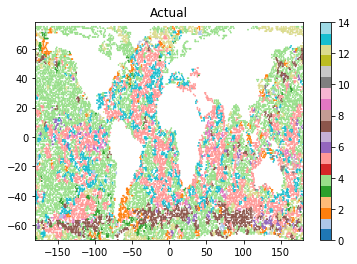

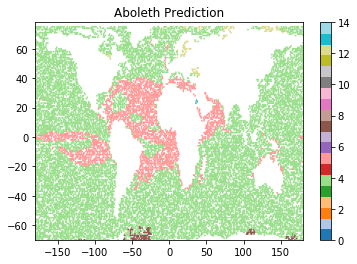

In [8]:
Ey = Ep.argmax(axis=1)
print(accuracy_score(Y_ts, Ey))
draw_global(lon[ind_ts], lat[ind_ts], Y_ts + 1, "Actual")
draw_global(lon[ind_ts], lat[ind_ts], Ey + 1, "Aboleth Prediction")

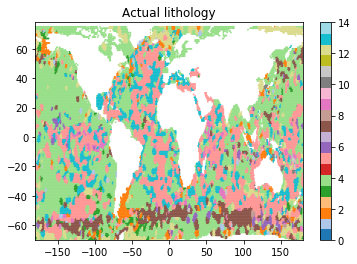

In [9]:
draw_global(lon, lat, y, "Actual lithology")
plt.savefig("Actual_lithology.png")
for i in range(13):
    plt.scatter(lon[ind_ts], lat[ind_ts], c= Ep[:,i])
    plt.title("Predicted probablity distribution of Lithology label {}".format(i + 1))
    plt.colorbar()
    plt.savefig("Prob_lithology_label_{}".format(i+1))
    plt.close()